# BI-PRS - Semestral work 3

In [1]:
# Dataset selection according to the represant's data
K <- 27
L <- nchar('bardatskii')
M <- ((K + L) * 47) %% 11 + 1

cat('Parameter M =', M, '=> Kamil Dedecius')
cat('\nYear =', 2011 + M)

Parameter M = 2 => Kamil Dedecius
Year = 2013

In [ ]:
# TODO: lexicographical order

# Neccessary imports
library(eurostat)
library(car)
library(cowplot)
library(tseries)
library(lmtest)
library(countrycode)
library(stringr)
library(ggplot2)
library(gridExtra)
library(psych)
library(olsrr)
library(corrplot)

## Abstract

The project examines the [**Gross Domestic Product (GDP)**](https://www.investopedia.com/terms/g/gdp.asp) of **European countries** in **2013**. The study investigates [**nominal GDP per capita**](https://www.investopedia.com/terms/n/nominalgdp.asp) in particular.

**Table of contents:**
- Dataset preparation
- GDP elucidation
- Regressors selection
- Dependencies visualization
- Statistical tests
- Linear model
- Outliers
- Multicollinearity
- Model Premises Tests
- Final Model

## Data preparation

In [3]:
# Load the dataset
data <- get_eurostat(id='nama_10_pc')
head(data, 5)

Table nama_10_pc cached at /tmp/RtmpcofU5X/eurostat/d2ba4de4bc8ad8ffdcacfba97edd9eee.rds



freq,unit,na_item,geo,TIME_PERIOD,values
<chr>,<chr>,<chr>,<chr>,<date>,<dbl>
A,CLV10_EUR_HAB,B1GQ,AL,1995-01-01,1310
A,CLV10_EUR_HAB,B1GQ,AL,1996-01-01,1410
A,CLV10_EUR_HAB,B1GQ,AL,1997-01-01,1270
A,CLV10_EUR_HAB,B1GQ,AL,1998-01-01,1390
A,CLV10_EUR_HAB,B1GQ,AL,1999-01-01,1580


Transform the dataset, leaving only **Gross Domestic Product per capita** in euros in **2013** for individual European countries.

In [4]:
colnames(data)[4] <- 'country'  # rename "geo" column
colnames(data)[6] <- 'GDPpc'    # rename "values" column
data <- subset(data,
               na_item == 'B1GQ' &     # Gross domestic product at market prices
               unit == 'CP_EUR_HAB' &  # Current prices, euro per capita
               TIME_PERIOD == '2013-01-01' &
               !(country %in% c(
                   'EU27_2020',  # European Union - 27 countries (from 2020)
                   'EU28',       # European Union - 28 countries (2013-2020)
                   'EU15',       # European Union - 15 countries (1995-2004)
                   'EA',         # Euro area
                   'EA20',       # Euro area – 20 countries (from 2023)
                   'EA19',       # Euro area - 19 countries  (2015-2022)
                   'EA12'        # Euro area - 12 countries (2001-2006)
               )),
               c(country, GDPpc))
data$country <- countrycode(data$country, 'eurostat', 'country.name')
data$country <- factor(data$country)
head(data, 3)

country,GDPpc
<fct>,<dbl>
Albania,3320
Austria,38210
Belgium,35210


In [5]:
any(is.na(data$GDPpc)) # Check for NA values

[1] FALSE

## GDP elucidation

Analyze the `GDPpc` using statistical metrics and visualizations.

In [6]:
describe(data$GDPpc, ranges=F, quant=c(0.25, 0.5, 0.75), IQR=T)[, -1]

,n,mean,sd,skew,kurtosis,se,IQR,Q0.25,Q0.5,Q0.75
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
X1,37,28576.22,26468.78,1.873799,3.839408,4351.441,27700,10480,18680,38180


Skewness and the strong deviation of the mean from the median indicate the presence of an *“eastern”* tail in the distribution. Let's check it out on the histogram.

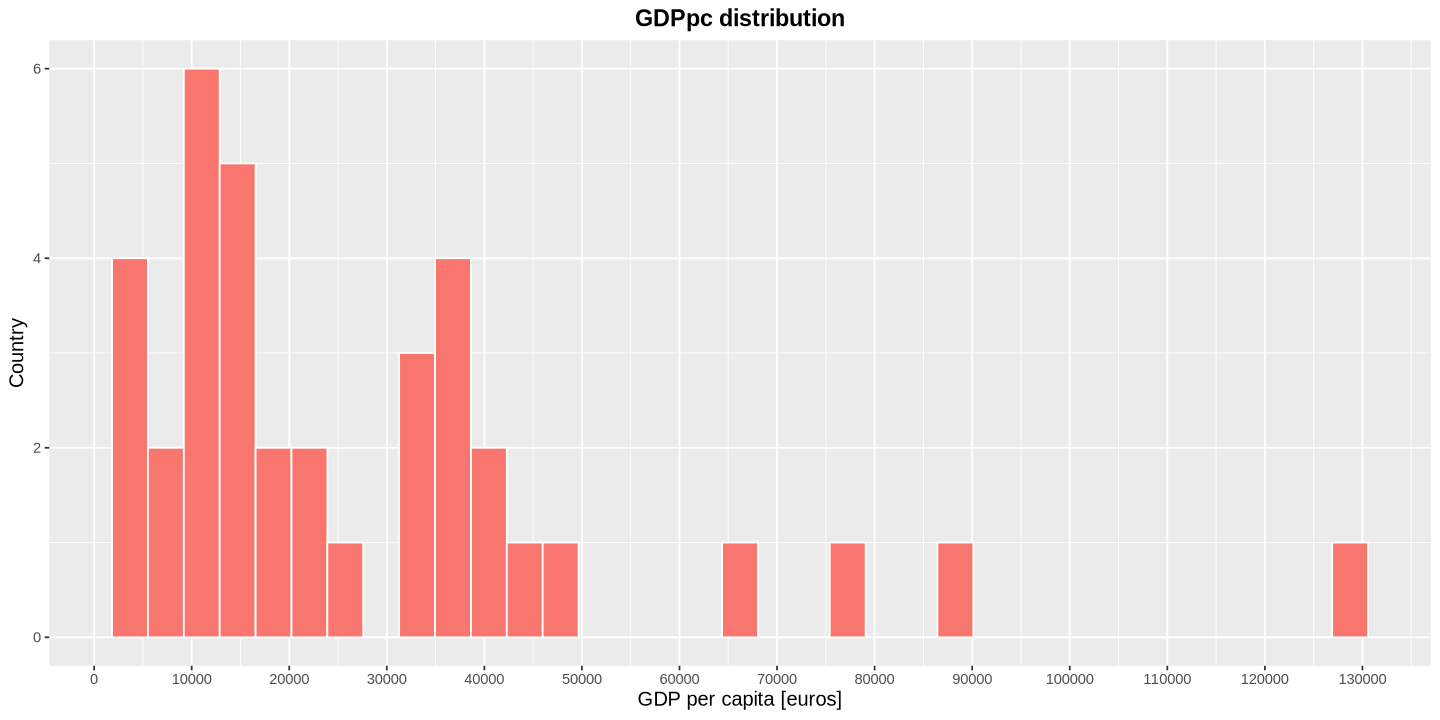

In [7]:
options(repr.plot.width=12, repr.plot.height=6)                        # figure settings 

ggplot(data, aes(x=GDPpc)) +                                           
  geom_histogram(bins=35, fill='#f8766d', col='white') +               # hist
  labs(title='GDPpc distribution',                                     # labels        
       x='GDP per capita [euros]',
       y='Country') + 
  scale_x_continuous(breaks=scales::pretty_breaks(n=12)) +             # set x axis ticks
  theme(
    plot.title = element_text(hjust = 0.5, size=14, face="bold"),      # center and style the title
    axis.title = element_text(size=12),                                # axis title size
  )

As expected, the distribution has a tail. Several countries have a much higher `GDPpc` than the rest.

In addition, three potential clusters can be noticed in the graph: 

1. $\mathrm{GDPpc} \le 30000$,
2. $30000 < \mathrm{GDPpc} \le 60000$,
3. $60000 < \mathrm{GDPpc}$.

Each of these clusters may be amenable to its own distribution.

## Regressors selection

[Many factors](https://www.investopedia.com/articles/investing/051415/how-calculate-gdp-country.asp) can affect the GDP per capita and a country's economy. Below we offer three variants of a continuous variable and one binary. [Human Development Report](https://en.wikipedia.org/wiki/Human_Development_Report) will be a data source for regressors. [(link)](https://hdr.undp.org/data-center/documentation-and-downloads)

### Continuous regressors

In [8]:
# Load the dataset
extra_src_url <- 'https://hdr.undp.org/sites/default/files/2023-24_HDR/HDR23-24_Composite_indices_complete_time_series.csv'

In [9]:
extra_data <- read.csv(url(extra_src_url), encoding='UTF-8')
extra_data$country <- str_replace(extra_data$country, 'T\xfcrkiye', 'Turkey')
head(extra_data, 5)

,iso3,country,hdicode,region,hdi_rank_2022,hdi_1990,hdi_1991,hdi_1992,hdi_1993,hdi_1994,⋯,pop_total_2013,pop_total_2014,pop_total_2015,pop_total_2016,pop_total_2017,pop_total_2018,pop_total_2019,pop_total_2020,pop_total_2021,pop_total_2022
,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,AFG,Afghanistan,Low,SA,182,0.284,0.292,0.299,0.307,0.300,⋯,31.5412085,32.7162100,33.7534990,34.6362075,35.6434175,36.6867840,37.769498,38.972231,40.099462,41.128771
2,ALB,Albania,High,ECA,74,0.649,0.632,0.616,0.618,0.623,⋯,2.8870140,2.8841020,2.8824805,2.8810630,2.8793550,2.8770130,2.873883,2.866849,2.854710,2.842321
3,DZA,Algeria,High,AS,93,0.593,0.596,0.601,0.602,0.603,⋯,38.0006265,38.7601675,39.5431545,40.3393285,41.1365460,41.9270070,42.705368,43.451666,44.177968,44.903225
4,AND,Andorra,Very High,,35,NA,NA,NA,NA,NA,⋯,0.0713665,0.0716215,0.0717455,0.0725405,0.0738365,0.0750135,0.076343,0.077700,0.079034,0.079824
5,AGO,Angola,Medium,SSA,150,NA,NA,NA,NA,NA,⋯,26.1470020,27.1283365,28.1277210,29.1547455,30.2086280,31.2735330,32.353588,33.428486,34.503774,35.588987


In [10]:
# Check if the additional dataset has all countries required
all(data$country %in% extra_data$country)

[1] TRUE

Only some features are needed, which are:
- `LE`: Life Expectancy at Birth (years)
- `MYS`: Mean Years of Schooling (years)
- `EYS`: Expected Years of Schooling (years)
- `GNIpc`: Gross National Income Per Capita (2017 PPP$)
*all for 2013

In [11]:
extra_data <- subset(extra_data,
       country %in% data$country,
       c(
           'country',
           'le_2013',  # Life Expectancy at Birth [years] ~ LE
           'mys_2013',  # Mean Years of Schooling [years] ~ MYS
           'eys_2013',  # Expected Years of Schooling [years] ~ EYS
           'gnipc_2013'  # Gross National Income Per Capita [2017 PPP$] ~ GNIpc
       ))

In [12]:
any(is.na(extra_data)) # Check for NA values

[1] FALSE

In [13]:
data <- merge(data, extra_data, by='country') # Merge the datasets

The indicators in one way or another related to the [Human Development Index](https://en.wikipedia.org/wiki/Human_Development_Index) were taken as a basis.

First of all, let's look at how HDI is calculated:

1. **Life Expectancy Index**: $\mathrm{LEI} = \frac{\mathrm{LE} - 20}{65}$
2. **Education Index**: $\mathrm{EI} = \frac{\frac{\mathrm{MYS}}{15} + \frac{\mathrm{EYS}}{18}}{2}$
3. **Income Index**: $\mathrm{II} = \frac{\ln(\mathrm{GNIpc}) - \ln(100)}{\ln(750)}$
4. **Human Development Index**: $\mathrm{HDI} = \sqrt[3]{\mathrm{LEI} \cdot \mathrm{EI} \cdot \mathrm{II}}$

Instead of using HDI itself, we take its components. However, just taking the presented indexes is not a good idea. Let's see why.

The problem with using LEI is that its values are much more difficult to interpret than LE values. As a consequence, we leave LE untouched.

GNIpc is calculated using the following formula$$\mathrm{GNIpc} = \mathrm{GDPpc} + \mathrm{NFIApc},$$where NFIApc is **Net Factor Income from Abroad per capita** and is calculated as$$\mathrm{NFIApc} = \frac{\text{Money flowing from foreign countries} - \text{Money flowing to foreign countries}}{\text{Population}}.$$

Since GNIpc already contains GDPpc, using it would mean that our model would implicitly learn to predict NFIApc. This is not quite the right approach to the problem at hand. Therefore, we only take NFIApc as a regressor. However, we cannot simply subtract euro GDPpc from dollar GNIpc, we need to convert GNIpc into euros beforehand. For this purpose we use [this](https://www.exchangerates.org.uk/EUR-USD-spot-exchange-rates-history-2013.html#:~:text=Average%20exchange%20rate%20in%202013%3A%201.3284%20USD.) exchange rate.

In [14]:
data$LE <- data$le_2013
data$EI <- (data$mys_2013 / 15 + data$eys_2013 / 18) / 2
data$NFIApc <- data$gnipc_2013 / 1.3284 - data$GDPpc
data <- data[, c('country', 'GDPpc', 'LE', 'EI', 'NFIApc')]
head(data, 5)

,country,GDPpc,LE,EI,NFIApc
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,Albania,3320,78.123,0.7781896,5376.903
2,Austria,38210,81.078,0.8383914,1791.626
3,Belgium,35210,80.468,0.9221770,1962.076
4,Bulgaria,5790,74.849,0.7824033,8144.946
5,Croatia,10480,77.843,0.8044435,7332.921


#### Binary factor

The factor of the country's entry into the [Blue Banana](https://en.wikipedia.org/wiki/Blue_Banana) area was chosen as a binary predictor. The intuition behind this decision is based on the fact that the cities within this zone are of great economic importance.

Here's a [**link**](https://en.wikipedia.org/wiki/Blue_Banana) to the data source.

In [15]:
data$BB_entry <- (data$country %in% c(
    'Austria',
    'Belgium',
    'France',
    'Germany',
    'Italy',
    'Luxembourg',
    'Netherlands',
    'United Kingdom',
    'Liechtenstein',
    'Switzerland'
))

head(data, 5)

,country,GDPpc,LE,EI,NFIApc,BB_entry
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
1,Albania,3320,78.123,0.7781896,5376.903,FALSE
2,Austria,38210,81.078,0.8383914,1791.626,TRUE
3,Belgium,35210,80.468,0.9221770,1962.076,TRUE
4,Bulgaria,5790,74.849,0.7824033,8144.946,FALSE
5,Croatia,10480,77.843,0.8044435,7332.921,FALSE


## Data Visualization

In [253]:
# prepare common parameters and styles
text <- geom_text(aes(label=country), size=3, vjust=-1, hjust=0.5)
scale <- scale_y_continuous(breaks=scales::pretty_breaks(n=5))
theme <- theme(
        plot.title = element_text(hjust = 0.5, size=14, face="bold"),      # center and style the title
        axis.title = element_text(size=12),                                # axis title size
    )

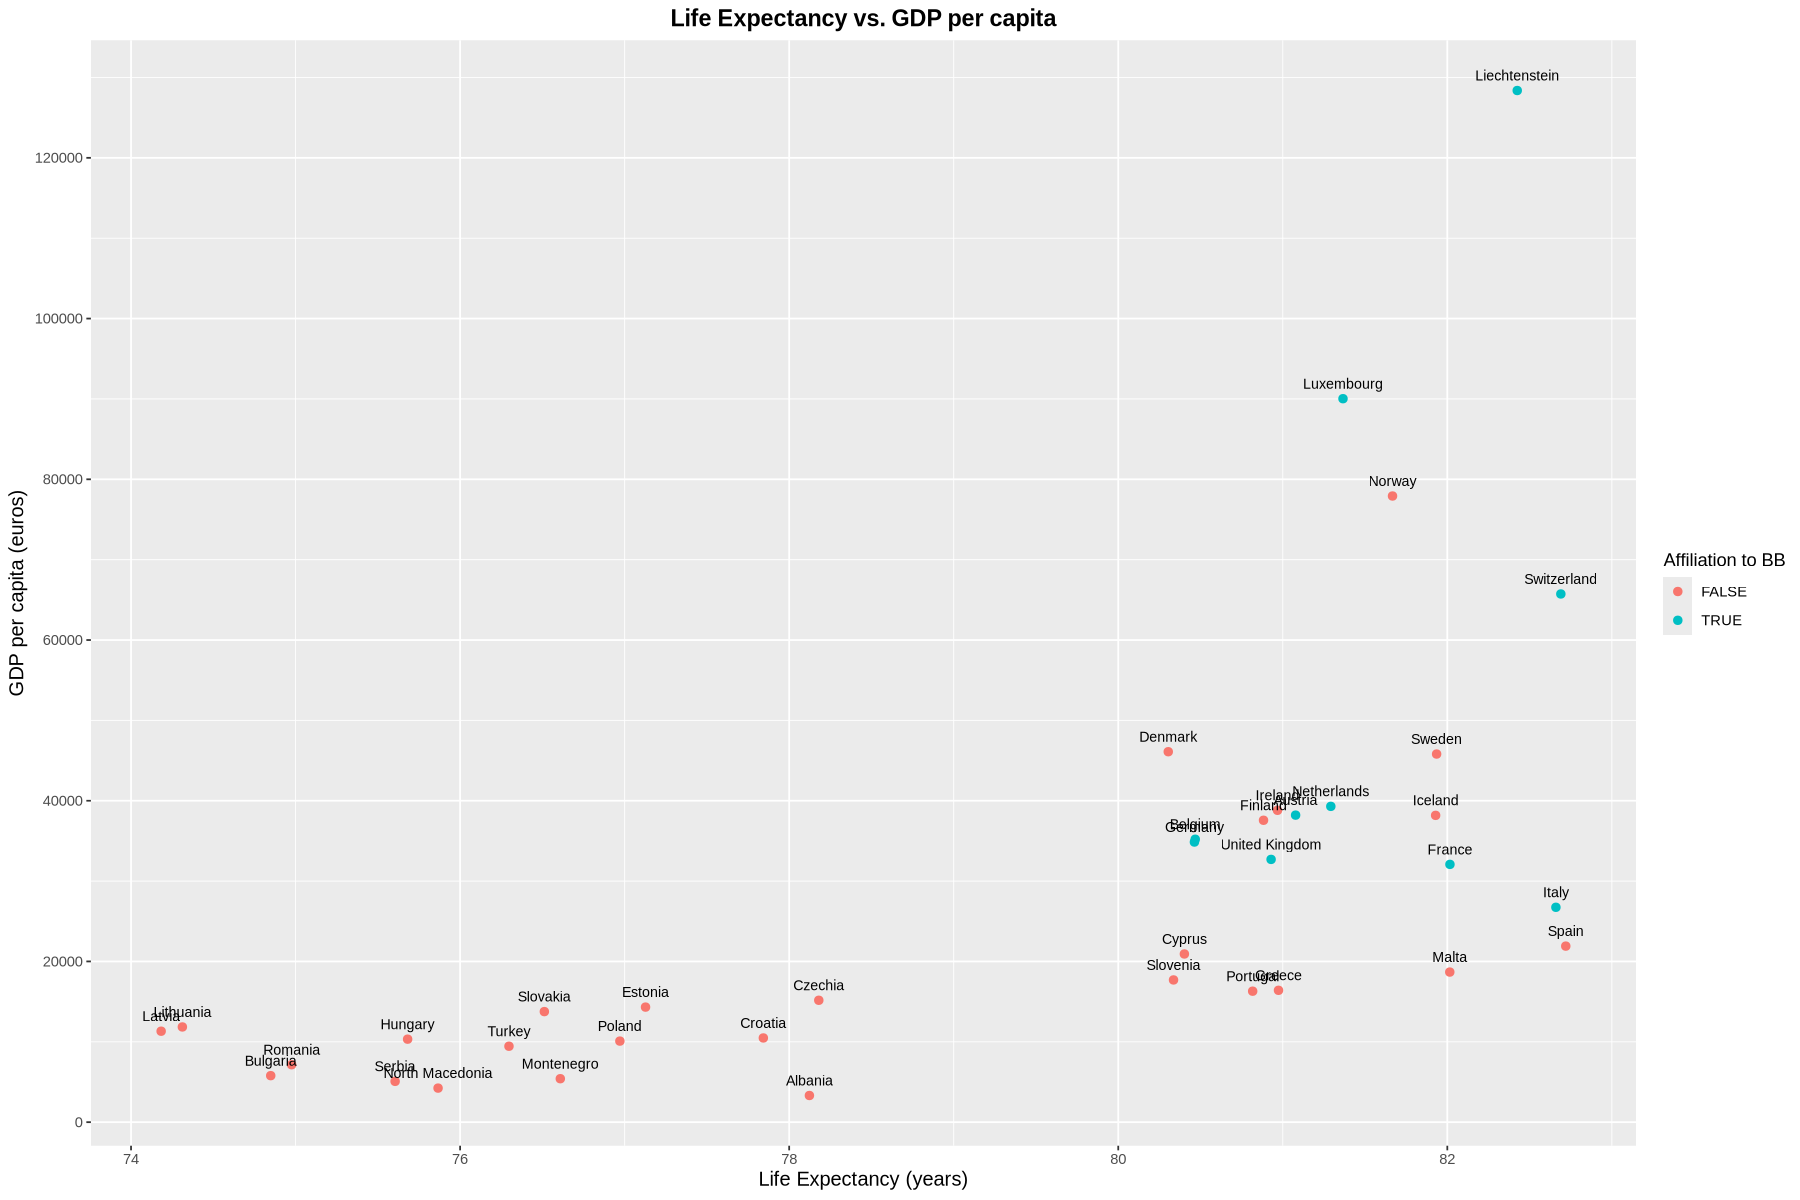

In [265]:
options(repr.plot.width=15, repr.plot.height=10)                        # figure settings 

# save labs for later use for the same scatter plot in different contexts
labs_le <- labs(title='Life Expectancy vs. GDP per capita',                     # labels
               x='Life Expectancy (years)',
               y='GDP per capita (euros)',
               color='Affiliation to BB')
    
ggplot(data, aes(x=LE, y=GDPpc)) +
  geom_point(aes(col=BB_entry), size=2) +                                    
  labs_le + text + scale + theme

- The plot helps visualize economic disparities and their potential impact on life expectancy across different countries.
- There is a visible trend where countries with higher GDP per capita and affiliation to BB generally have higher life expectancies.

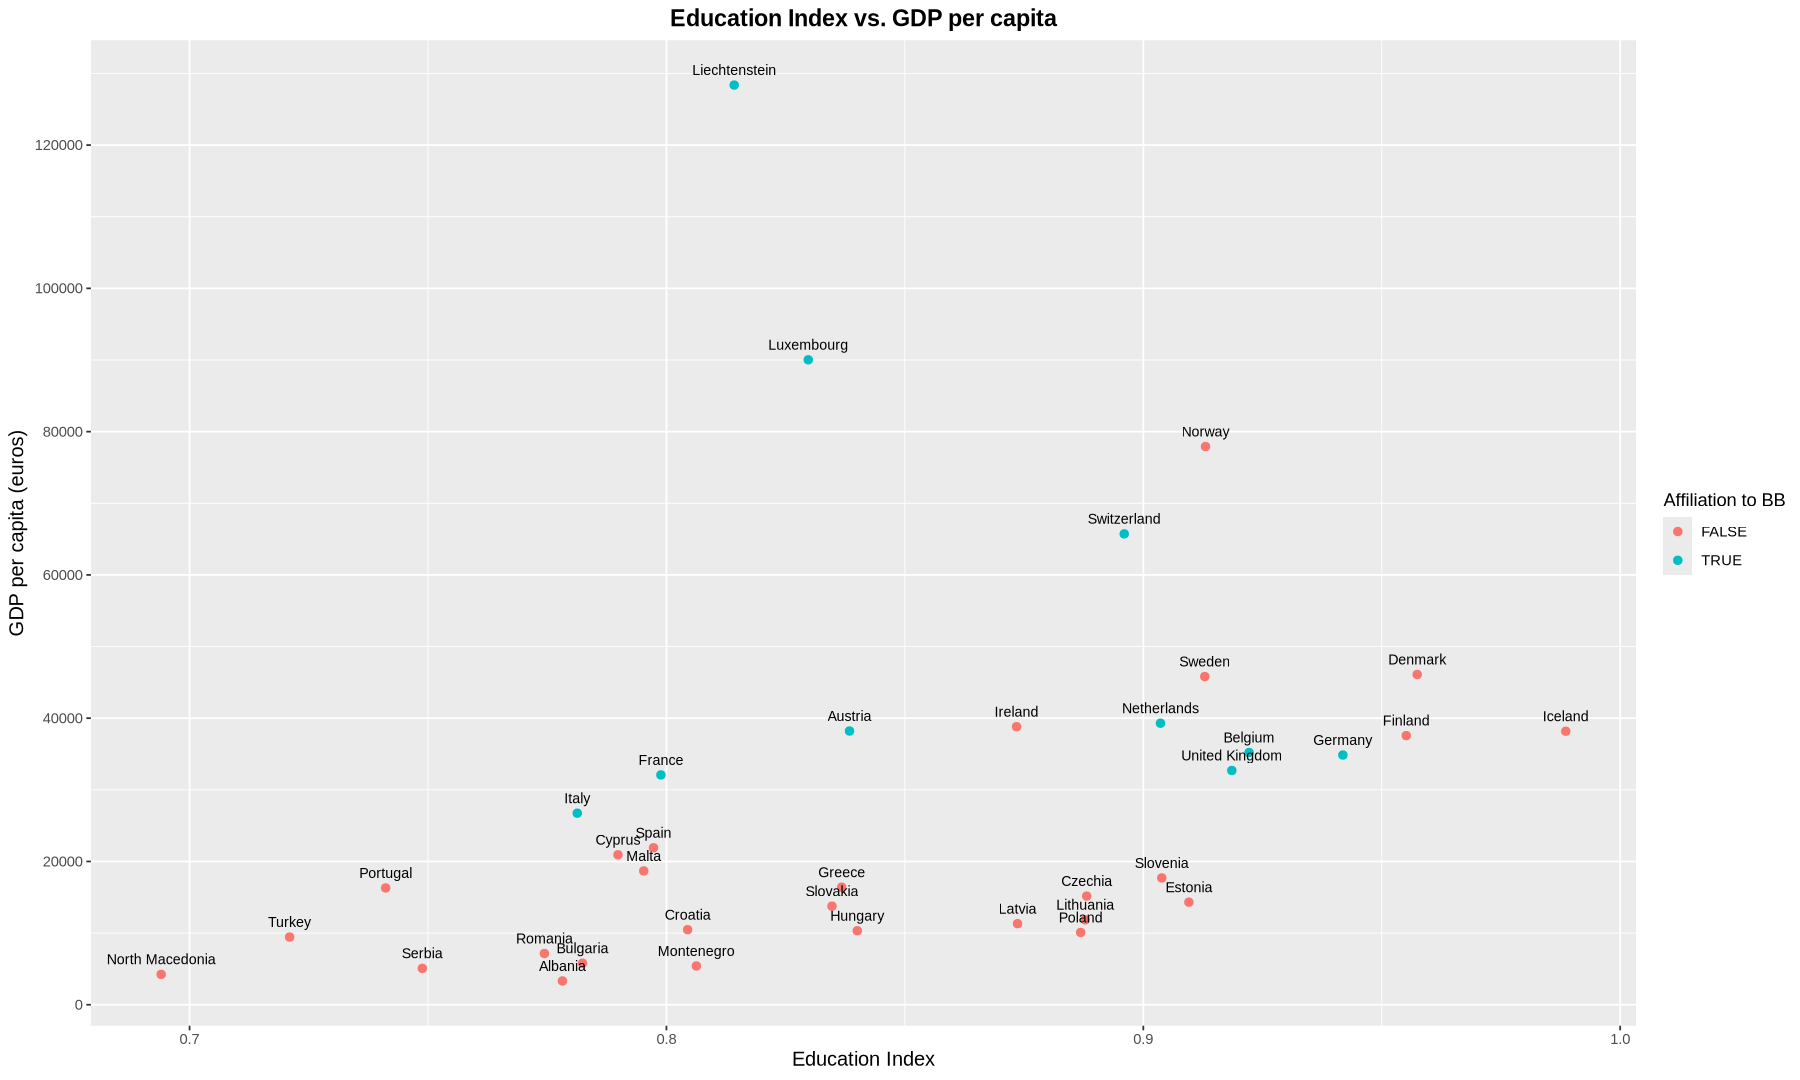

In [266]:
options(repr.plot.width=15, repr.plot.height=9)                        # figure settings 

labs_ei <- labs(title='Education Index vs. GDP per capita',                     # labels
               x='Education Index',
               y='GDP per capita (euros)',
               color='Affiliation to BB')

ggplot(data, aes(x=EI, y=GDPpc)) +
  geom_point(aes(col=BB_entry), size=2) + 
  labs_ei + text + scale + theme

- There is a general trend showing that countries with higher Education Index scores tend to have higher GDP per capita.
- Outliers like Liechtenstein and Luxembourg have exceptionally high GDP per capita compared to their Education Index.
- Countries with lower Education Index scores (around 0.7 to 0.8) generally have lower GDP per capita, such as North Macedonia, Turkey, and Serbia.

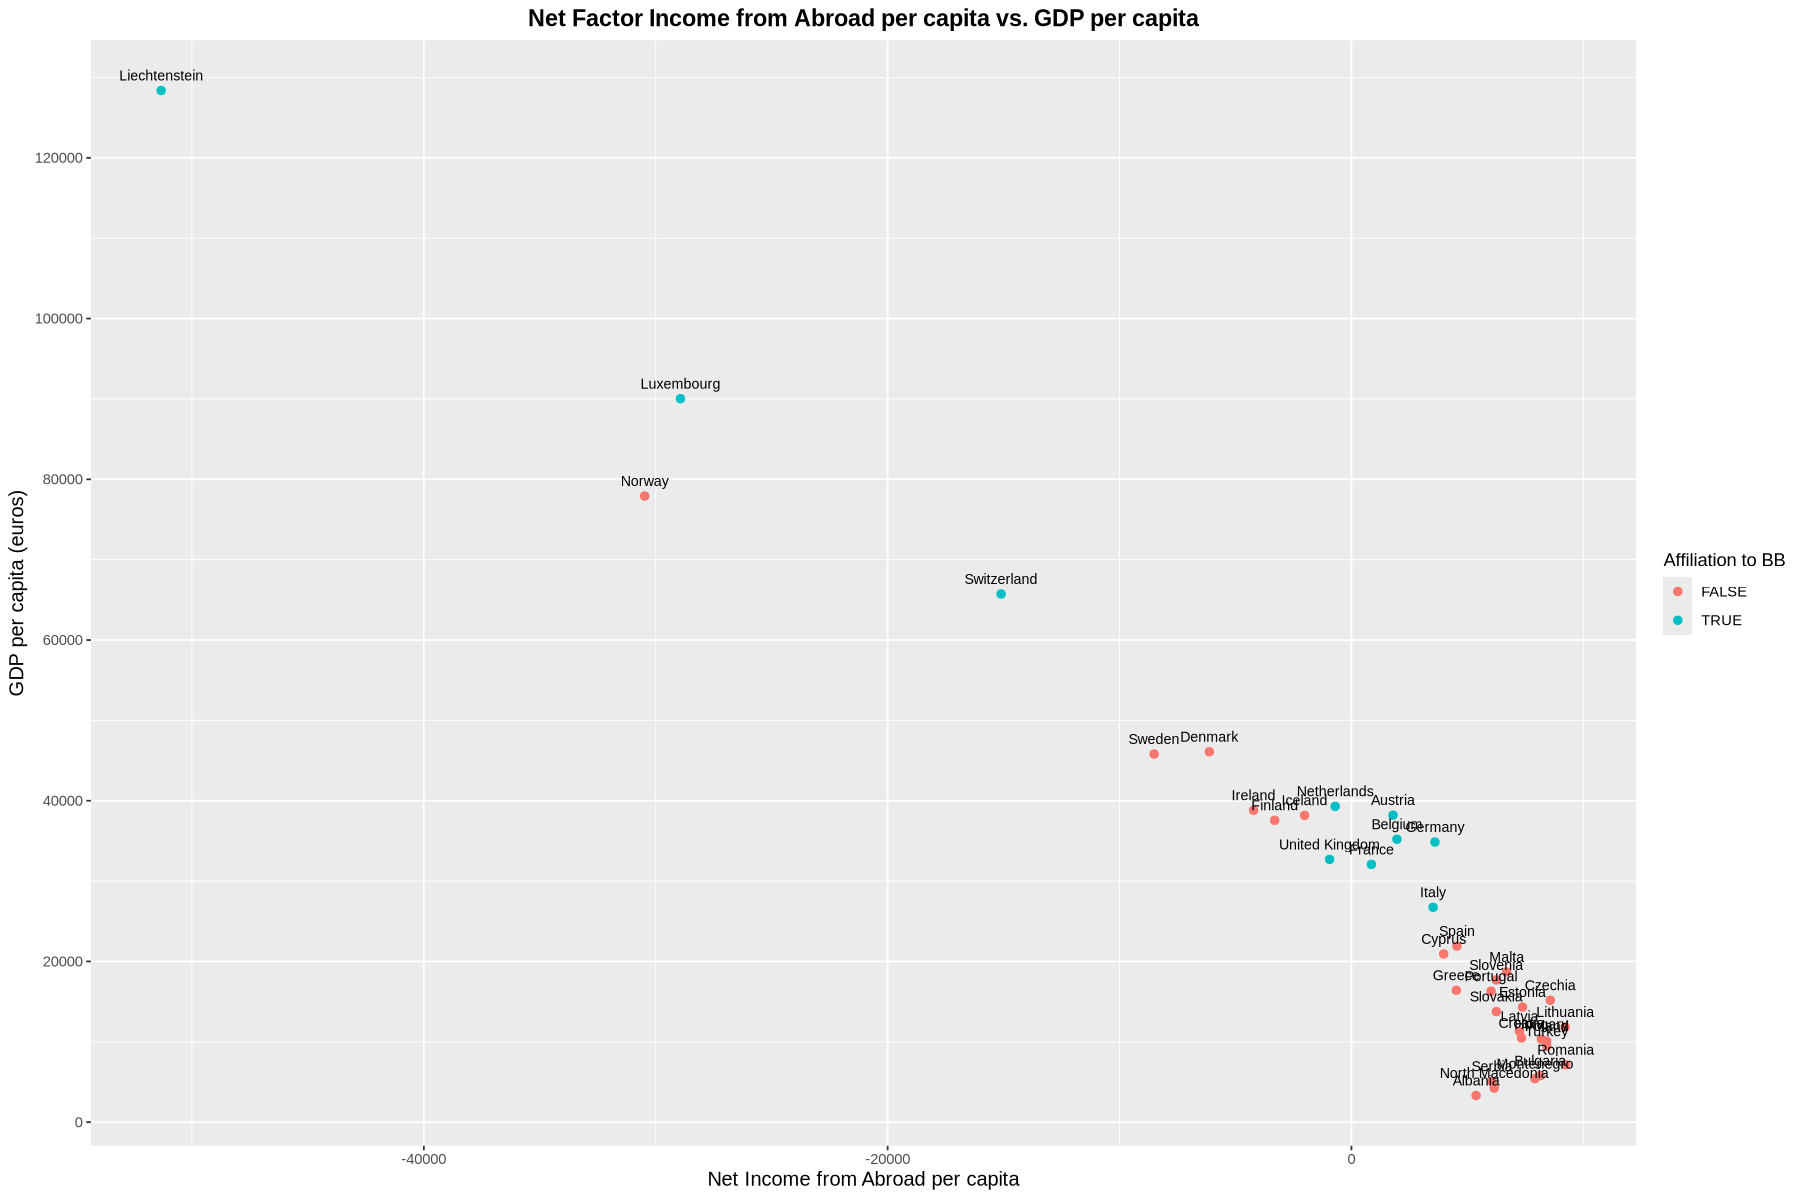

In [306]:
options(repr.plot.width=15, repr.plot.height=10)                        # figure settings 
labs_nfiapc <- labs(title='Net Factor Income from Abroad per capita vs. GDP per capita',   # labels
                   x='Net Income from Abroad per capita',
                   y='GDP per capita (euros)',
                   color='Affiliation to BB')

ggplot(data, aes(x=NFIApc, y=GDPpc)) +
  geom_point(aes(col=BB_entry), size=2) +
  labs_nfiapc + text + scale + theme

- Liechtenstein, Luxembourg, and Norway are notable outliers with high GDP per capita despite negative or zero Net Income from Abroad per capita.
- Most countries cluster around lower GDP per capita values and with low positive Net Income from Abroad per capita.
- The majority of countries have positive Net Income from Abroad per capita, but there are a lot of countries with negative values, suggesting that they spend more abroad than they receive.

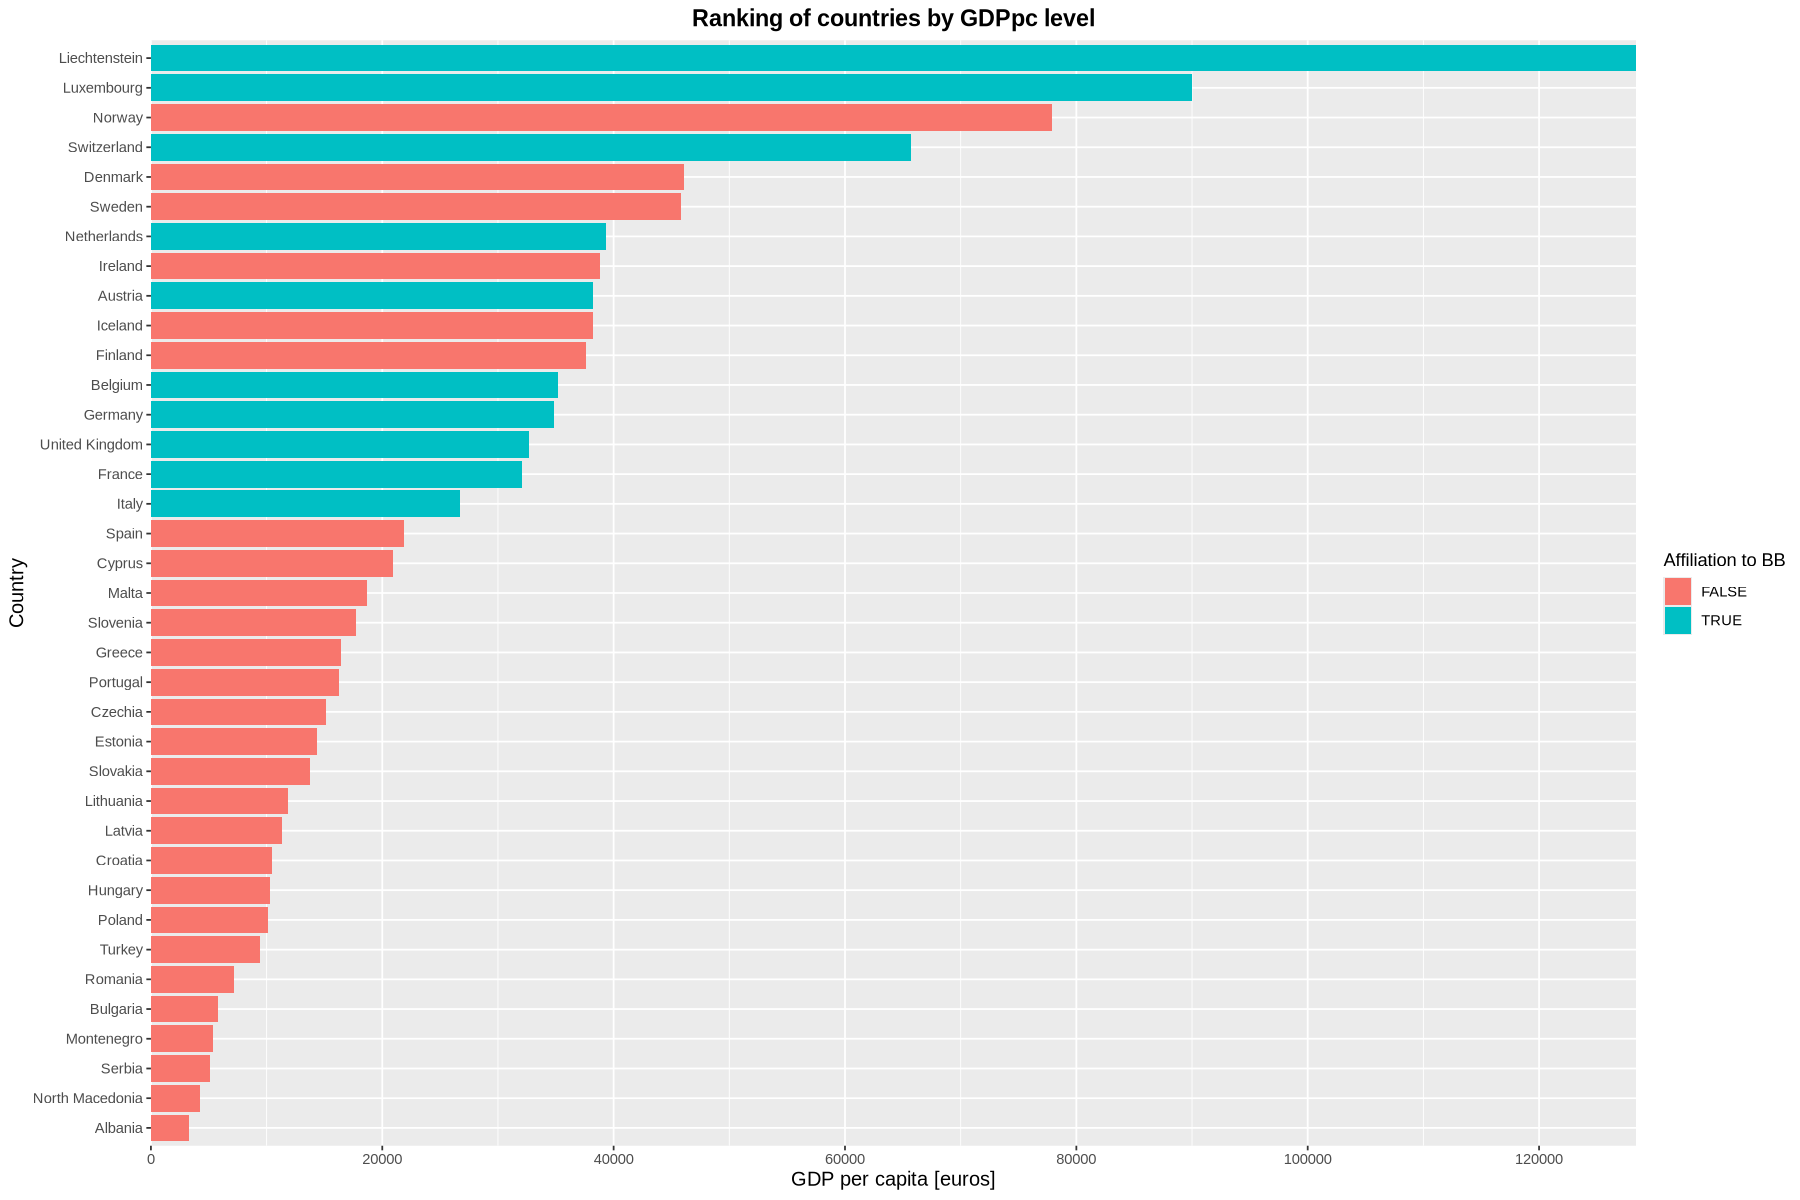

In [257]:
options(repr.plot.width=15, repr.plot.height=10)                        # figure settings 

ggplot(data, aes(x=GDPpc, y=reorder(country, GDPpc), fill=BB_entry)) +
  geom_bar(stat='identity') +
  labs(title='Ranking of countries by GDPpc level',
       x='GDP per capita [euros]',
       y='Country',
       fill='Affiliation to BB') +
  scale_x_continuous(breaks=scales::pretty_breaks(n=6), expand=c(0, 0)) + theme

- Top Performers: Liechtenstein, Luxembourg, and Norway are at the top of the list, having the highest GDP per capita.
- Mid-range Performers: Countries like Germany, the United Kingdom, and France are in the middle range, with moderate GDP per capita levels.
- Lower Performers: Countries like Albania, North Macedonia, and Serbia are at the bottom, with the lowest GDP per capita.
- Countries that are listed in BB are placed only in best performing half of the countries presented.

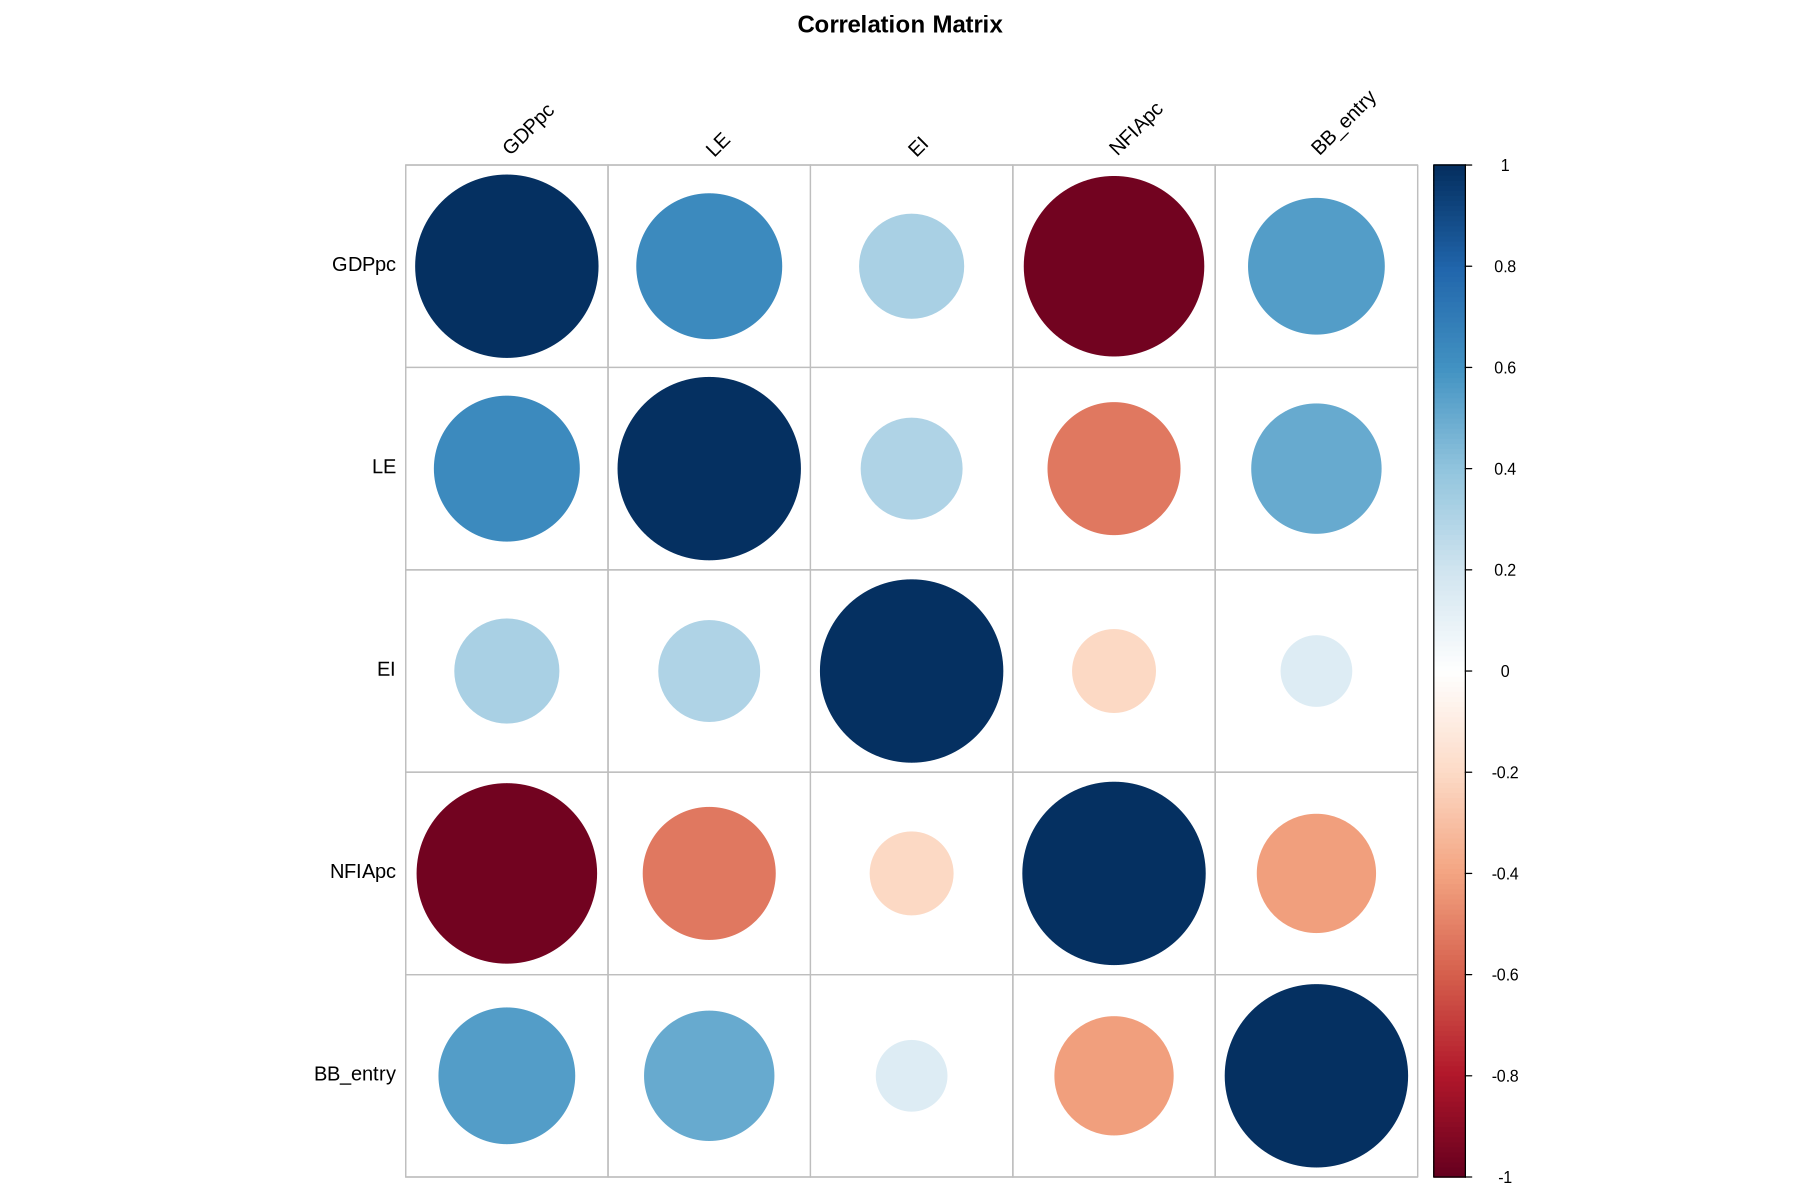

In [20]:
corrplot(cor(data[, -1]), method="circle", 
         tl.col="black", tl.srt=45, 
         title="Correlation Matrix", mar=c(0,0,2,0))

- GDPpc and LE: There is a strong positive correlation between GDP per capita and Life Expectancy, suggesting that higher economic output per person is associated with longer life expectancy.
- NFIapc and GDPpc: There is a strong negative correlation between Net Foreign Income per capita and GDP per capita, suggesting that countries with high GDP per capita tend to have lower net foreign income per capita.
- NFIapc and LE: Similarly, there is a negative correlation between Net Foreign Income per capita and Life Expectancy.

## Tests

In [21]:
# ??????

## Linear model

First of all, we will try a model with all features and assess its quality. After that we will try to understand non-linear relationships between target variable and independent variables.

### Simple Linear Model

We try a simple linear model with all regressors without use of functions:

In [318]:
model <- lm(GDPpc ~ LE + EI + NFIApc + BB_entry, data = data)
summary(model)


Call:
lm(formula = GDPpc ~ LE + EI + NFIApc + BB_entry, data = data)

Residuals:
   Min     1Q Median     3Q    Max 
-10322  -1414      4   2483   5292 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -7.239e+04  2.214e+04  -3.270 0.002578 ** 
LE            8.415e+02  2.869e+02   2.934 0.006151 ** 
EI            3.814e+04  8.974e+03   4.250 0.000173 ***
NFIApc       -1.747e+00  5.781e-02 -30.215  < 2e-16 ***
BB_entryTRUE  8.231e+03  1.613e+03   5.103 1.47e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3680 on 32 degrees of freedom
Multiple R-squared:  0.9828,	Adjusted R-squared:  0.9807 
F-statistic: 457.6 on 4 and 32 DF,  p-value: < 2.2e-16


**Results interpretation:**
- Intercept: -72210 : predicted value of GDPpc when all independent variables are zero.
- LE (Life Expectancy): 839.6 : for each additional year of life expectancy, GDPpc is expected to increase by 839.6 units
- EI (Education Index): 38100 : for each unit increase in the education index, GDPpc is expected to increase by 38100 units
- NFIApc (Net Factor Foreign Income per capita): -1.746 : for each unit increase in net foreign income per capita, GDPpc is expected to decrease by 1.746 units
- BB_entryTRUE: 8246 : f BB_entry is TRUE, GDPpc is expected to increase by 8246 units compared to when BB_entry is FALSE.

- Adjusted R-squared: 0.9807 : 98.07% of the variability is explained, suggesting a very good model fit.

**Conclusion:**
The regression analysis shows that all independent variables (LE, EI, NFIapc, and BB_entry) are significant predictors of GDPpc. Life expectancy and education index positively impact GDPpc, while net foreign income per capita has a negative impact. The binary variable BB_entry being true also positively impacts GDPpc. The model is a very good fit for the data.

### Inspecting Numeric Regressors

#### Life Expectancy

In [271]:
fit_le_lin <- lm(GDPpc~LE, data=data)
summary(fit_le_lin)


Call:
lm(formula = GDPpc ~ LE, data = data)

Residuals:
   Min     1Q Median     3Q    Max 
-27402  -9408  -1249   3485  80847 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -449755      99444  -4.523 6.72e-05 ***
LE              6033       1254   4.813 2.82e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 20820 on 35 degrees of freedom
Multiple R-squared:  0.3983,	Adjusted R-squared:  0.3811 
F-statistic: 23.16 on 1 and 35 DF,  p-value: 2.82e-05


In [272]:
fit_le_poly <- lm(GDPpc~poly(LE,2), data=data)
summary(fit_le_poly)


Call:
lm(formula = GDPpc ~ poly(LE, 2), data = data)

Residuals:
   Min     1Q Median     3Q    Max 
-36004  -9282   -628   2830  74506 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)     28576       3358   8.511 6.11e-10 ***
poly(LE, 2)1   100222      20424   4.907 2.27e-05 ***
poly(LE, 2)2    31543      20424   1.544    0.132    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 20420 on 34 degrees of freedom
Multiple R-squared:  0.4377,	Adjusted R-squared:  0.4046 
F-statistic: 13.23 on 2 and 34 DF,  p-value: 5.616e-05


Using polynomial function we increased our model performance, including the adjusted R-squared. Let's assess improvement visually:

In [276]:
# gather data for scatterplots by combining predictions and dataset into one dataframe

# get predictions
fit_le_lin_pred <- predict(fit_le_lin, interval="prediction")
fit_le_poly_pred <- predict(fit_le_poly, interval="prediction")

# combine predictions with data
data_fit_le_lin <- cbind(data, fit_le_lin_pred)
data_fit_le_poly <- cbind(data, fit_le_poly_pred)

# create plots
le_lin_plot <- ggplot(data_fit_le_lin, aes(x=LE, y=GDPpc)) +
    geom_point(aes(col=BB_entry), size=3) +
    geom_line(aes(y=fit), color='blue', size=1) +                          # regression curve
    labs_le + text + scale + theme

# create plots
le_poly_plot <- ggplot(data_fit_le_poly, aes(x=LE, y=GDPpc)) +
    geom_point(aes(col=BB_entry), size=3) +
    geom_line(aes(y=fit), color='blue', size=1) +                          # regression curve
    labs.le + text + scale + theme

Warning message in predict.lm(fit_le_lin, interval = "prediction"):
“predictions on current data refer to _future_ responses
”
Warning message in predict.lm(fit_le_poly, interval = "prediction"):
“predictions on current data refer to _future_ responses
”


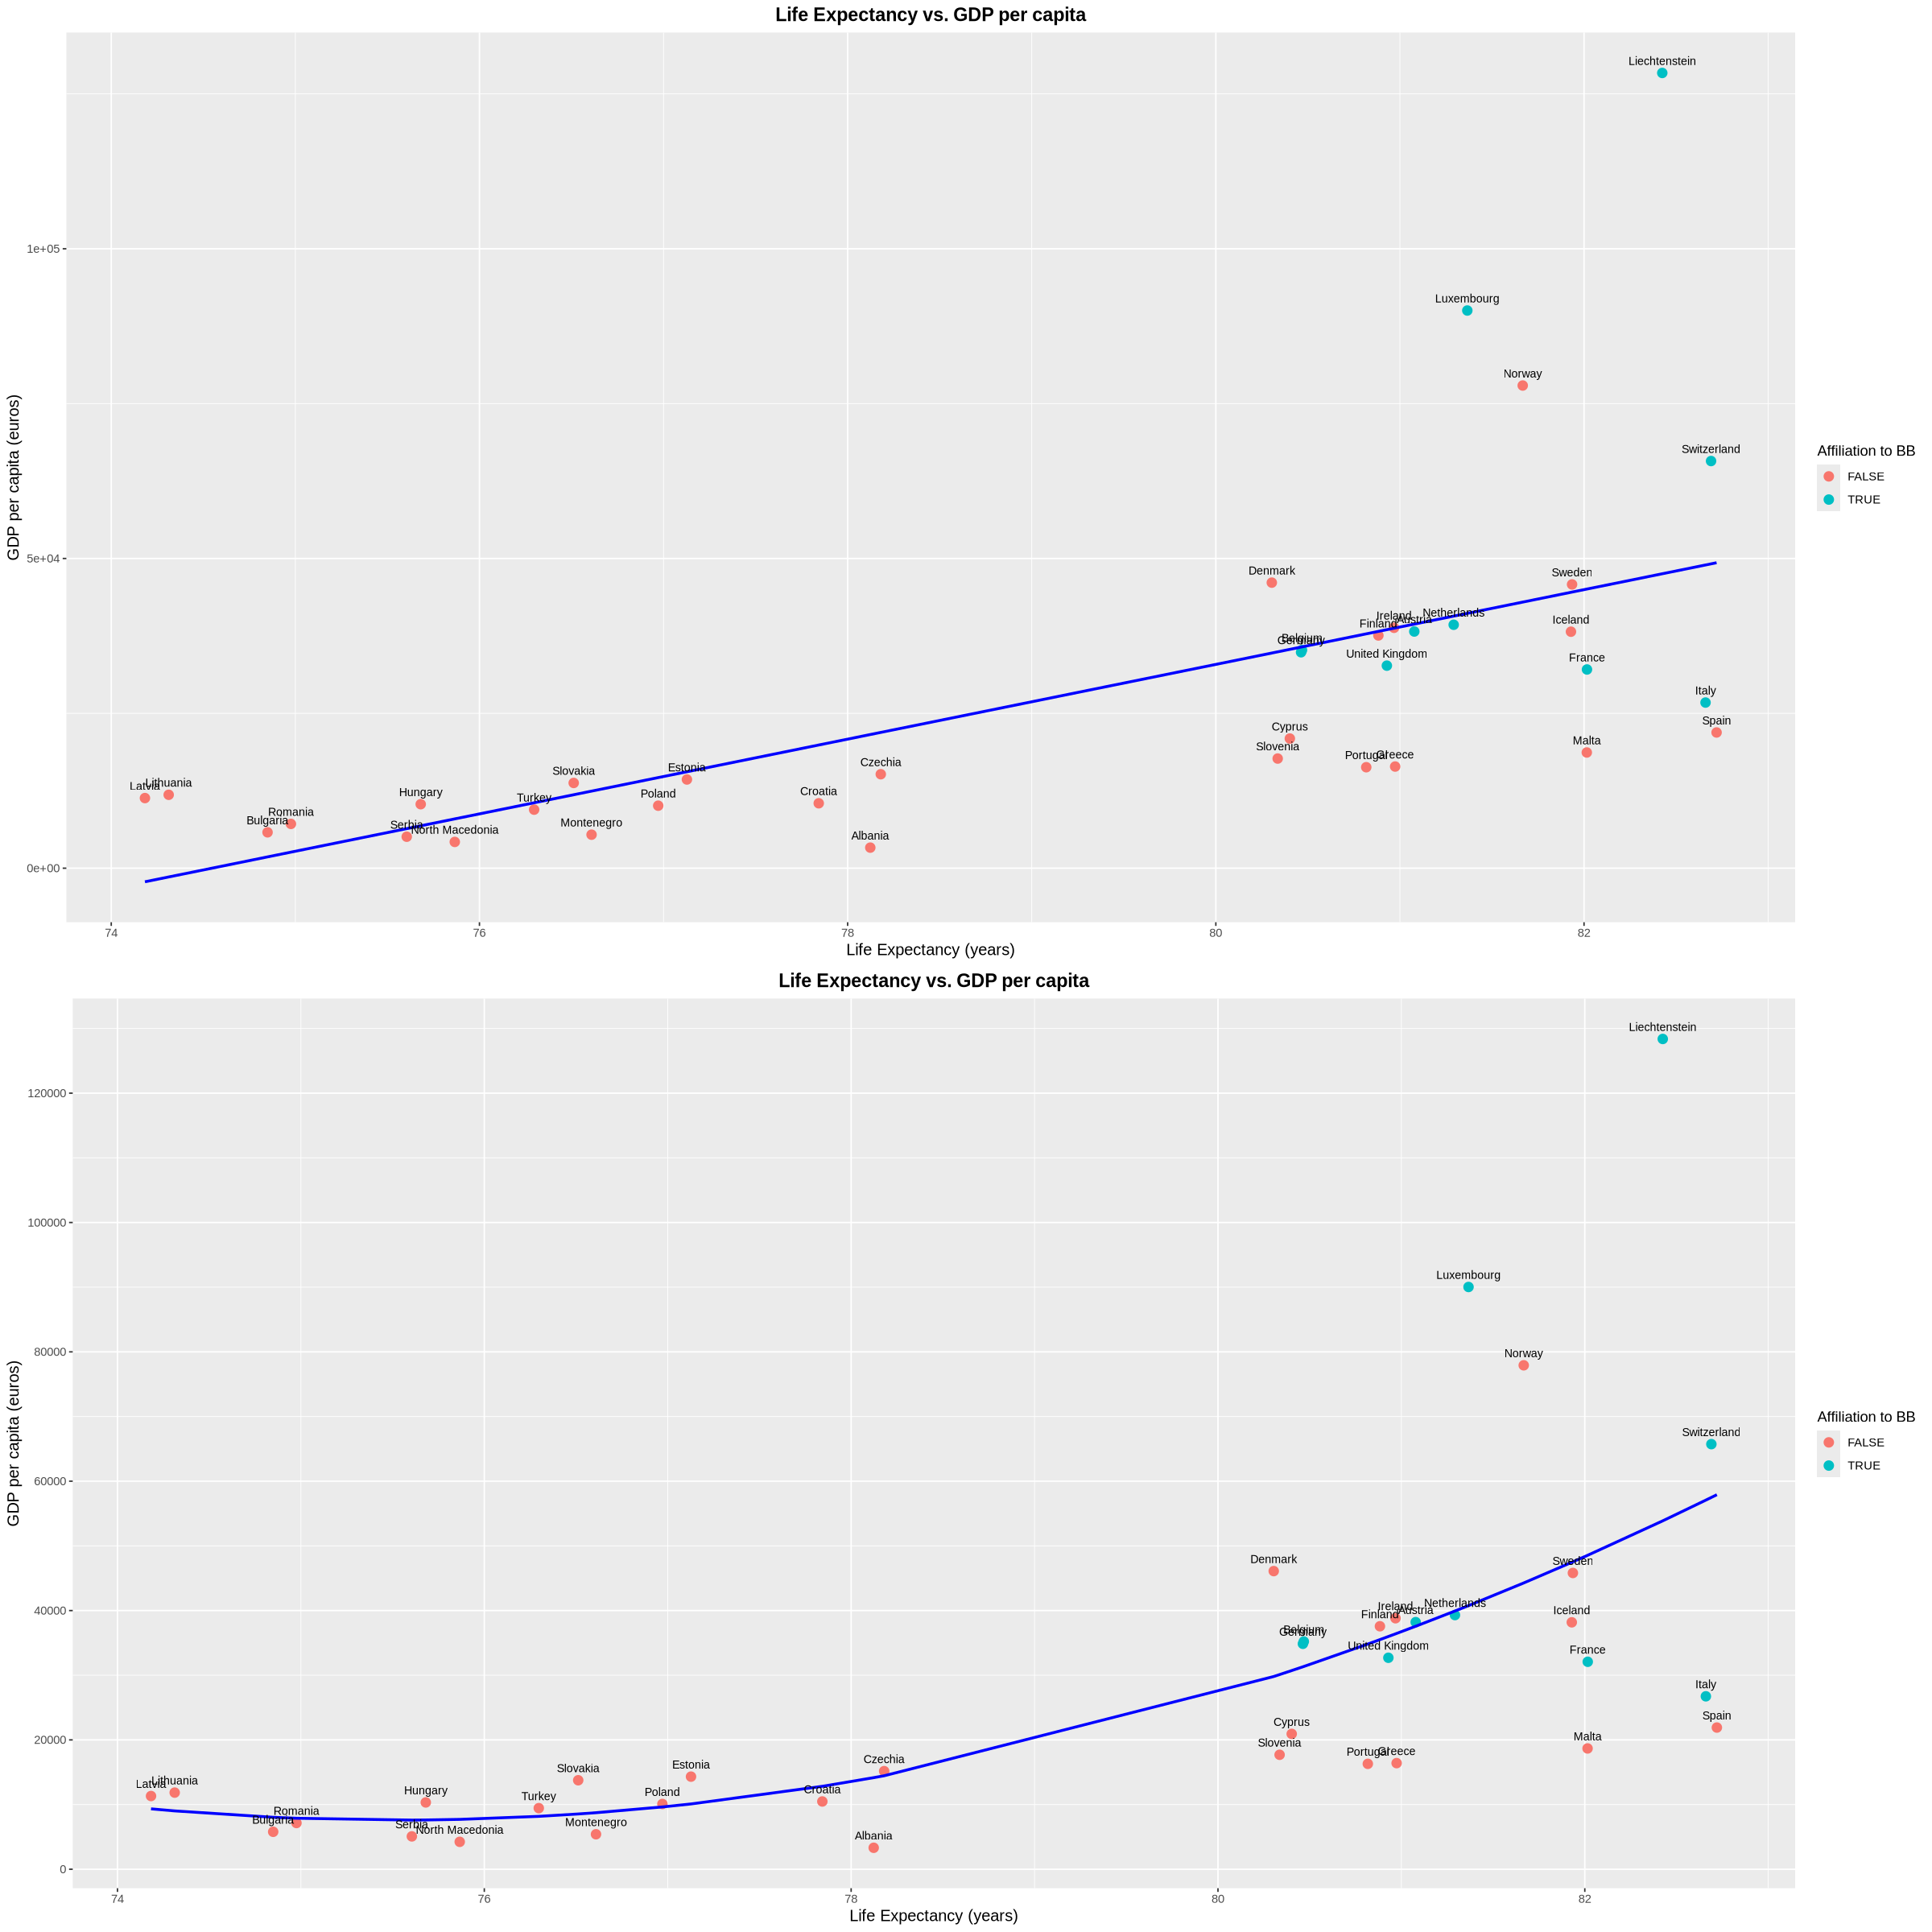

In [282]:
# set up plot size
options(repr.plot.width = 20, repr.plot.height=20)
plot_grid(le_lin_plot, le_poly_plot, nrow=2)

Visually we see that using polynomial function, the data are better described by the independent variable.

#### Education Index

In [300]:
fit_ei_lin <- lm(GDPpc~EI, data=data)
summary(fit_ei_lin)


Call:
lm(formula = GDPpc ~ EI, data = data)

Residuals:
   Min     1Q Median     3Q    Max 
-23257 -15052  -4441   4306 103731 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)   -72815      50016  -1.456   0.1544  
EI            119704      58844   2.034   0.0496 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 25390 on 35 degrees of freedom
Multiple R-squared:  0.1057,	Adjusted R-squared:  0.08018 
F-statistic: 4.138 on 1 and 35 DF,  p-value: 0.04956


In [301]:
fit_ei_poly <- lm(GDPpc~poly(EI, 2), data=data)
summary(fit_ei_poly)


Call:
lm(formula = GDPpc ~ poly(EI, 2), data = data)

Residuals:
   Min     1Q Median     3Q    Max 
-24946 -15952  -2215   4872 101546 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)     28576       4205   6.796 8.14e-08 ***
poly(EI, 2)1    51641      25579   2.019   0.0514 .  
poly(EI, 2)2   -17586      25579  -0.688   0.4964    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 25580 on 34 degrees of freedom
Multiple R-squared:  0.118,	Adjusted R-squared:  0.06611 
F-statistic: 2.274 on 2 and 34 DF,  p-value: 0.1183


With this regressor, we see that the adjusted R-squared descreased. Let's assess visually:

In [302]:
# gather data for scatterplots by combining predictions and dataset into one dataframe

# get predictions
fit_ei_lin_pred <- predict(fit_ei_lin, interval="prediction")
fit_ei_poly_pred <- predict(fit_ei_poly, interval="prediction")

# combine predictions with data
data_fit_ei_lin <- cbind(data, fit_ei_lin_pred)
data_fit_ei_poly <- cbind(data, fit_ei_poly_pred)

# create plots
ei_lin_plot <- ggplot(data_fit_ei_lin, aes(x=EI, y=GDPpc)) +
    geom_point(aes(col=BB_entry), size=3) +
    geom_line(aes(y=fit), color='blue', size=1) +                          # regression curve
    labs_ei + text + scale + theme

# create plots
ei_poly_plot <- ggplot(data_fit_ei_poly, aes(x=EI, y=GDPpc)) +
    geom_point(aes(col=BB_entry), size=3) +
    geom_line(aes(y=fit), color='blue', size=1) +                          # regression curve
    labs.ei + text + scale + theme

Warning message in predict.lm(fit_ei_lin, interval = "prediction"):
“predictions on current data refer to _future_ responses
”
Warning message in predict.lm(fit_ei_poly, interval = "prediction"):
“predictions on current data refer to _future_ responses
”


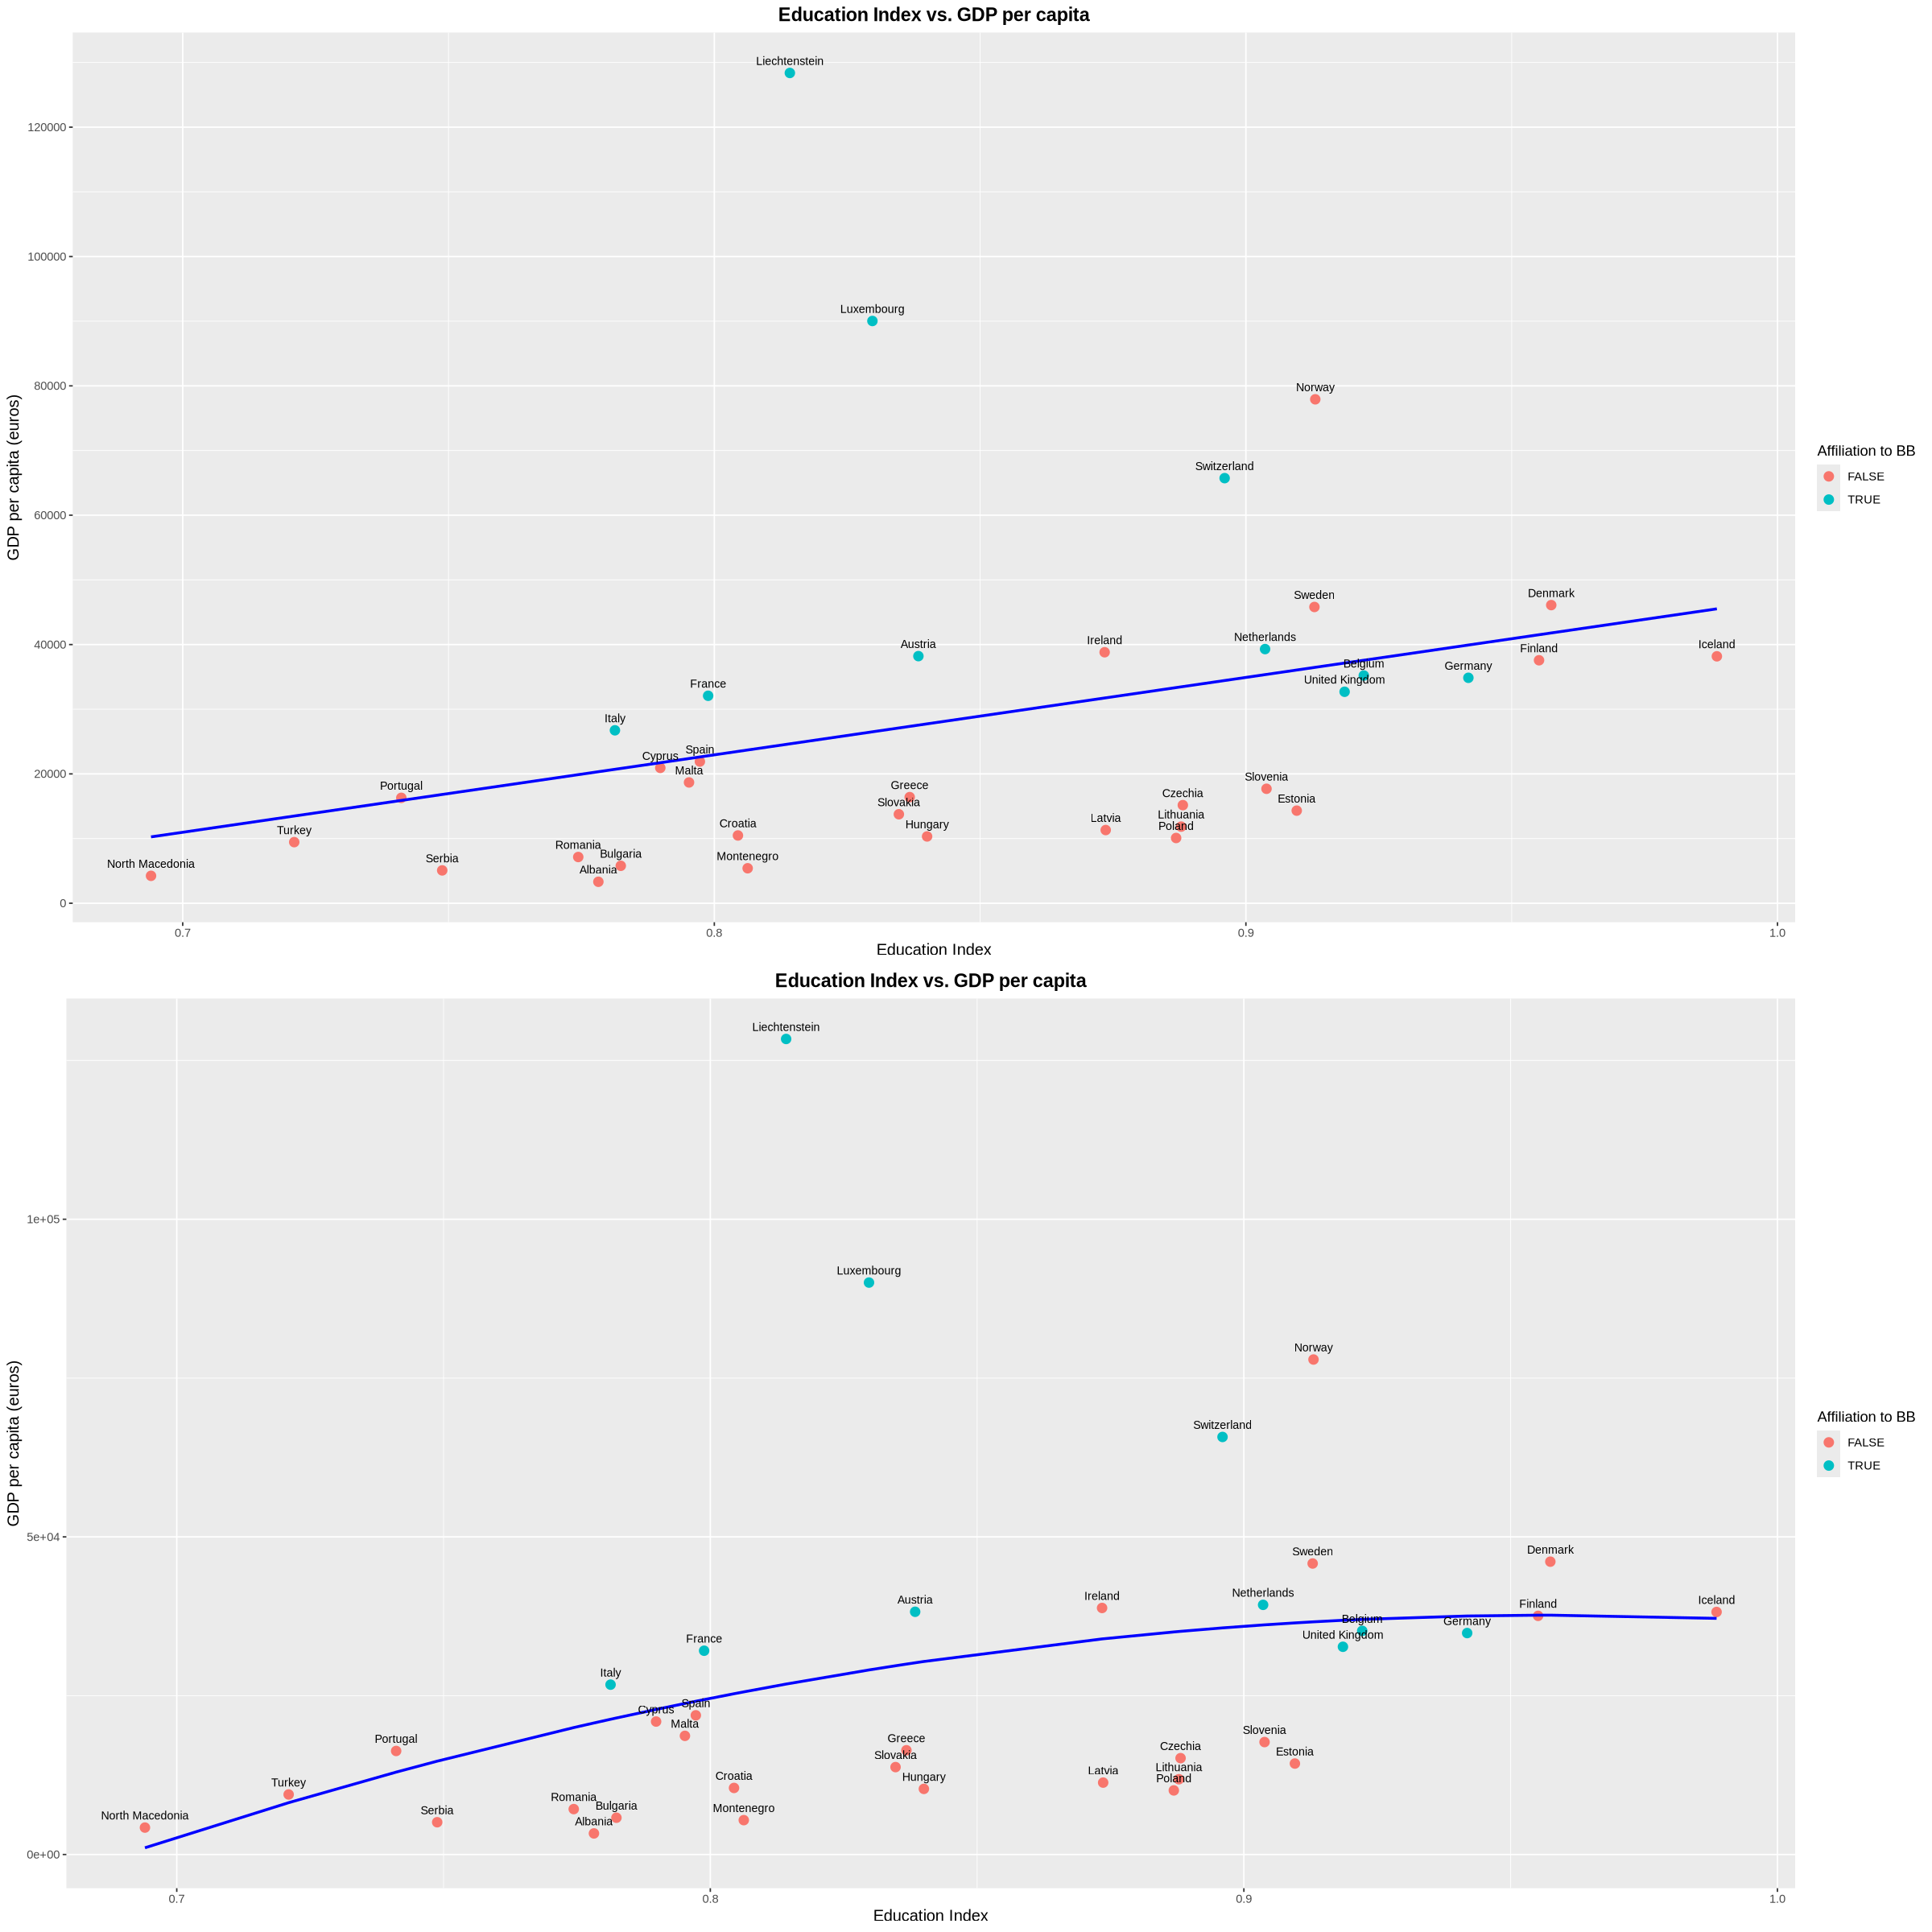

In [304]:
# set up plot size
options(repr.plot.width = 20, repr.plot.height=20)
plot_grid(ei_lin_plot, ei_poly_plot, nrow=2)

The polynomial fnction does not help much here. Instead, because of the outliers, its middle is shifted towards them, which is not good. 

Thus, with this regressor we will not use polynomial function.

#### Net Factor Income from Abroad per capita

In [308]:
fit_nfiapc_lin <- lm(GDPpc~NFIApc, data=data)
summary(fit_nifapc_lin)


Call:
lm(formula = GDPpc ~ NFIApc, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-14782.8  -3188.9    239.6   3493.9  13192.3 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.890e+04  1.096e+03   26.38   <2e-16 ***
NFIApc      -2.008e+00  8.701e-02  -23.08   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6664 on 35 degrees of freedom
Multiple R-squared:  0.9384,	Adjusted R-squared:  0.9366 
F-statistic: 532.9 on 1 and 35 DF,  p-value: < 2.2e-16


In [310]:
fit_nfiapc_poly <- lm(GDPpc~poly(NFIApc, 2), data=data)
summary(fit_nfiapc_poly)


Call:
lm(formula = GDPpc ~ poly(NFIApc, 2), data = data)

Residuals:
   Min     1Q Median     3Q    Max 
-14426  -1848    -72   3514  12810 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)         28576       1039   27.51   <2e-16 ***
poly(NFIApc, 2)1  -153841       6319  -24.35   <2e-16 ***
poly(NFIApc, 2)2   -14031       6319   -2.22   0.0332 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6319 on 34 degrees of freedom
Multiple R-squared:  0.9462,	Adjusted R-squared:  0.943 
F-statistic: 298.8 on 2 and 34 DF,  p-value: < 2.2e-16


There is some minor improvement of adjusted R-squared.

In [311]:
# gather data for scatterplots by combining predictions and dataset into one dataframe

# get predictions
fit_nfiapc_lin_pred <- predict(fit_nfiapc_lin, interval="prediction")
fit_nfiapc_poly_pred <- predict(fit_nfiapc_poly, interval="prediction")

# combine predictions with data
data_fit_nfiapc_lin <- cbind(data, fit_nfiapc_lin_pred)
data_fit_nfiapc_poly <- cbind(data, fit_nfiapc_poly_pred)

# create plots
nfiapc_lin_plot <- ggplot(data_fit_nfiapc_lin, aes(x=NFIApc, y=GDPpc)) +
    geom_point(aes(col=BB_entry), size=3) +
    geom_line(aes(y=fit), color='blue', size=1) +                          # regression curve
    labs_nfiapc + text + scale + theme

# create plots
nfiapc_poly_plot <- ggplot(data_fit_nfiapc_poly, aes(x=NFIApc, y=GDPpc)) +
    geom_point(aes(col=BB_entry), size=3) +
    geom_line(aes(y=fit), color='blue', size=1) +                          # regression curve
    labs_nfiapc + text + scale + theme

Warning message in predict.lm(fit_nfiapc_lin, interval = "prediction"):
“predictions on current data refer to _future_ responses
”
Warning message in predict.lm(fit_nfiapc_poly, interval = "prediction"):
“predictions on current data refer to _future_ responses
”


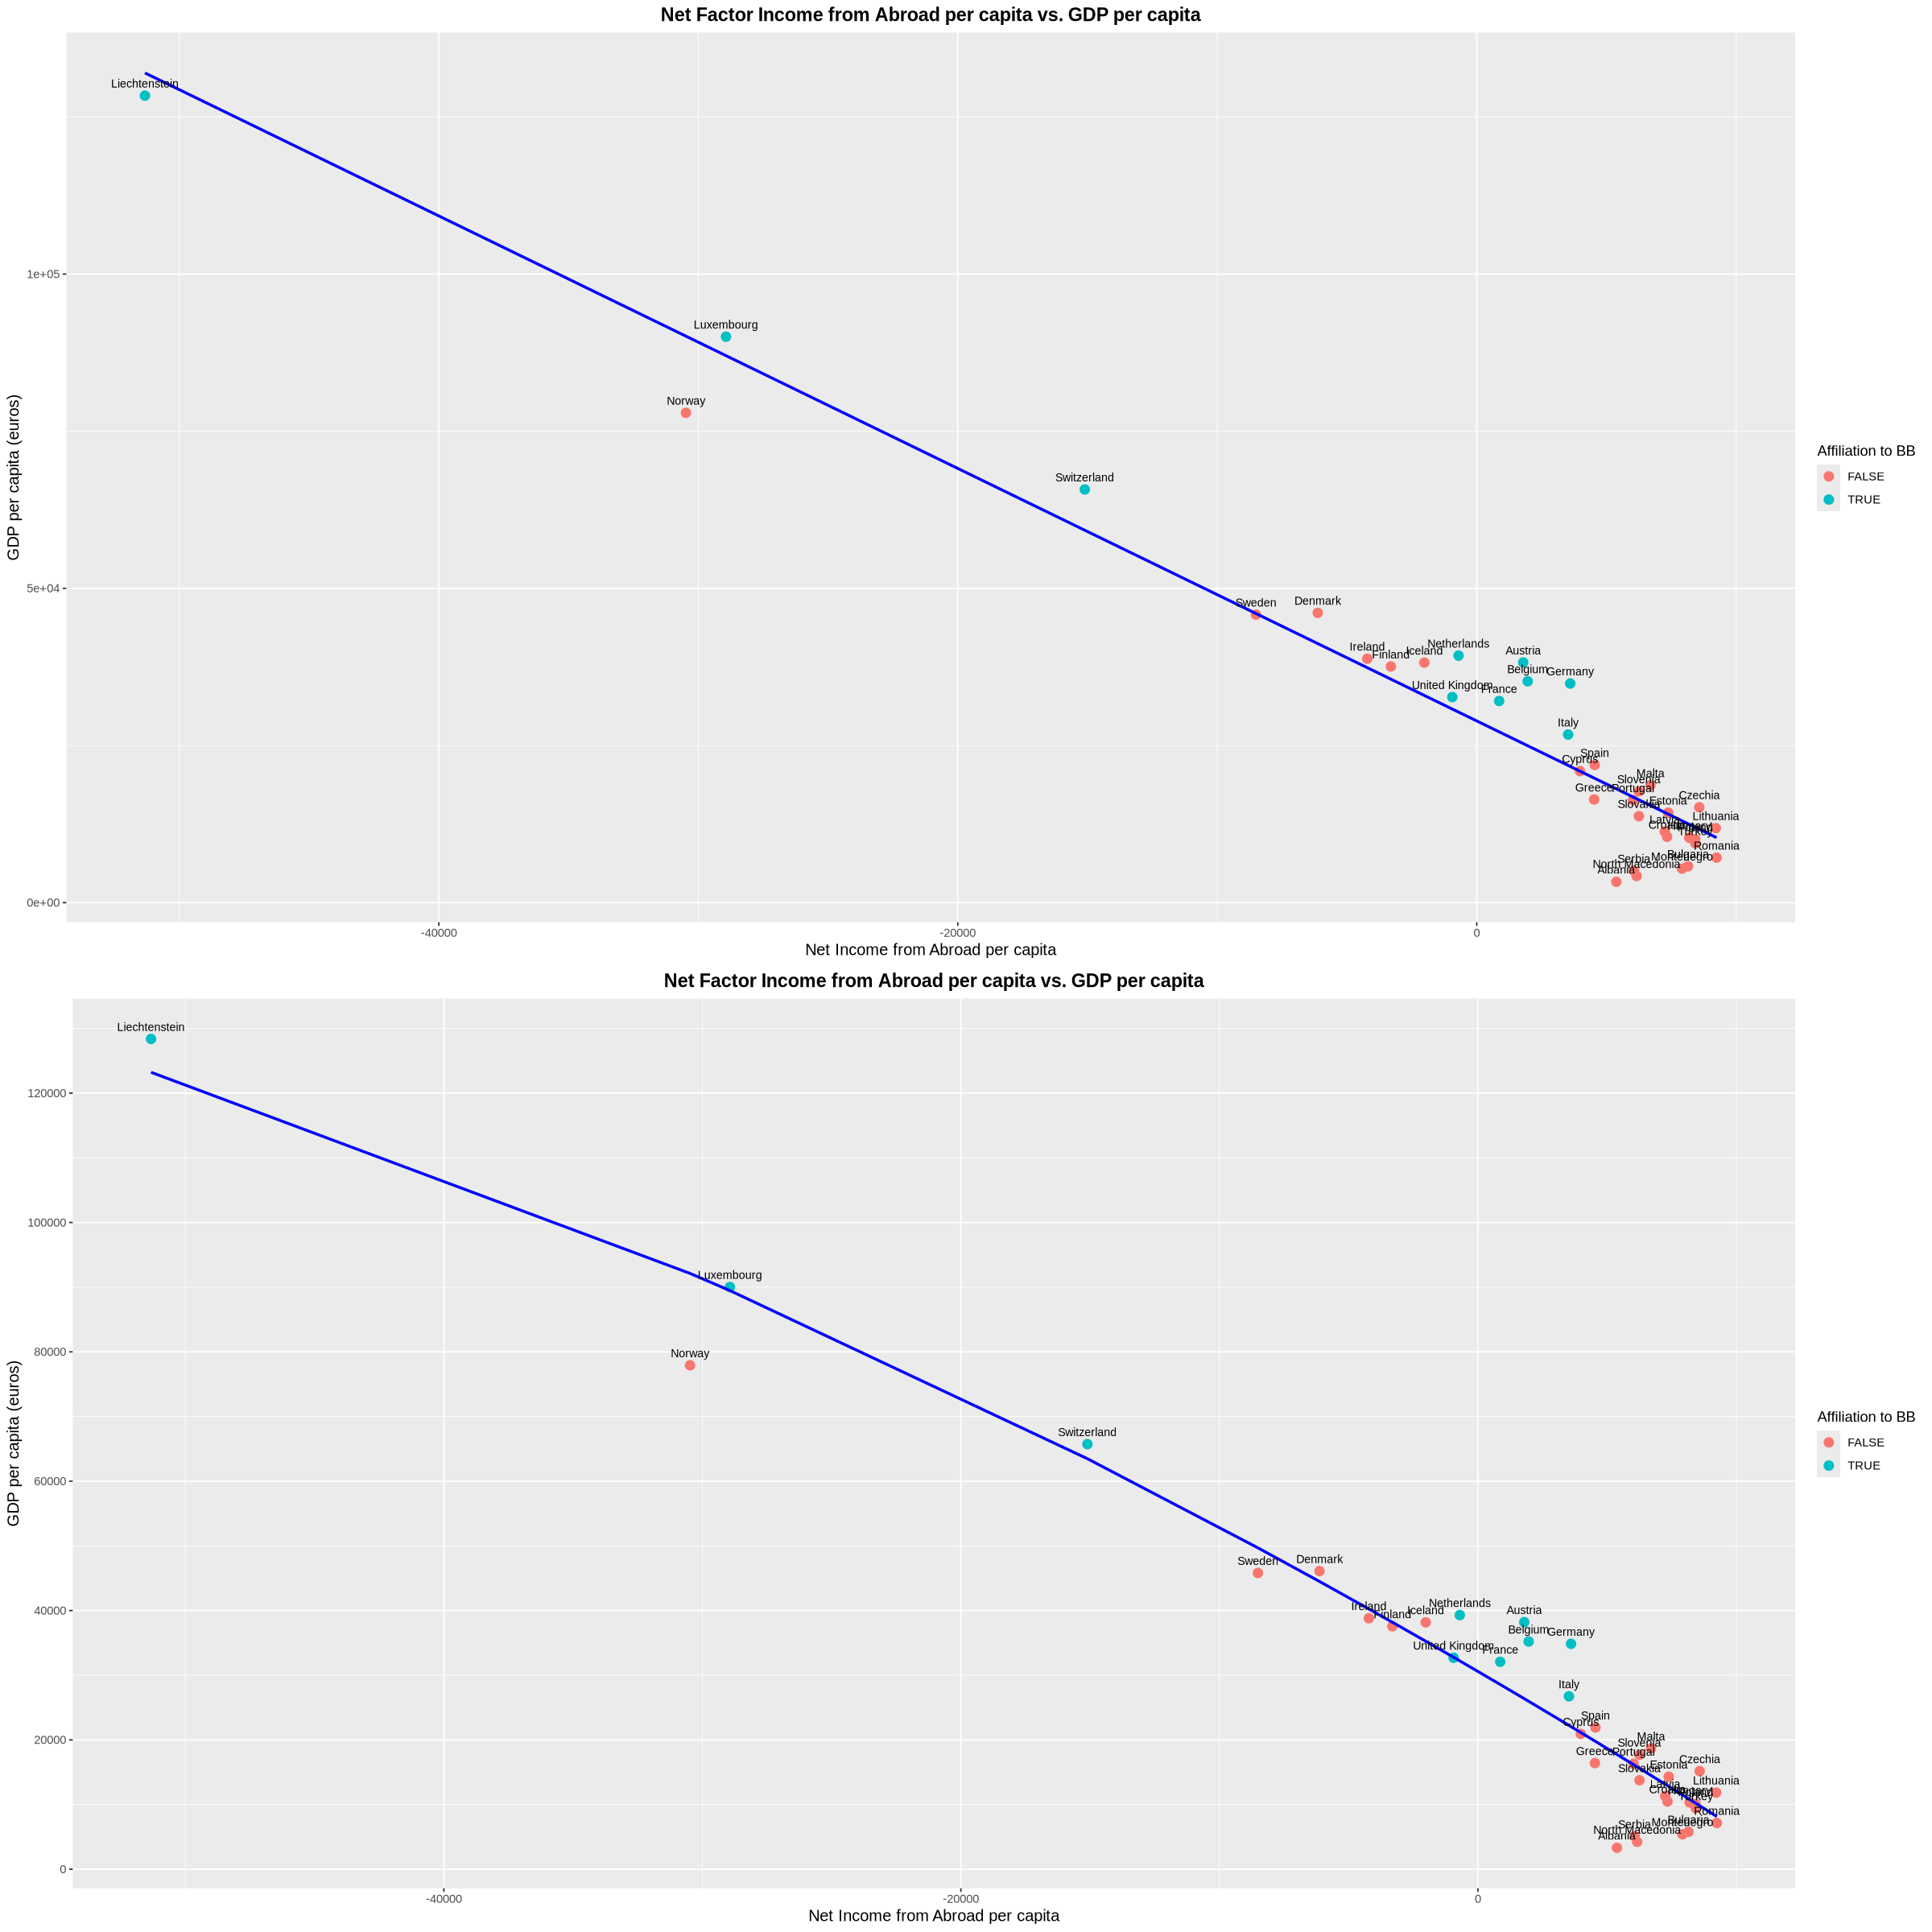

In [312]:
# set up plot size
options(repr.plot.width = 20, repr.plot.height=20)
plot_grid(nfiapc_lin_plot, nfiapc_poly_plot, nrow=2)

While the adjusted R-squared score didn't improve much, we see that data are distributed slightly non-linearly. We will leave the polynomial of this feature in a baseline model.

### Baseline Model

Let's try model with polynomial features:

In [316]:
model <- lm(GDPpc ~ poly(LE, 2) + EI + poly(NFIApc, 2) + BB_entry, data = data)
summary(model)


Call:
lm(formula = GDPpc ~ poly(LE, 2) + EI + poly(NFIApc, 2) + BB_entry, 
    data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-9204.3 -1564.0    89.6  2276.1  5689.4 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)        -10460       8375  -1.249  0.22134    
poly(LE, 2)1        17207       5395   3.190  0.00333 ** 
poly(LE, 2)2         3785       3850   0.983  0.33337    
EI                  43528       9852   4.418  0.00012 ***
poly(NFIApc, 2)1  -131100       4815 -27.228  < 2e-16 ***
poly(NFIApc, 2)2     5032       4696   1.072  0.29243    
BB_entryTRUE         8020       1623   4.942 2.74e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3676 on 30 degrees of freedom
Multiple R-squared:  0.9839,	Adjusted R-squared:  0.9807 
F-statistic: 306.1 on 6 and 30 DF,  p-value: < 2.2e-16


Adjusted R-squared score didn't improved at all, though the Multiple R-squared imrpoved very insignificantly. The model has same performance and contains statistically insignificant features.

As our baseline model we will then use the first simple model 

## Outliers

Exploration of data points that are:
- outliers - prediction values don't follow the main trend.
- leverages - data points that may follow the main trend, but they lie far away from the main clusters of data.
- both outliers and leverages.

### Outliers in Regressors Data

Our task is to explore outliers in the dataset. We will use boxplots and violin plots to get some insights:

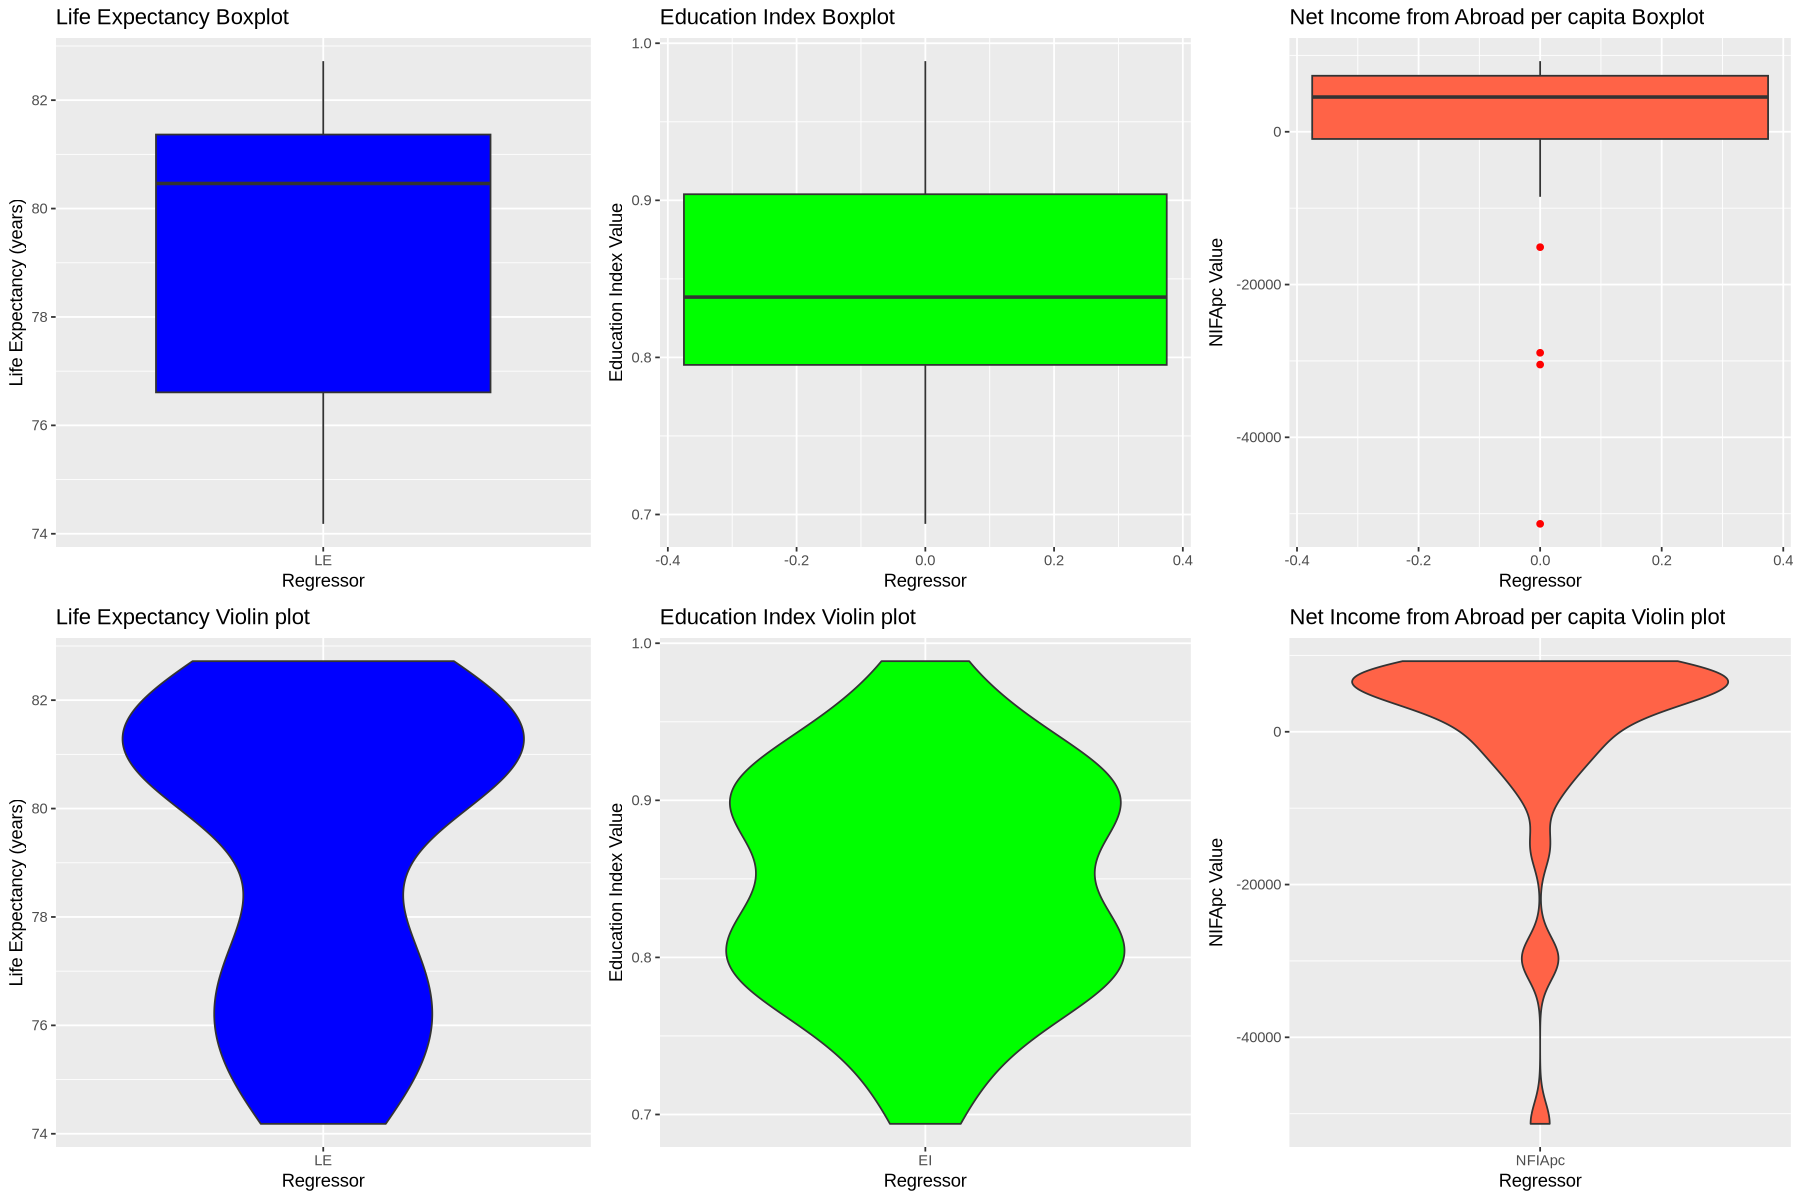

In [138]:
# set up plot size
options(repr.plot.width = 15, repr.plot.height=10)

# Create individual ggplots for each regressor

boxplot_LE <- ggplot(data, aes(x="LE", y=LE)) + 
    geom_boxplot(fill="blue", outlier.color="red") +
    labs(title="Life Expectancy Boxplot", x="Regressor", y="Life Expectancy (years)")
violin_LE <- ggplot(data, aes(x="LE", y=LE))+
    geom_violin(fill= "blue") +
    labs(title="Life Expectancy Violin plot", x="Regressor", y="Life Expectancy (years)")

boxplot_EI <- ggplot(data, aes(y=EI)) + 
    geom_boxplot(fill="green", outlier.color="red") +
    labs(title="Education Index Boxplot", x="Regressor", y="Education Index Value")
violin_EI <- ggplot(data, aes(x="EI", y=EI)) +
    geom_violin(fill= "green") + 
    labs(title="Education Index Violin plot", x="Regressor", y="Education Index Value")

boxplot_NFIApc <- ggplot(data, aes(y=NFIApc)) + 
    geom_boxplot(fill="tomato", outlier.color="red") +
    labs(title="Net Income from Abroad per capita Boxplot", x="Regressor", y="NIFApc Value")
violin_NFIApc <- ggplot(data, aes(x="NFIApc", y=NFIApc)) +
    geom_violin(fill= "tomato") +
    labs(title="Net Income from Abroad per capita Violin plot", x="Regressor", y="NIFApc Value")

# Arrange the plots in a grid
plot_grid(boxplot_LE, boxplot_EI, boxplot_NFIApc,
             violin_LE, violin_EI, violin_NFIApc,
             nrow = 2, ncol = 3)
             

**Net Income from Abroad per capita** has some outliers from the regressor's main distribution. 

Looking at the scatter plot **Net Income from Abroad per capita vs. GDP per capita** we observe, that those data points follow the the trend and the regression curve can be layed effectively through those data points and the main trend. Then we cannot consider them as outliers, but as leverages, because their `x` values are far from the main cluster of points. In this case those data points are not problematic.

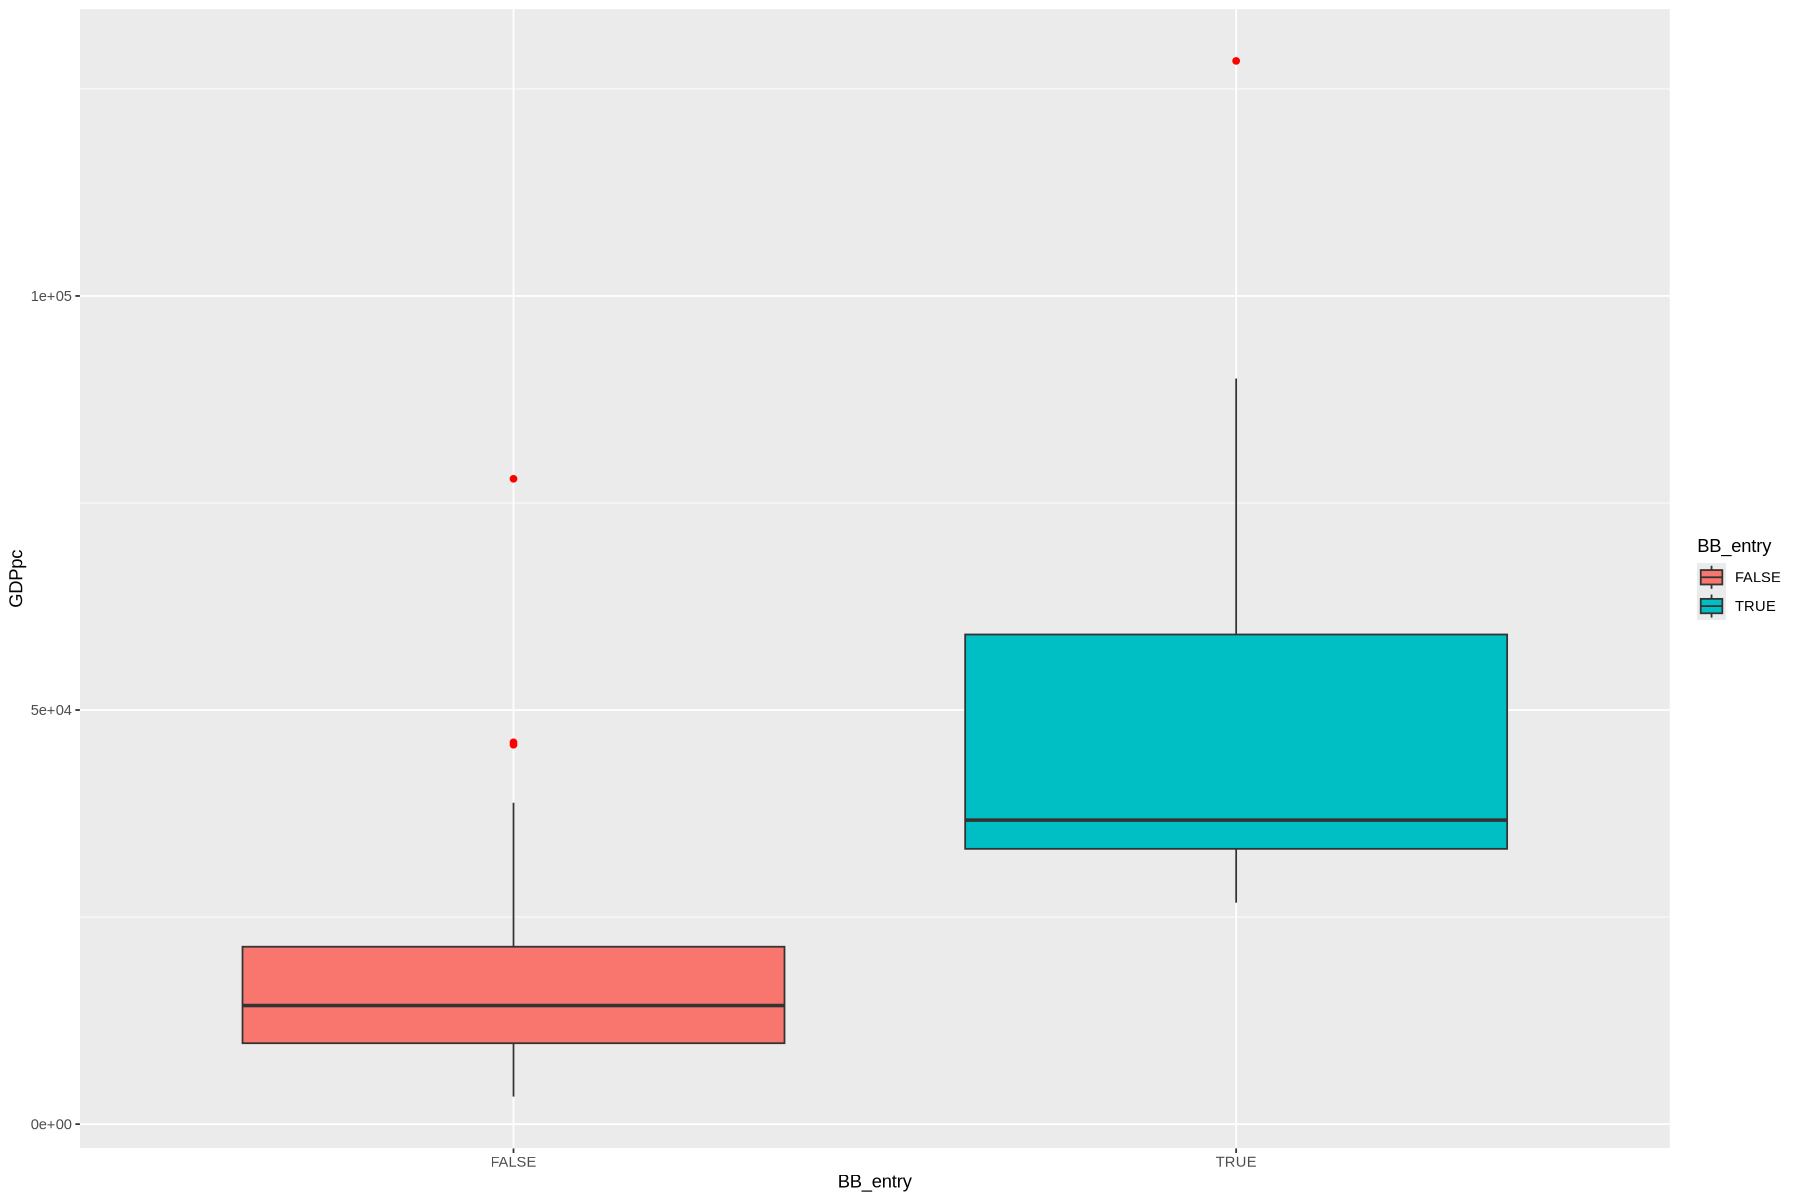

In [140]:
ggplot(data, aes(x=BB_entry, y=GDPpc, fill=BB_entry)) +
  geom_boxplot(outlier.color='red')

On the plot we observe, that among the non-BB countries there are 3 outliers - Norway, Denmark and Sweden. We can observe that on the **Ranking by countries by GDPpc level** plot presented earlier. In this case we know that those are outliers, because their prediction values lie far from the main group.

Observing other scatterplots - **Life Expectancy vs. GDP per capita** and **Education Index vs. GDP per capita** we see some of the most influential outliers:
 - Lichtensteing
 - Luxemburg
 - Norway

Visually we can consider them as influential. But other regressors have their influence on the prediction too and we need to look at it as whole.

### Outliers in Residuals

We will assess which outliers we are interested to remove from the dataset using the Cook's distance metric: 

$$
D_i = \frac{\sum_{j=1}^n (\hat{Y}_j - \hat{Y}_{j(i)})^2}{k \frac{S_e}{n-k}},
$$

where $k$ is number of regressors, $S_e$ is residual sum of squares, $\hat{Y}_j$ is prediction of $Y_j$ and $\hat{Y}_{j(i)}$ prediction of $Y_j$ with removing the $i$-th data point.

In other words, we remove a data point and look the change. The change is the distance for the i-th data point. The higher the distance is, the more influential the point is.

To determine the cutoff value, there are different methods, like median point of F-distribution and other formula - we will use the 4 / n formula, where n is the number of observations.

In [ ]:
# 
options(repr.plot.width=15, repr.plot.height=10)

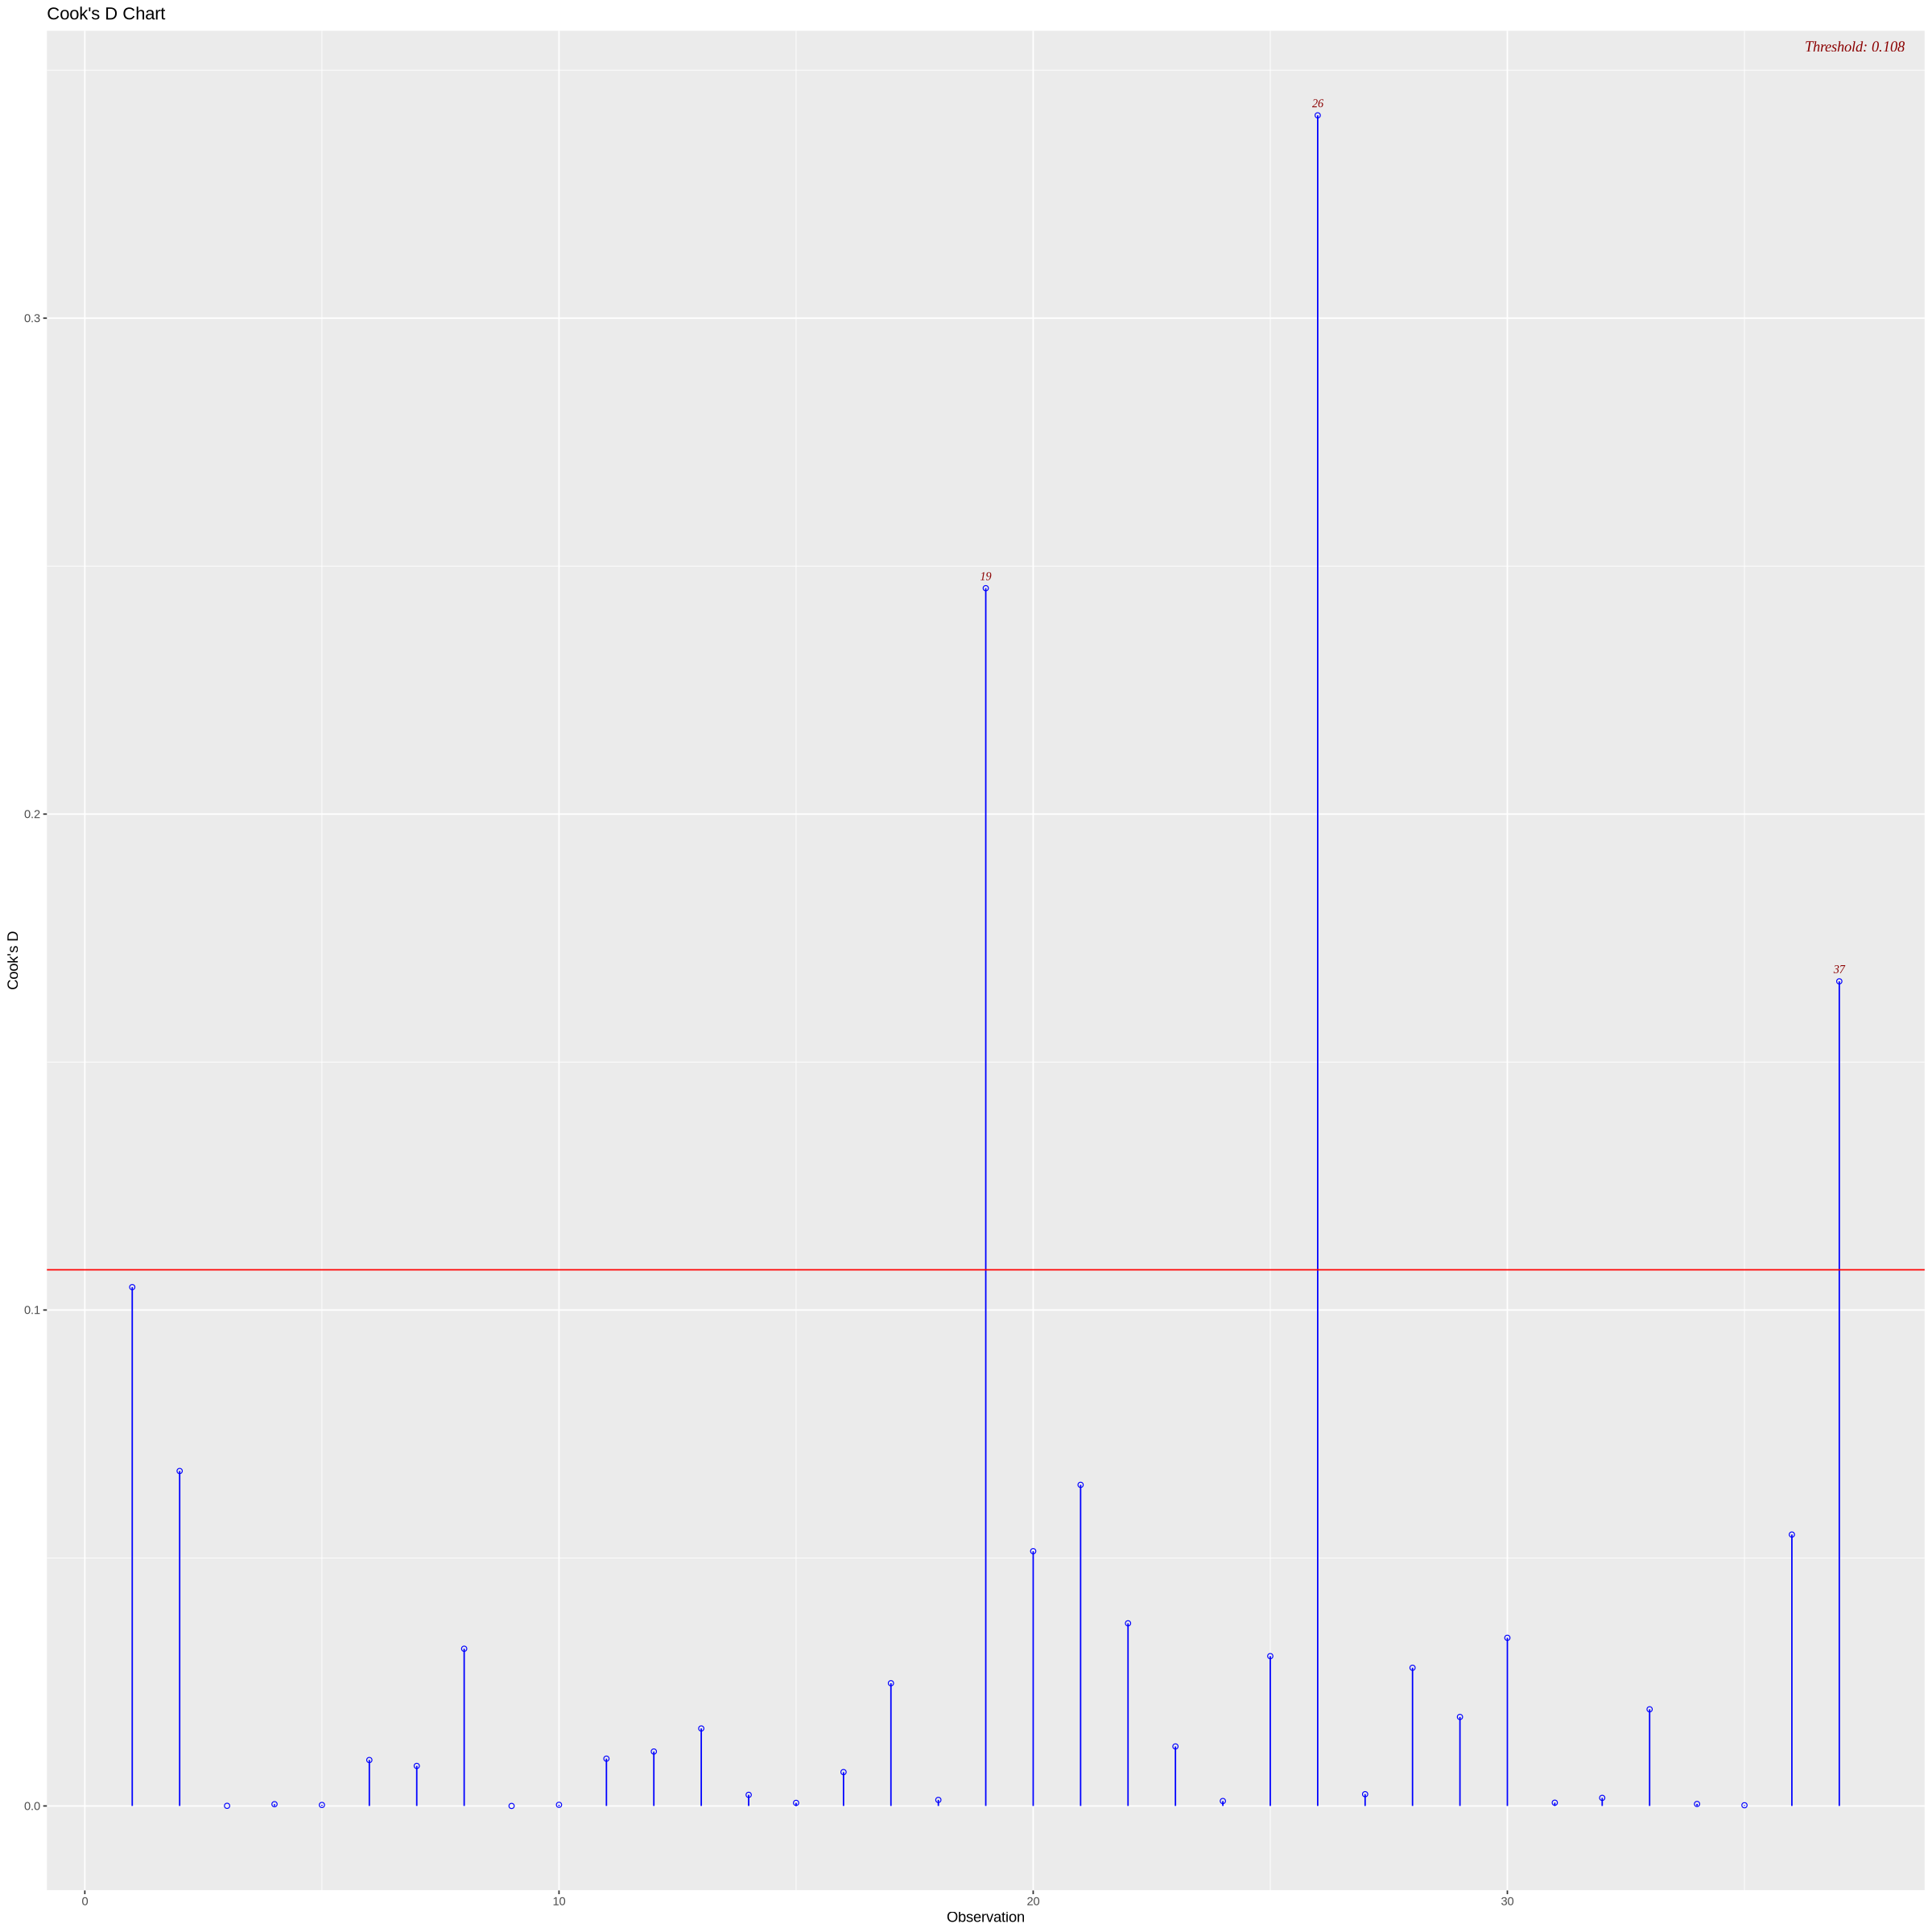

In [319]:
ols_plot_cooksd_chart(model)

Datapoints 19, 26, 37 may be influential:



In [320]:
data[c(19, 26, 37),]

,country,GDPpc,LE,EI,NFIApc,BB_entry
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
19,Liechtenstein,128380,82.425,0.8142102,-51327.3400,TRUE
26,Norway,77920,81.667,0.9130506,-30476.4766,FALSE
37,United Kingdom,32700,80.929,0.9185661,-941.5821,TRUE


The liechtensteing is both visually and metrically influential outlier - we will remove it and check again the results.

In [321]:
# remove observation 19
data_filtered <- data[-19,]
# reset indexes
row.names(data_filtered) <- NULL

In [322]:
model <- lm(GDPpc ~ LE + EI + NFIApc + BB_entry, data = data_filtered)
summary(model)


Call:
lm(formula = GDPpc ~ LE + EI + NFIApc + BB_entry, data = data_filtered)

Residuals:
     Min       1Q   Median       3Q      Max 
-10264.3  -1625.6    -26.4   2506.1   5352.1 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -7.977e+04  2.333e+04  -3.418 0.001782 ** 
LE            9.076e+02  2.944e+02   3.083 0.004278 ** 
EI            4.053e+04  9.286e+03   4.364 0.000131 ***
NFIApc       -1.690e+00  8.076e-02 -20.930  < 2e-16 ***
BB_entryTRUE  8.092e+03  1.619e+03   4.998 2.16e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3680 on 31 degrees of freedom
Multiple R-squared:  0.972,	Adjusted R-squared:  0.9684 
F-statistic: 268.9 on 4 and 31 DF,  p-value: < 2.2e-16


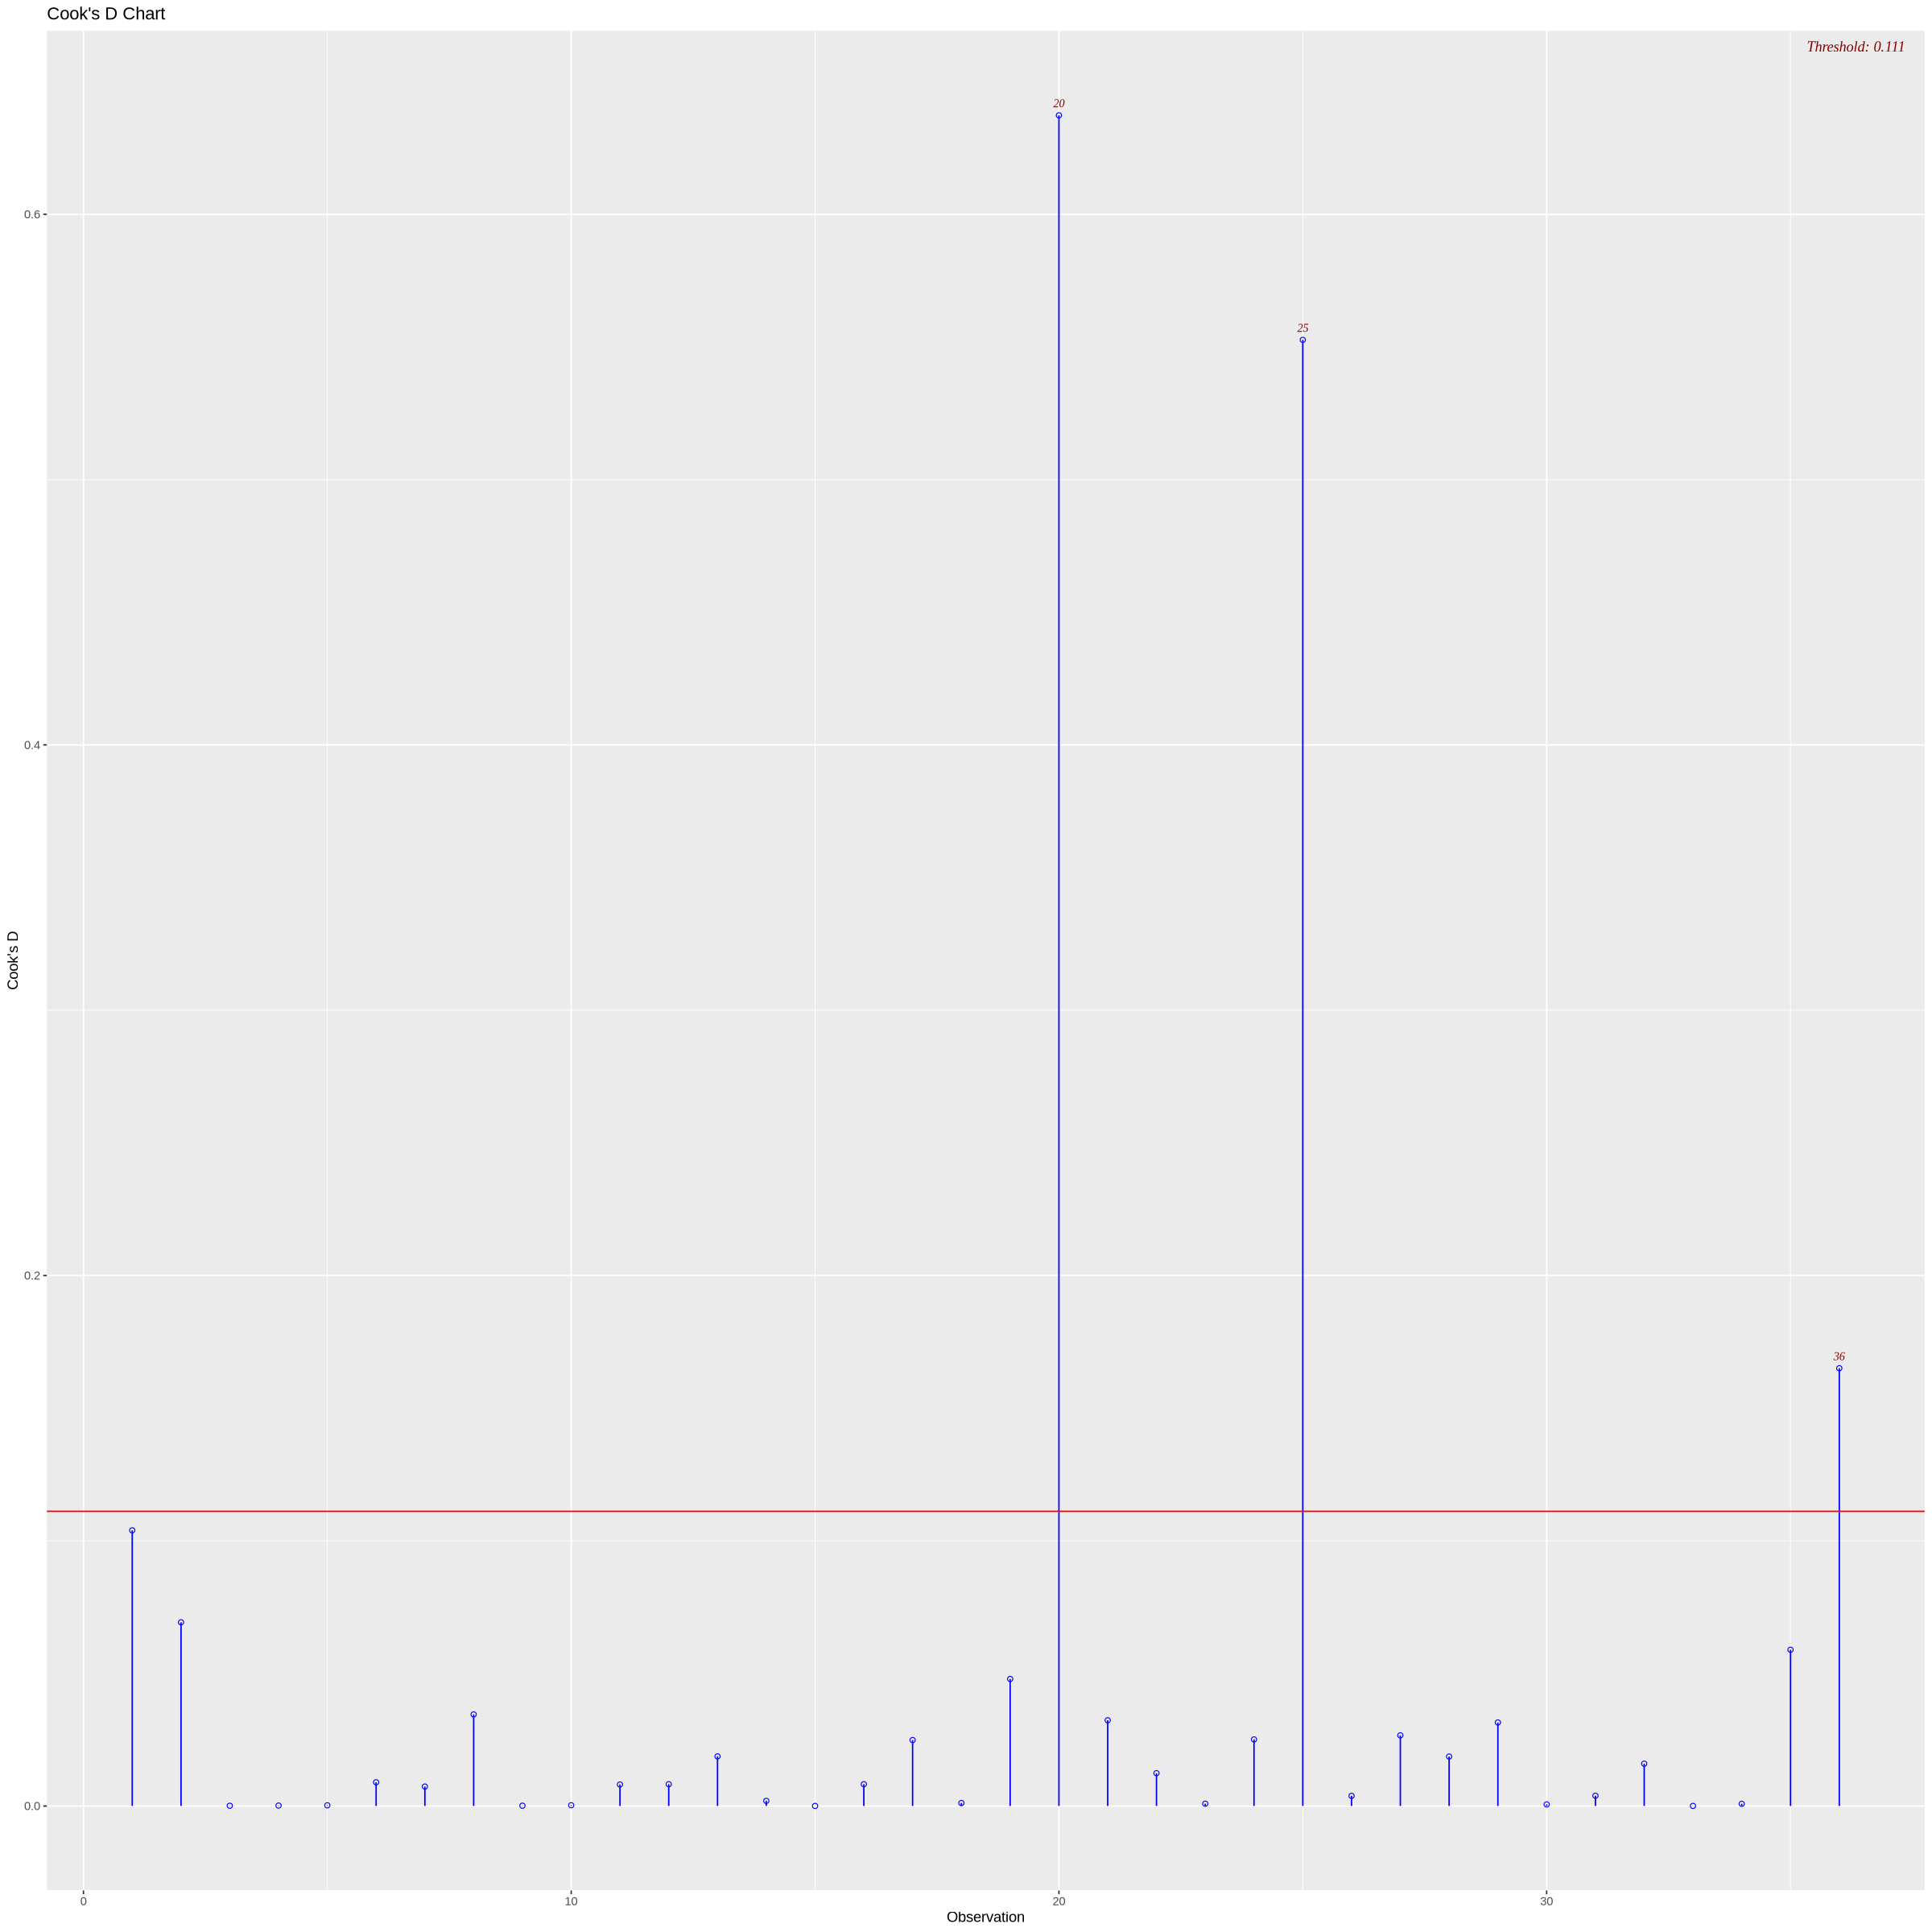

In [323]:
ols_plot_cooksd_chart(model)

In [324]:
data_filtered[c(20, 25, 36),]

,country,GDPpc,LE,EI,NFIApc,BB_entry
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
20,Luxembourg,90030,81.366,0.8297409,-28933.9761,TRUE
25,Norway,77920,81.667,0.9130506,-30476.4766,FALSE
36,United Kingdom,32700,80.929,0.9185661,-941.5821,TRUE


The next outlier is the Luxemburg, which makes sense looking again at the scatterplots. We will remove this data point too.

In [325]:
# remove observation 19
data_filtered <- data_filtered[-20,]
# reset indexes
row.names(data_filtered) <- NULL

In [326]:
model <- lm(GDPpc ~ LE + EI + NFIApc + BB_entry, data = data_filtered)
summary(model)


Call:
lm(formula = GDPpc ~ LE + EI + NFIApc + BB_entry, data = data_filtered)

Residuals:
     Min       1Q   Median       3Q      Max 
-10113.6  -1688.8     55.3   2316.7   5984.1 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -9.827e+04  2.396e+04  -4.102 0.000288 ***
LE            1.079e+03  2.923e+02   3.693 0.000880 ***
EI            4.600e+04  9.228e+03   4.985 2.43e-05 ***
NFIApc       -1.567e+00  9.750e-02 -16.069 2.77e-16 ***
BB_entryTRUE  7.216e+03  1.598e+03   4.515 9.13e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3502 on 30 degrees of freedom
Multiple R-squared:  0.9658,	Adjusted R-squared:  0.9612 
F-statistic: 211.5 on 4 and 30 DF,  p-value: < 2.2e-16


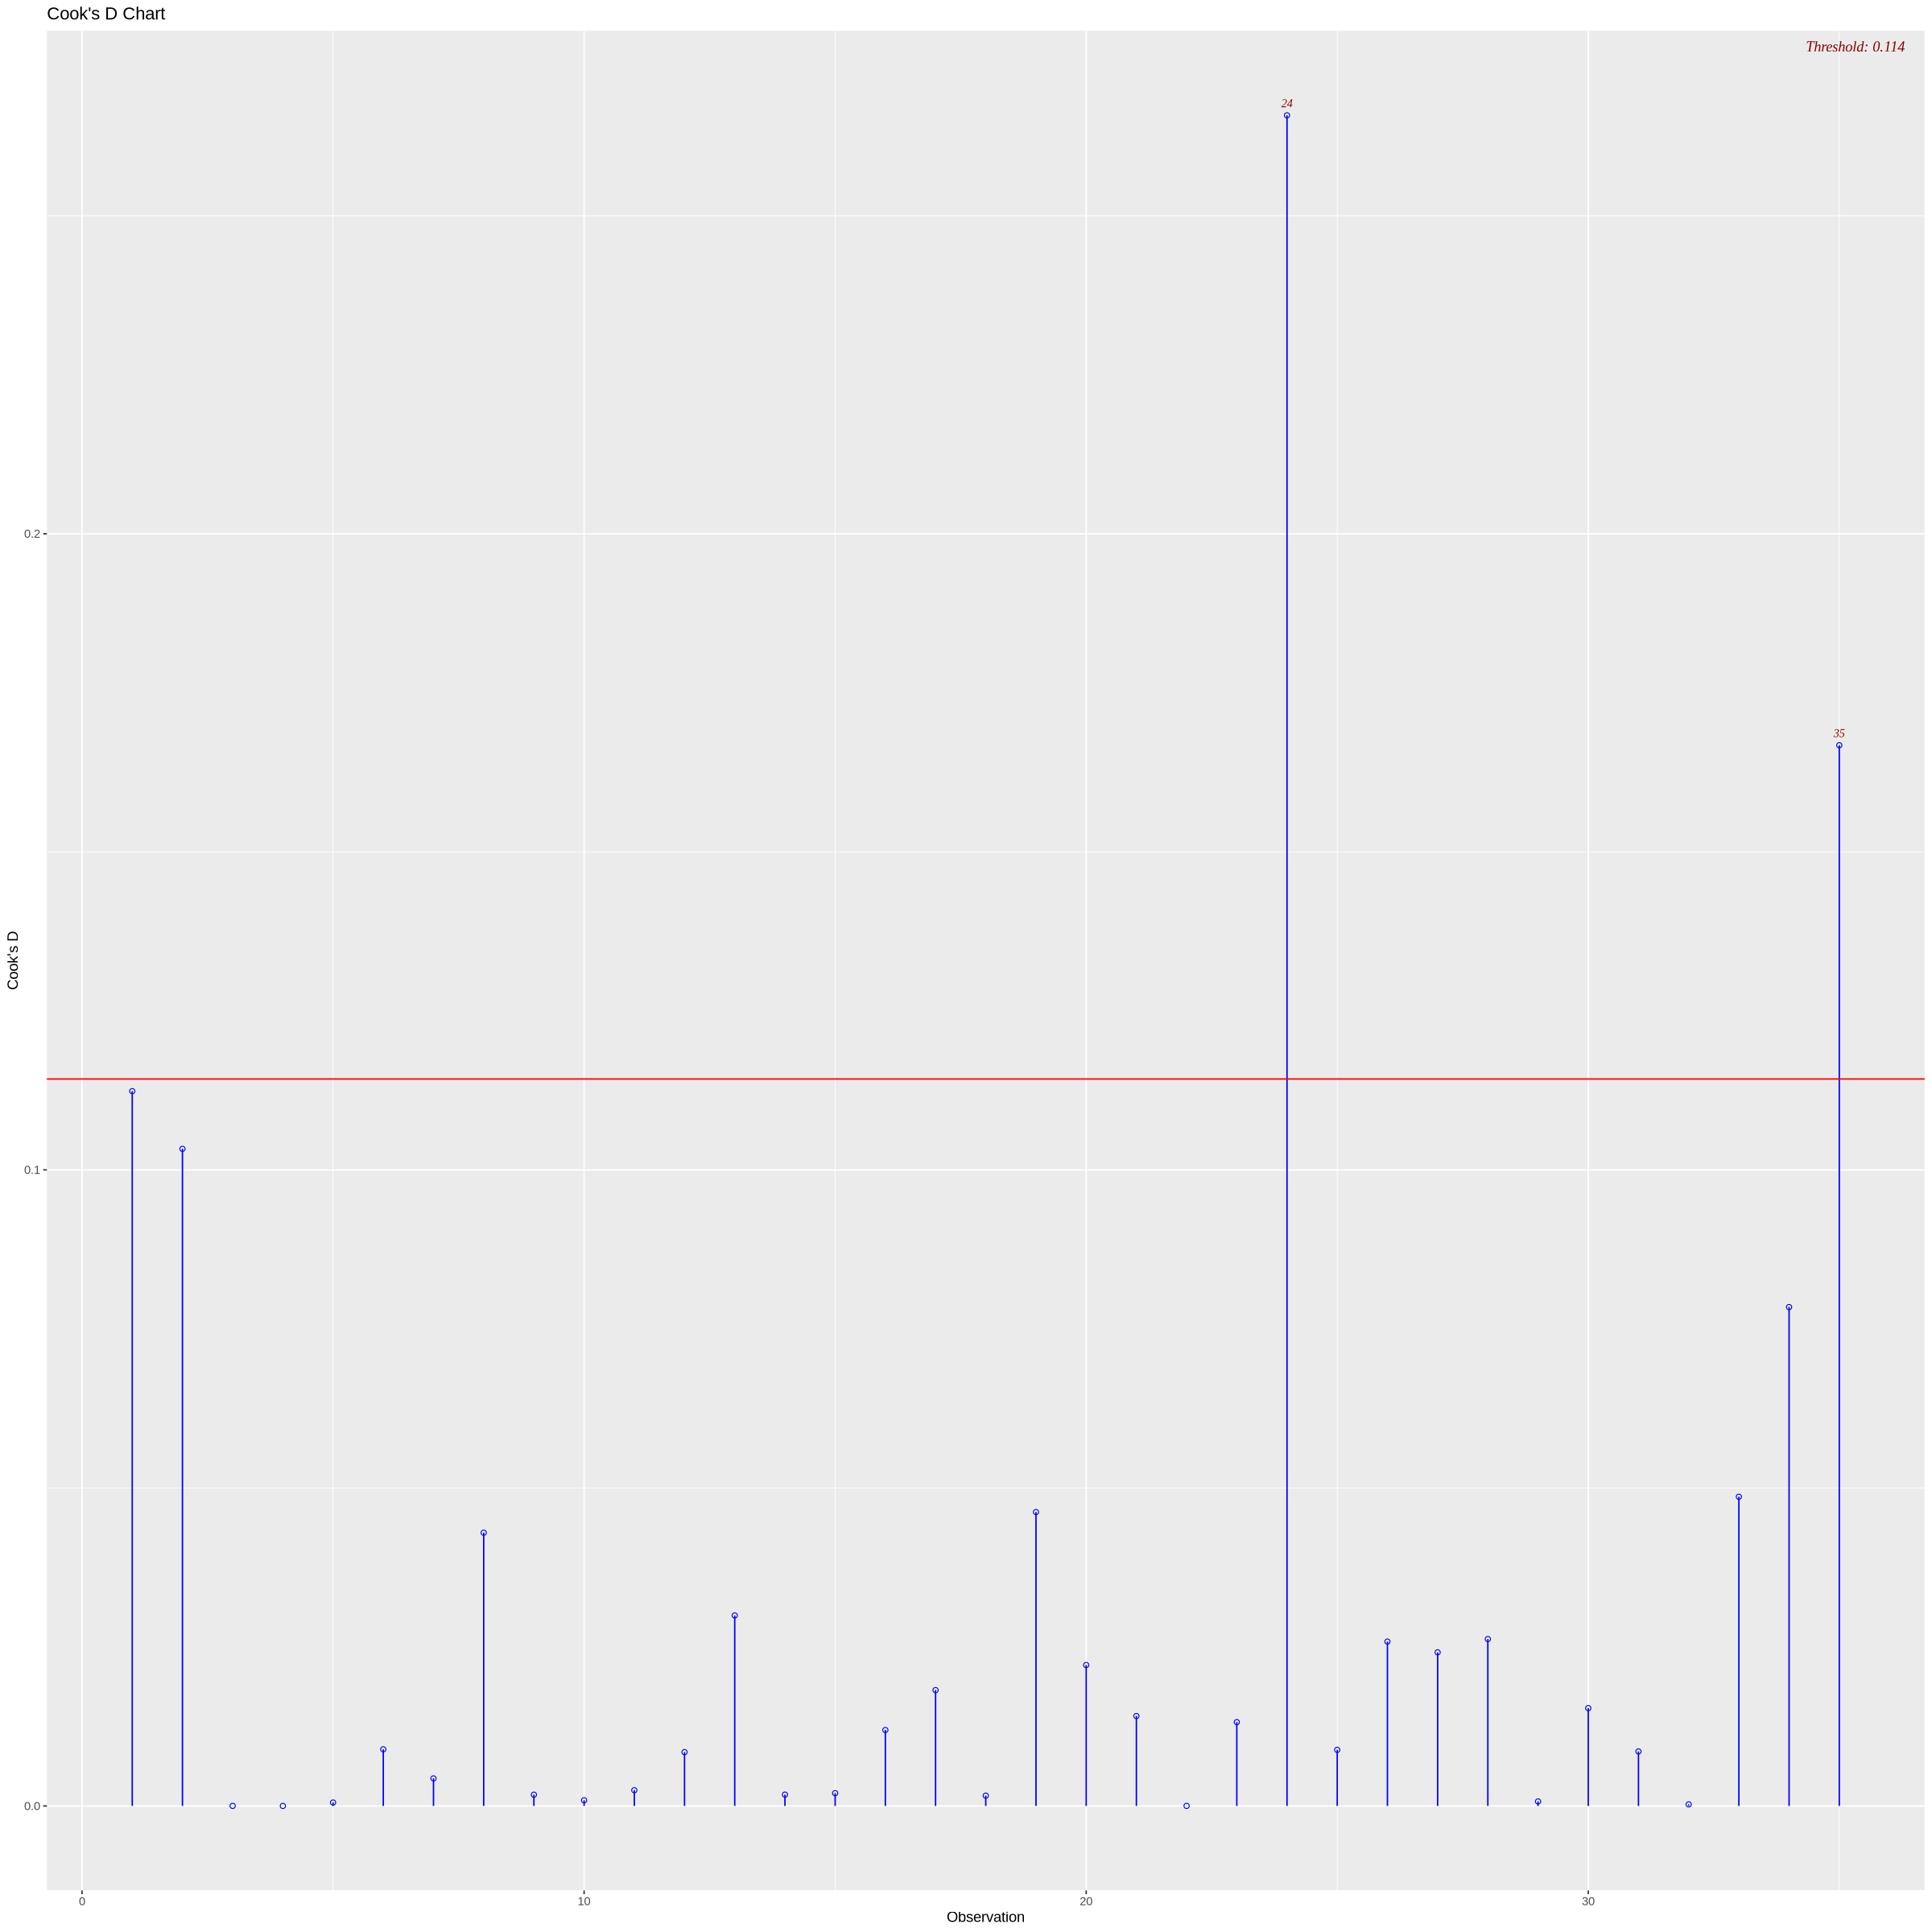

In [327]:
ols_plot_cooksd_chart(model)

The last data point to remove is Norway. We remember that on the boxplots plot it was quite an outlier there. Therefore it will be removed:

In [328]:
# remove observation 19
data_filtered <- data_filtered[-24,]
# reset indexes
row.names(data_filtered) <- NULL

In [329]:
model <- lm(GDPpc ~ LE + EI + NFIApc + BB_entry, data = data_filtered)
summary(model)


Call:
lm(formula = GDPpc ~ LE + EI + NFIApc + BB_entry, data = data_filtered)

Residuals:
   Min     1Q Median     3Q    Max 
-10242  -1392    151   2162   6130 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -8.937e+04  2.636e+04  -3.391 0.002029 ** 
LE            9.938e+02  3.114e+02   3.192 0.003387 ** 
EI            4.404e+04  9.572e+03   4.601 7.69e-05 ***
NFIApc       -1.670e+00  1.584e-01 -10.544 1.96e-11 ***
BB_entryTRUE  6.942e+03  1.640e+03   4.233 0.000212 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3520 on 29 degrees of freedom
Multiple R-squared:  0.9536,	Adjusted R-squared:  0.9472 
F-statistic:   149 on 4 and 29 DF,  p-value: < 2.2e-16


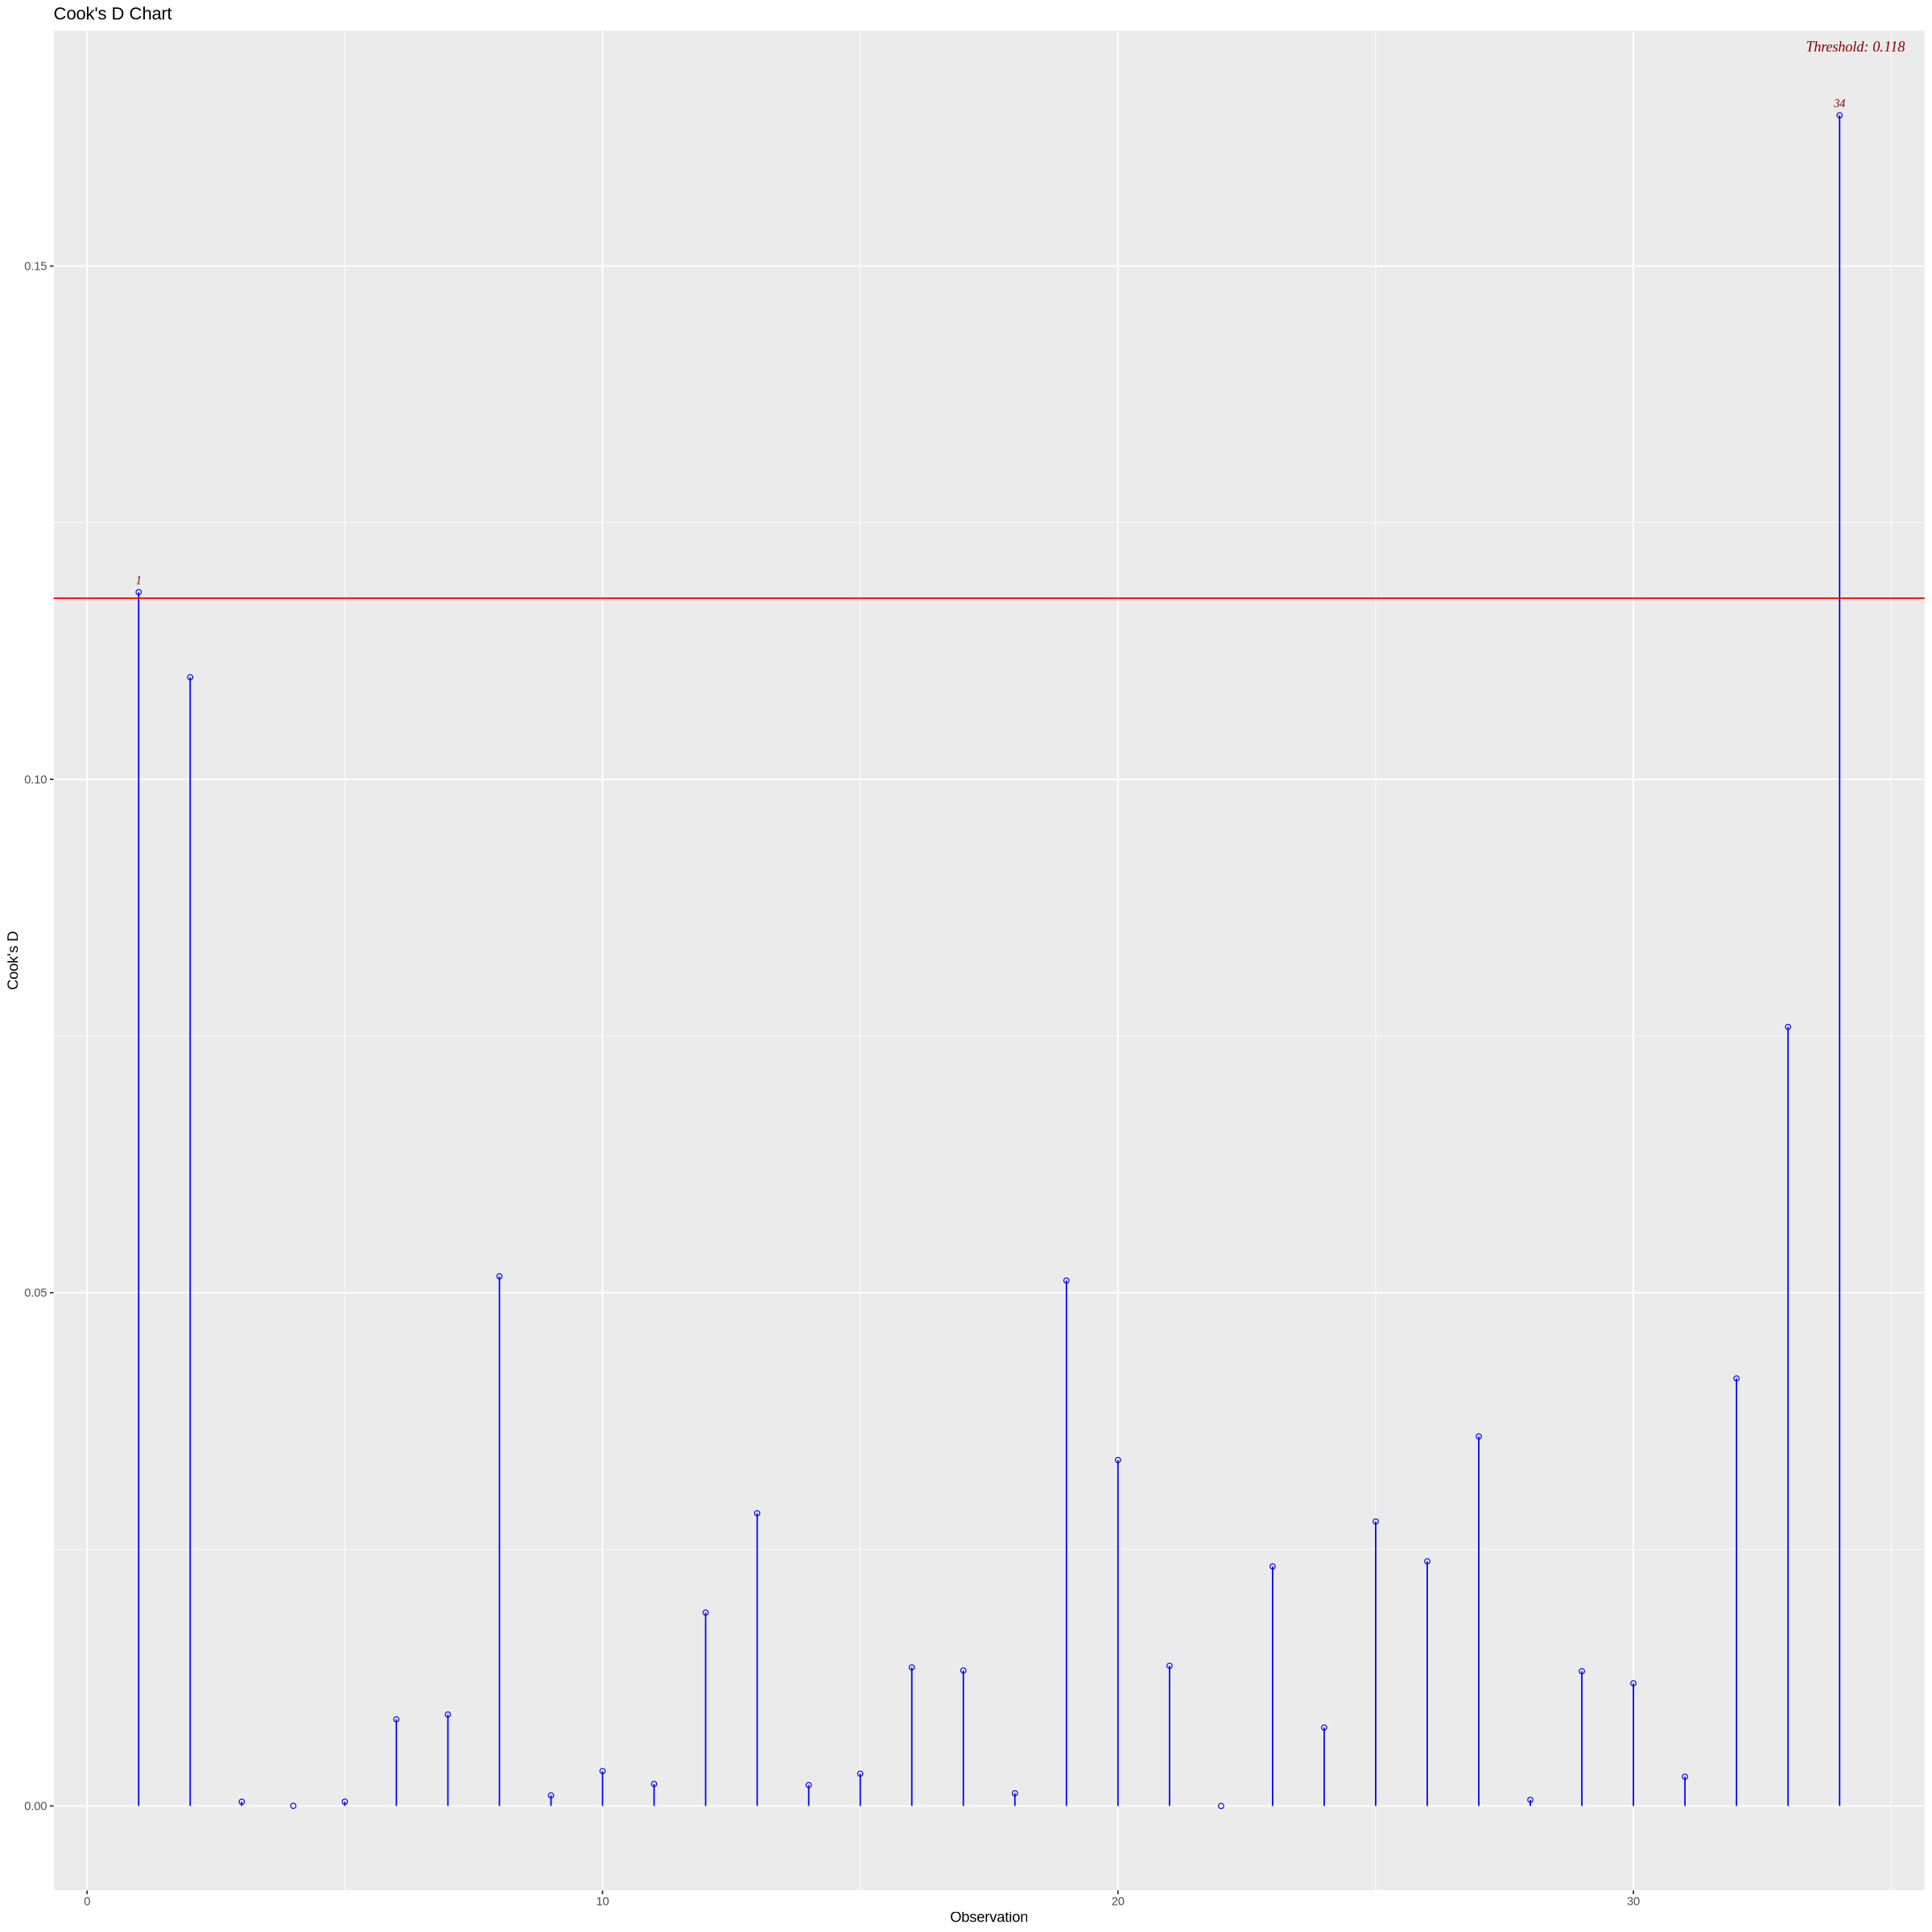

In [330]:
ols_plot_cooksd_chart(model)

In [173]:
data_filtered[c(1,34),]

,country,GDPpc,LE,EI,NFIApc,BB_entry
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
1,Albania,3320,78.123,0.7781896,5376.9032,FALSE
34,United Kingdom,32700,80.929,0.9185661,-941.5821,TRUE


It is very interesting how the Albania and United Kingdom can be considered an outliers. Visually we would not say that they are outliers. We have now only 34 datapoints, which is pretty small amount - we will leave it all as it is now.

## Multicollinearity

Now we need to expect multicollinearity in our model. We have 3 numerical and 1 categorical binary feature.

First information we have - we did a correlation marix. From that we can see that there is some linear positive and negative correlations between some of the regressors. But let's see some concrete values:


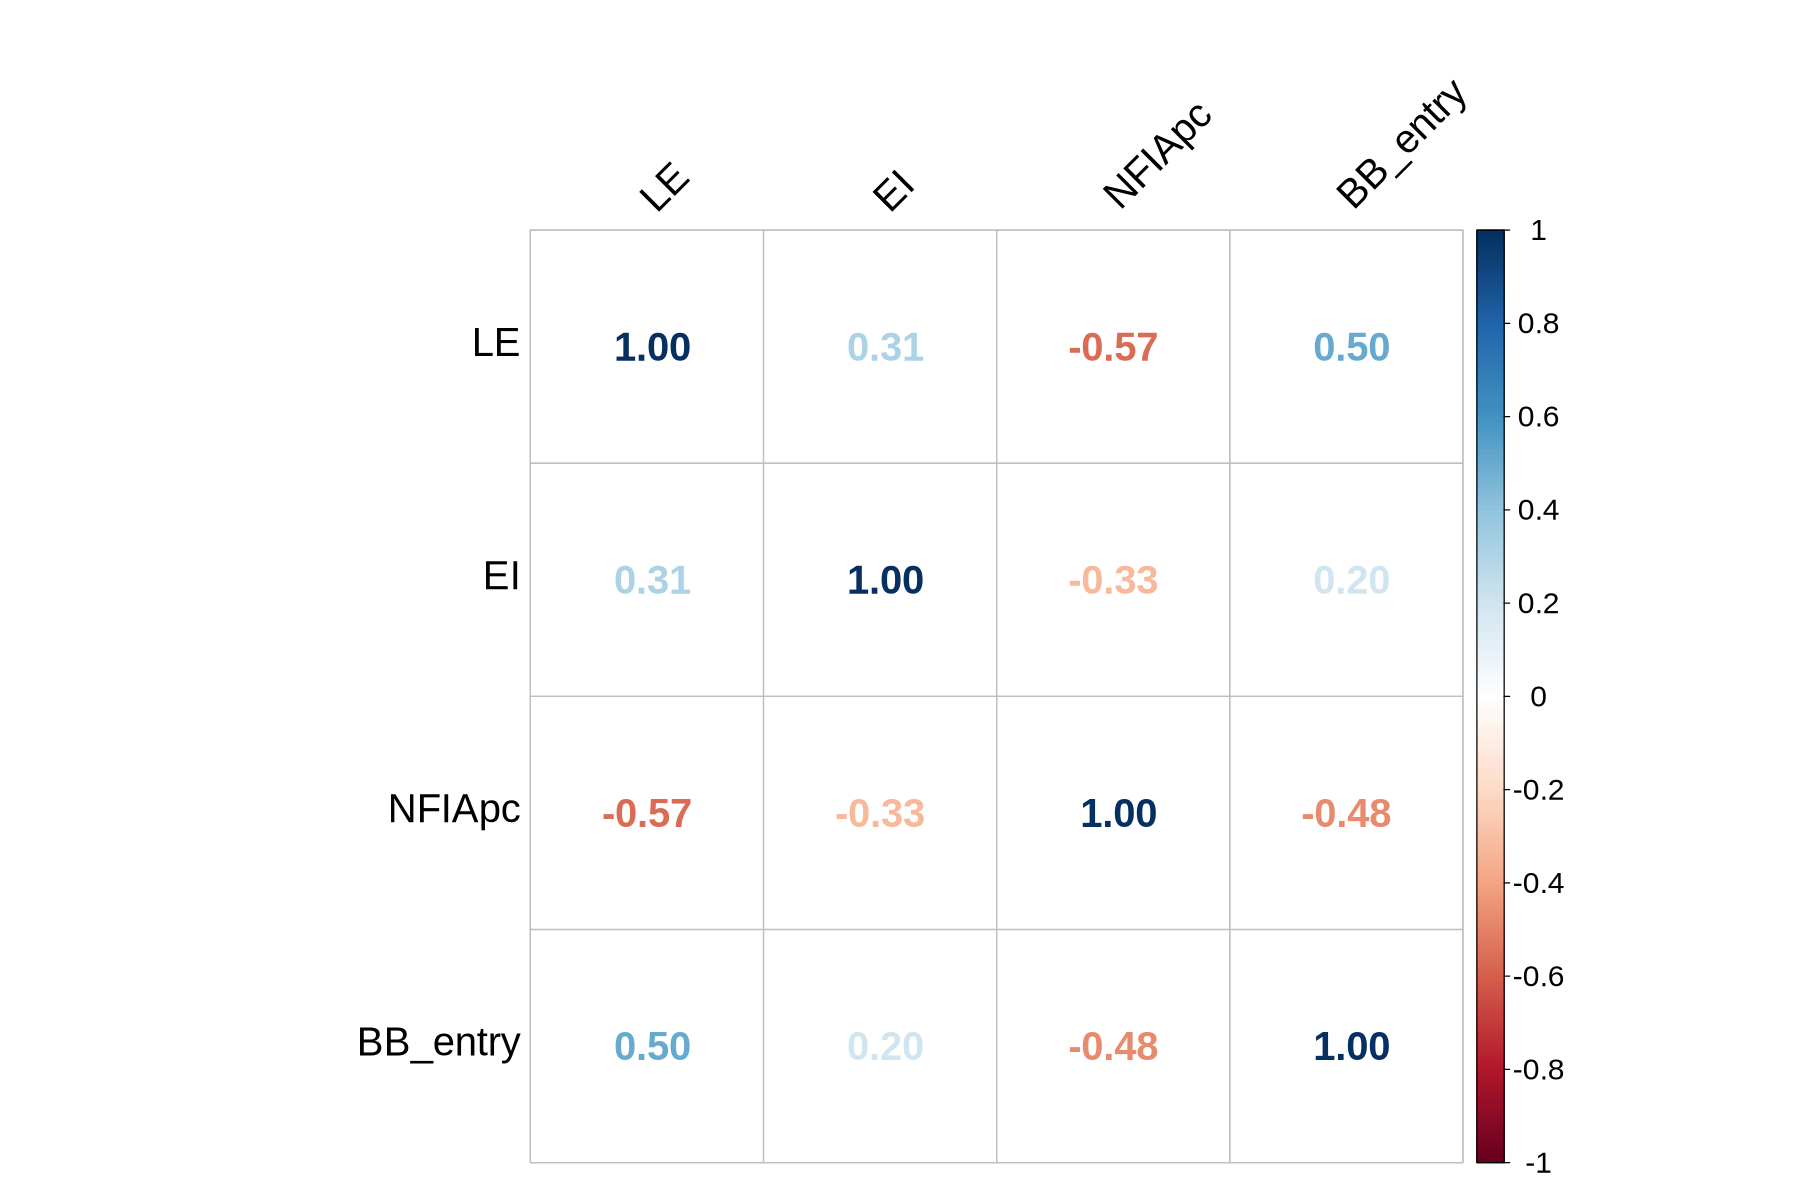

In [45]:
# TODO - check for noramlity for the pearson correlation
# TODO - use Spearman correlation too, for the spearman check monotonicity of the data
features <- data_filtered2[,-(1:2)]
corrplot(cor(features),
         method='number',
         tl.col='black',
         tl.srt=45,
         tl.cex=2,
         cl.cex=1.5,
         number.cex=2)

So we see that there is some linear positive or strong correlation between some of the features, but nothing too significant, used labels provide some of the new information for prediction.

To test multicollinearity we will use the VIF method.
The VIF method expects linear relationship between predictors and target variable.
But as we saw it before on scatter plot, some of the relationships are no quite linear, but rathier quadratic. So we will test not only original features, but the transformed features too.

In [46]:
model <- lm(GDPpc ~ LE + I(LE^2) + EI + NFIApc +I (NFIApc^2) + BB_entry, data = data_filtered2)
vif_values <- vif(model)
print(vif_values)

         LE     I(LE^2)          EI      NFIApc I(NFIApc^2)    BB_entry 
6693.395522 6722.474994    1.419053    5.665107    3.636925    1.462711 


We see that transformed features and their originals has high VIF value. Let's try VIF only with original and only with transformed features:

In [47]:
model <- lm(GDPpc ~ LE + EI + NFIApc + BB_entry, data = data_filtered2)
vif_values <- vif(model)
print(vif_values)

      LE       EI   NFIApc BB_entry 
1.680608 1.151260 1.656432 1.440983 


There is some moderate correlation, but generally acceptable.

In [48]:
model <- lm(GDPpc ~ I(LE^2) + EI + I(NFIApc^2) + BB_entry, data = data_filtered2)
summary(model)
vif_values <- vif(model)
print(vif_values)


Call:
lm(formula = GDPpc ~ I(LE^2) + EI + I(NFIApc^2) + BB_entry, data = data_filtered2)

Residuals:
     Min       1Q   Median       3Q      Max 
-10948.2  -5091.0   -123.1   3610.3  13198.6 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -1.761e+05  2.040e+04  -8.632 1.25e-09 ***
I(LE^2)       1.964e+01  3.063e+00   6.410 4.46e-07 ***
EI            8.324e+04  1.614e+04   5.156 1.50e-05 ***
I(NFIApc^2)   7.177e-05  8.214e-06   8.738 9.59e-10 ***
BB_entryTRUE  8.549e+03  2.999e+03   2.851  0.00781 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6490 on 30 degrees of freedom
Multiple R-squared:  0.8963,	Adjusted R-squared:  0.8825 
F-statistic: 64.84 on 4 and 30 DF,  p-value: 2.481e-14


    I(LE^2)          EI I(NFIApc^2)    BB_entry 
   1.428125    1.117638    1.074758    1.427039 


In [49]:
model <- lm(GDPpc ~ poly(LE, 2) + EI + poly(NFIApc,2) + BB_entry, data = data_filtered2)
summary(model)
vif_values <- vif(model)
print(vif_values)


Call:
lm(formula = GDPpc ~ poly(LE, 2) + EI + poly(NFIApc, 2) + BB_entry, 
    data = data_filtered2)

Residuals:
    Min      1Q  Median      3Q     Max 
-8895.0 -1140.4  -174.9  1862.7  6818.2 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)        -18028       8150  -2.212 0.035282 *  
poly(LE, 2)1        19242       5422   3.549 0.001389 ** 
poly(LE, 2)2         4115       3522   1.169 0.252413    
EI                  47986       9610   4.993 2.83e-05 ***
poly(NFIApc, 2)1   -78280       4979 -15.722 2.00e-15 ***
poly(NFIApc, 2)2     7841       4651   1.686 0.102973    
BB_entryTRUE         6783       1604   4.229 0.000227 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3429 on 28 degrees of freedom
Multiple R-squared:  0.973,	Adjusted R-squared:  0.9672 
F-statistic: 168.1 on 6 and 28 DF,  p-value: < 2.2e-16


                    GVIF Df GVIF^(1/(2*Df))
poly(LE, 2)     2.601322  2        1.269985
EI              1.419053  1        1.191240
poly(NFIApc, 2) 3.087381  2        1.325554
BB_entry        1.462711  1        1.209426


Interesting results.. Let's see if we can use other methods for multicollinearity check.

The condition index can be used to check for multicollinearity between two features - let's create a function that will do that:

Also there is some interesting plots for outliers and leverages diagnostics, that may be very useful
https://cran.r-project.org/web/packages/olsrr/vignettes/regression_diagnostics.html

In [50]:
# TODO use the condition index

## Model Premises Tests

Before we will venture for final model detection, let's check premises of our current uber model, so we can continue with final model.

- heteroscedacity
- normality of residuals
- other assumptions

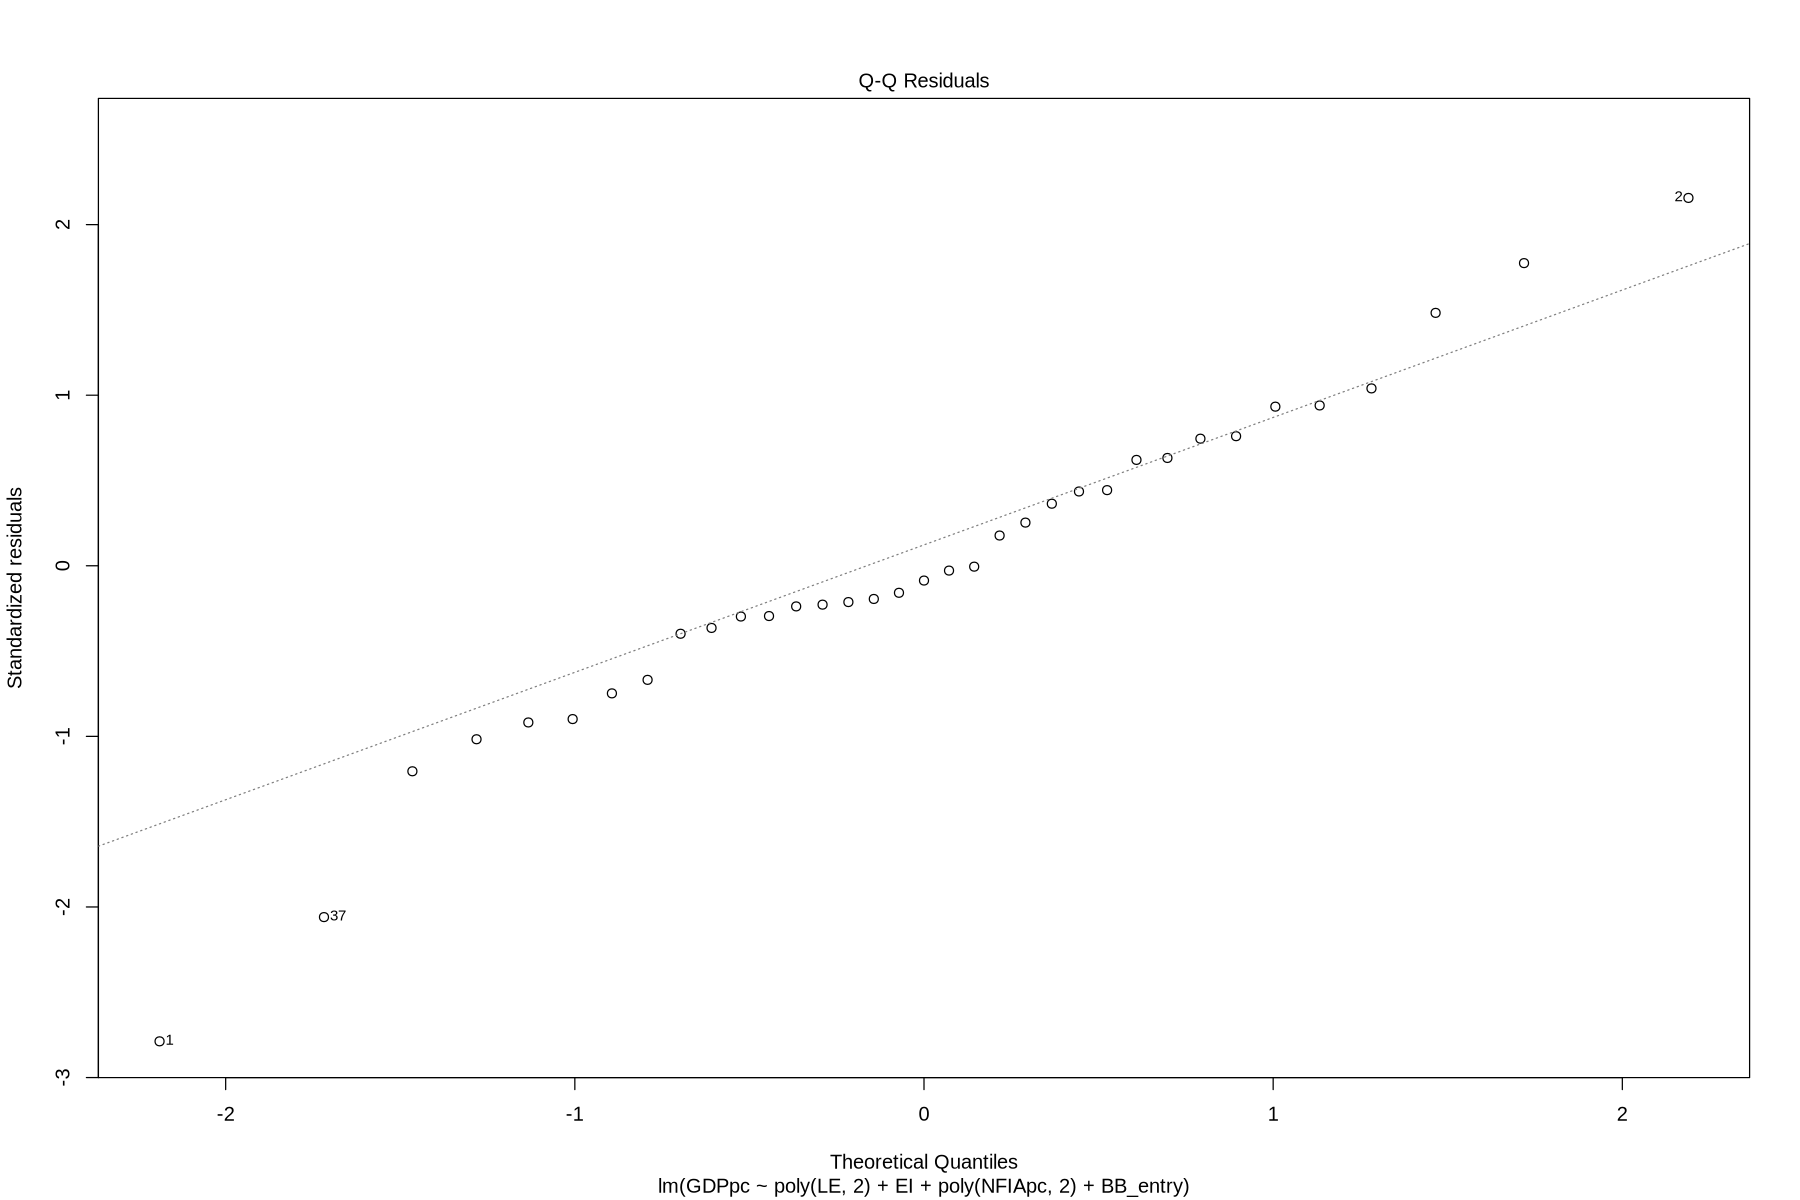

In [51]:
plot(model, which=2)

In [52]:
ols_test_normality(model)

-----------------------------------------------
       Test             Statistic       pvalue  
-----------------------------------------------
Shapiro-Wilk              0.971          0.4722 
Kolmogorov-Smirnov        0.1216         0.6349 
Cramer-von Mises          3.0952         0.0000 
Anderson-Darling          0.3809         0.3829 
-----------------------------------------------

According to the tests, only one test rejects normality - Cramer-von Mises normality test. Looking at the QQ plot we can also assume that residuals are not normal. Let's look also at histogram

In [53]:
library(goftest)

In [54]:
?ols_plot_diagnostics

ols_plot_diagnostics {olsrr},R Documentation
model,An object of class lm.
print_plot,"logical; if TRUE, prints the plot else returns a plot object."


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


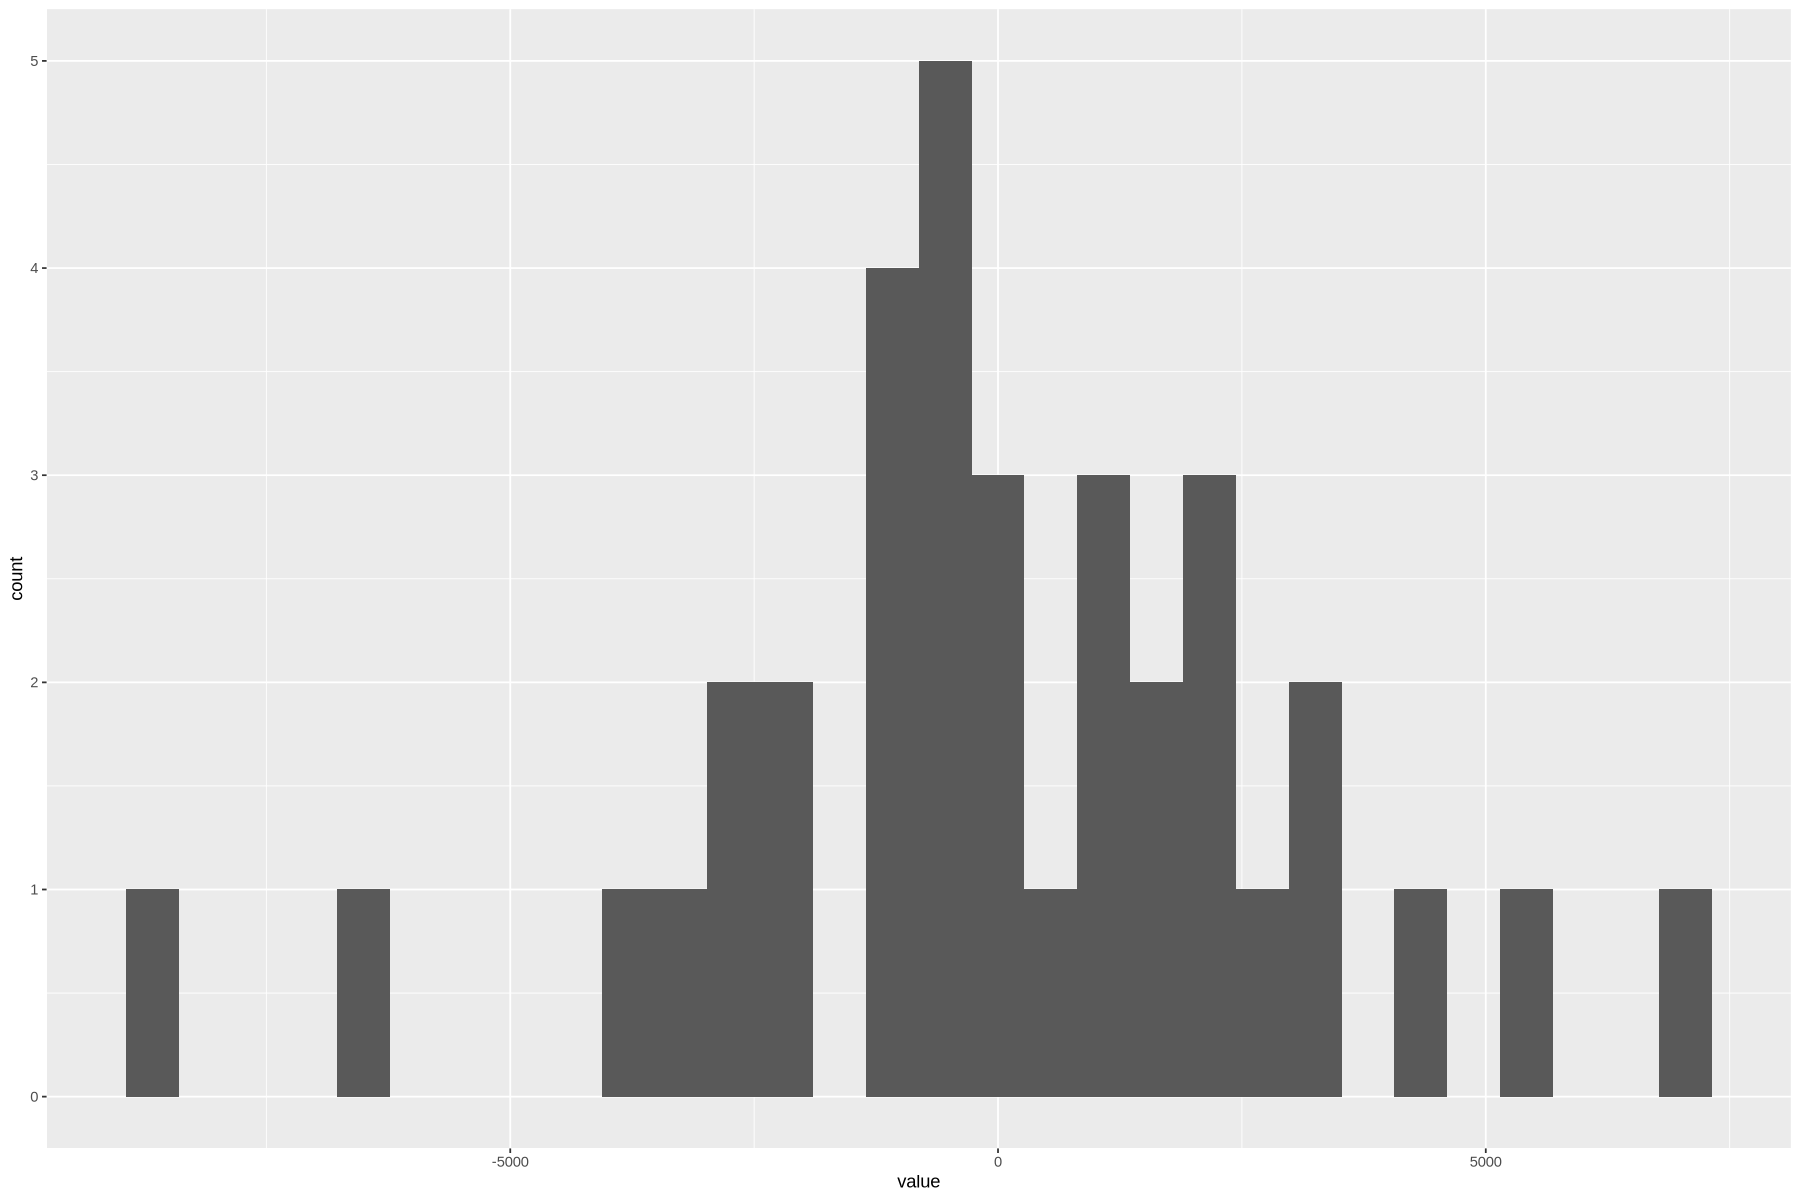

In [55]:
residuals <- data.frame(value=model$residuals)
ggplot(residuals, aes(x=value)) +
    geom_histogram()

We see that visually residuals may be from the normal distribution. So we will consider them from the noprmal distribution for the rest of the analysis

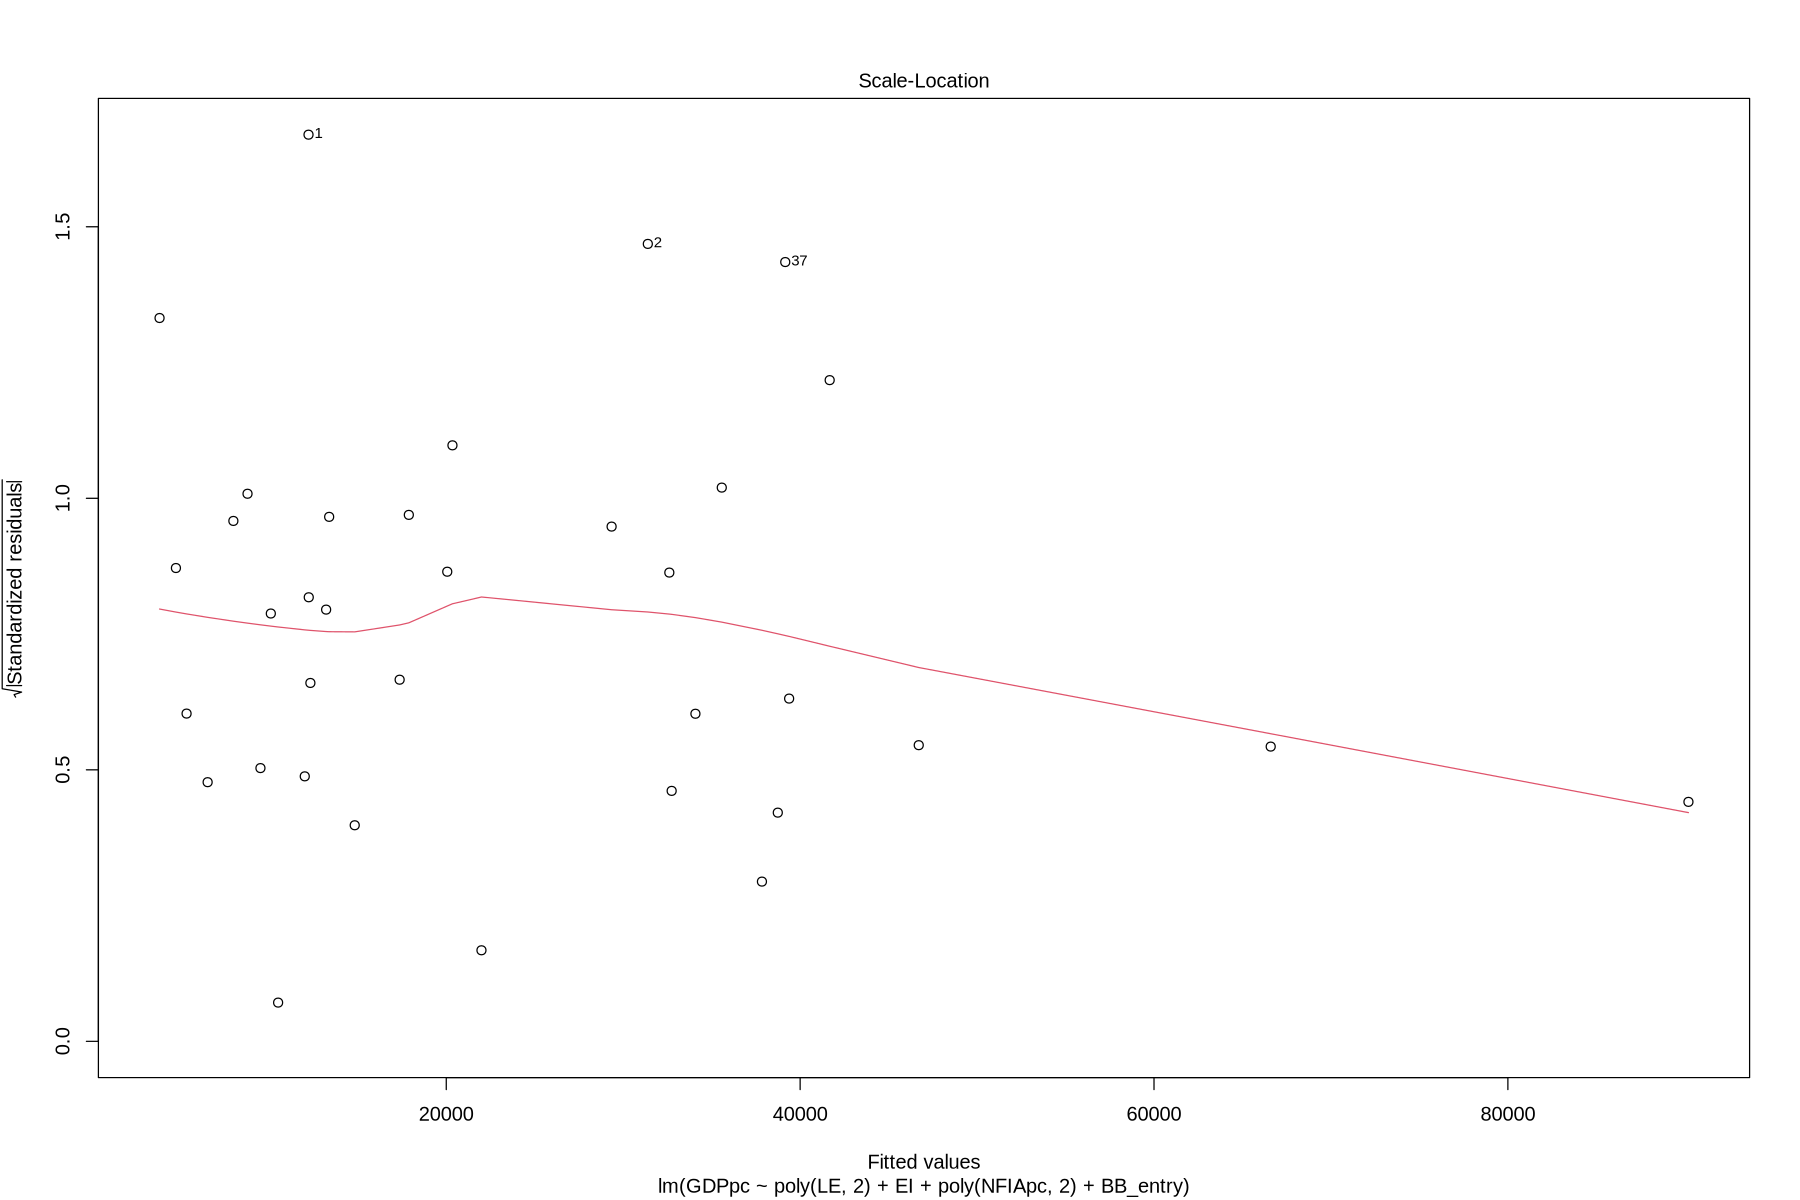

In [56]:
plot(model, which=3)

In [57]:
ols_test_breusch_pagan(model)


 Breusch Pagan Test for Heteroskedasticity
 -----------------------------------------
 Ho: the variance is constant            
 Ha: the variance is not constant        

              Data                
 ---------------------------------
 Response : GDPpc 
 Variables: fitted values of GDPpc 

        Test Summary         
 ----------------------------
 DF            =    1 
 Chi2          =    0.4118652 
 Prob > Chi2   =    0.5210243 

We fail to reject the hypotheses that the variance is constant. 

In [58]:
# TODO - understand how to check visually heteroscedascicity, Slace-Location plot, understand difference between outlier and leverage

## Final Model

Now our task is to create a final model - the model we had before - may be quite overfitted, because of the too high performance. Our task is to create a model that will generalize well.

In [59]:
summary(model)


Call:
lm(formula = GDPpc ~ poly(LE, 2) + EI + poly(NFIApc, 2) + BB_entry, 
    data = data_filtered2)

Residuals:
    Min      1Q  Median      3Q     Max 
-8895.0 -1140.4  -174.9  1862.7  6818.2 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)        -18028       8150  -2.212 0.035282 *  
poly(LE, 2)1        19242       5422   3.549 0.001389 ** 
poly(LE, 2)2         4115       3522   1.169 0.252413    
EI                  47986       9610   4.993 2.83e-05 ***
poly(NFIApc, 2)1   -78280       4979 -15.722 2.00e-15 ***
poly(NFIApc, 2)2     7841       4651   1.686 0.102973    
BB_entryTRUE         6783       1604   4.229 0.000227 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3429 on 28 degrees of freedom
Multiple R-squared:  0.973,	Adjusted R-squared:  0.9672 
F-statistic: 168.1 on 6 and 28 DF,  p-value: < 2.2e-16


In [60]:
model <- lm(GDPpc ~ poly(LE, 2) * EI * poly(NFIApc,2) * BB_entry, data = data_filtered2)
summary(model)


Call:
lm(formula = GDPpc ~ poly(LE, 2) * EI * poly(NFIApc, 2) * BB_entry, 
    data = data_filtered2)

Residuals:
    Min      1Q  Median      3Q     Max 
-4218.9  -277.4     0.0   410.6  3068.0 

Coefficients: (9 not defined because of singularities)
                                                Estimate Std. Error t value
(Intercept)                                        84457     316539   0.267
poly(LE, 2)1                                    -3293573    3315515  -0.993
poly(LE, 2)2                                    -2766322    1253156  -2.207
EI                                                -62096     374436  -0.166
poly(NFIApc, 2)1                                 -874126    4720863  -0.185
poly(NFIApc, 2)2                                 -179520    2059582  -0.087
BB_entryTRUE                                   -11927333    5679187  -2.100
poly(LE, 2)1:EI                                  3680525    3898452   0.944
poly(LE, 2)2:EI                                  2943964    138

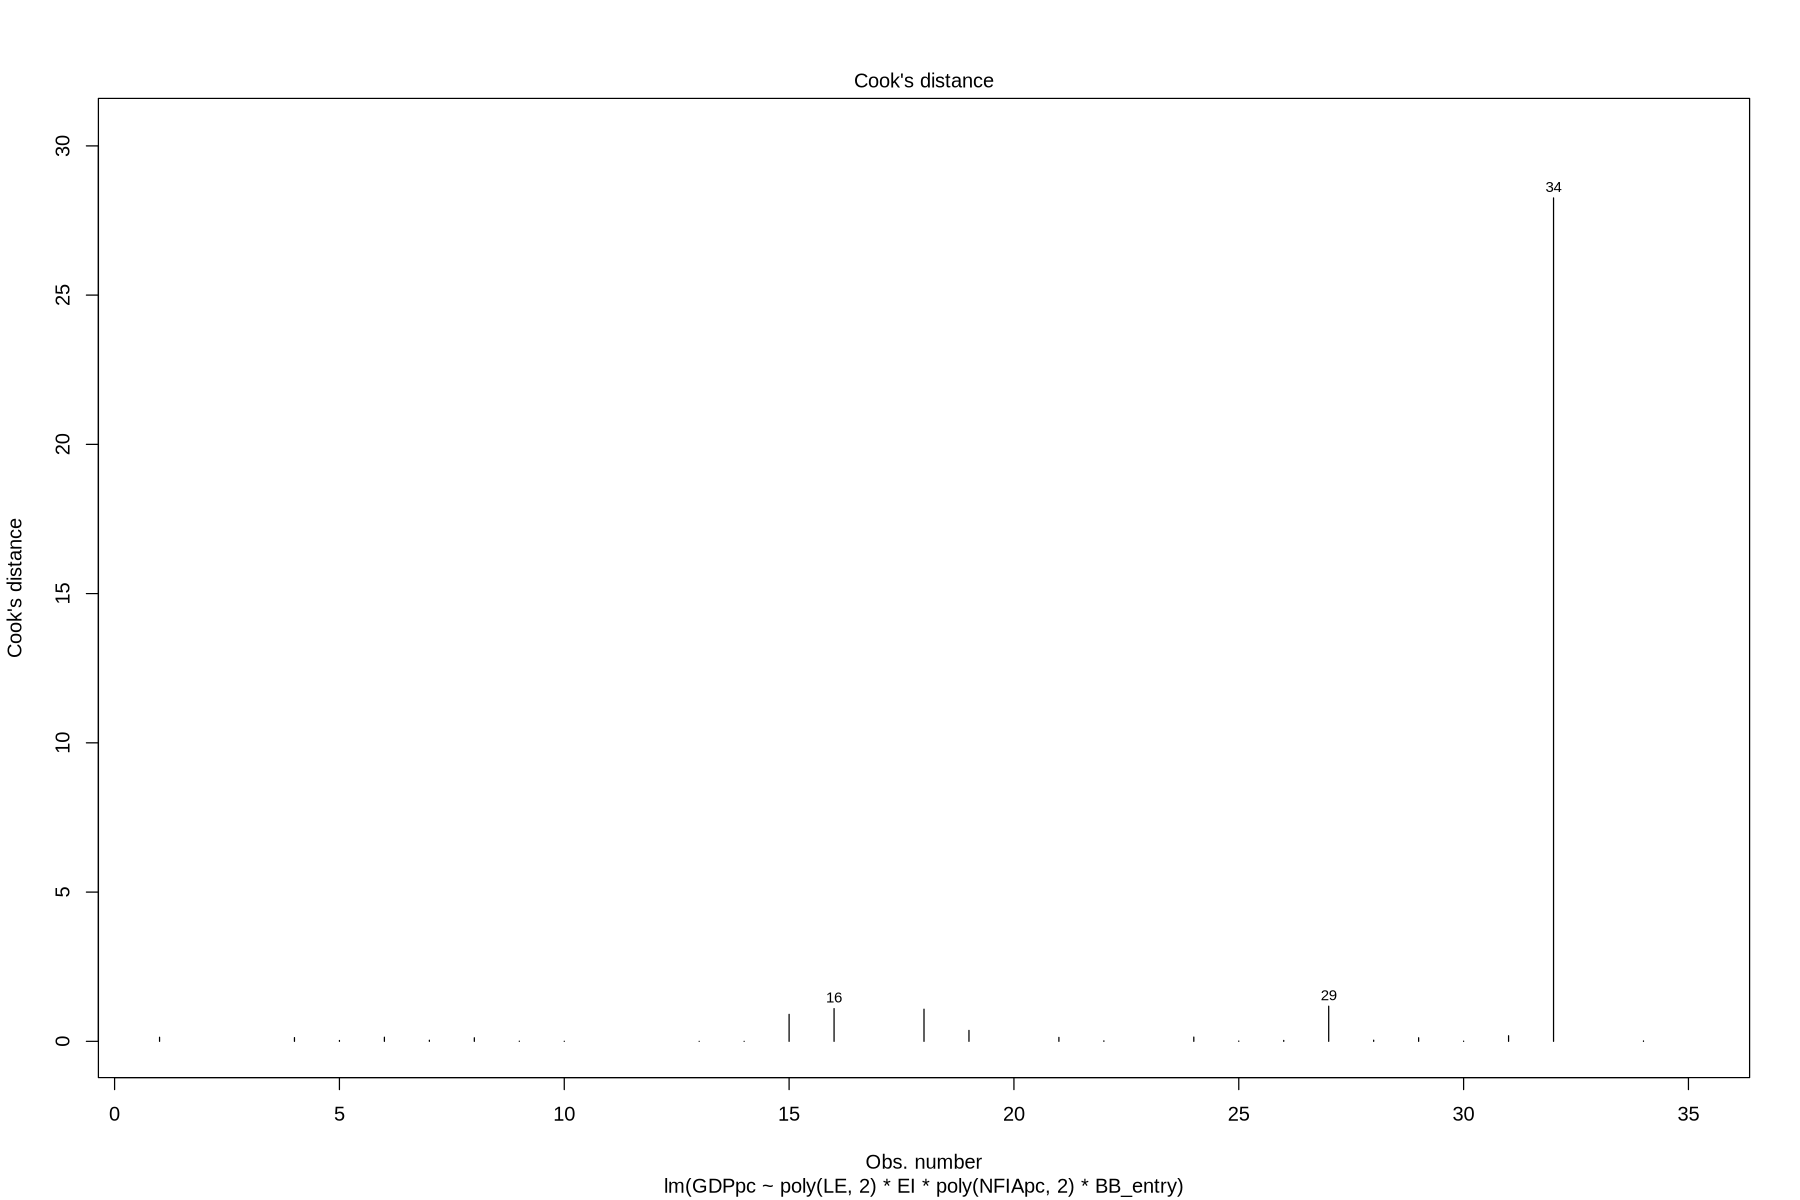

In [61]:
plot(model, which=4)

The model now is quite overfitted - we definitely should simplify it. Interesting moment is that by using interaction the adjusted R squared increased - so some of the interactions are very important, and now we just need to reduce it all to some desireable degree.

Also we see that there are some undefined coefficients. Our task now is to improve the adjusted R-squared score

We will remove interactions where undefined coefficients appear.

In [62]:
model <- lm(GDPpc ~ (poly(LE, 2) * EI * poly(NFIApc,2)) + BB_entry + BB_entry *(poly(LE, 2) + poly(NFIApc,2) + EI) + BB_entry * poly(LE, 2) * EI, data = data_filtered2)
summary(model)


Call:
lm(formula = GDPpc ~ (poly(LE, 2) * EI * poly(NFIApc, 2)) + BB_entry + 
    BB_entry * (poly(LE, 2) + poly(NFIApc, 2) + EI) + BB_entry * 
    poly(LE, 2) * EI, data = data_filtered2)

Residuals:
    Min      1Q  Median      3Q     Max 
-4912.6  -951.6   100.6   766.7  3492.4 

Coefficients:
                                  Estimate Std. Error t value Pr(>|t|)
(Intercept)                          31011     344029   0.090    0.930
poly(LE, 2)1                      -1359375    3390150  -0.401    0.698
poly(LE, 2)2                      -1603094    1133854  -1.414    0.191
EI                                   -2883     407216  -0.007    0.995
poly(NFIApc, 2)1                   -369869    5146983  -0.072    0.944
poly(NFIApc, 2)2                    -12529    2247474  -0.006    0.996
BB_entryTRUE                      -3056457    2062012  -1.482    0.172
poly(LE, 2)1:EI                    1522994    4014352   0.379    0.713
poly(LE, 2)2:EI                    1705413    1268625   1.344 

In [63]:
vif(model)

there are higher-order terms (interactions) in this model
consider setting type = 'predictor'; see ?vif



,GVIF,Df,GVIF^(1/(2*Df))
"poly(LE, 2)",1.195061e+11,2,587.95962
EI,2.737117e+03,1,52.31746
"poly(NFIApc, 2)",3.718719e+10,2,439.13529
BB_entry,2.597492e+06,1,1611.67368
"poly(LE, 2):EI",1.006409e+11,2,563.24014
"poly(LE, 2):poly(NFIApc, 2)",1.340425e+18,4,184.46131
"EI:poly(NFIApc, 2)",3.886794e+10,2,444.01524
"poly(LE, 2):BB_entry",2.886332e+10,2,412.17967
"poly(NFIApc, 2):BB_entry",1.555454e+05,2,19.85931
EI:BB_entry,2.586487e+06,1,1608.25587


We see that the GVIF is too high - in literature, it is recommended to remove all regressors that are > 5, so we will do it until the GVIF is better.

In [64]:
model <- lm(GDPpc ~ poly(LE, 2) * (EI + poly(NFIApc,2)) +
            (poly(LE, 2) + EI) * poly(NFIApc,2)+ 
            EI * (poly(LE, 2) + poly(NFIApc,2))+
            BB_entry + BB_entry *(poly(LE, 2) + poly(NFIApc,2) + EI) + BB_entry * poly(LE, 2) * EI, data = data_filtered2)
summary(model)


Call:
lm(formula = GDPpc ~ poly(LE, 2) * (EI + poly(NFIApc, 2)) + (poly(LE, 
    2) + EI) * poly(NFIApc, 2) + EI * (poly(LE, 2) + poly(NFIApc, 
    2)) + BB_entry + BB_entry * (poly(LE, 2) + poly(NFIApc, 2) + 
    EI) + BB_entry * poly(LE, 2) * EI, data = data_filtered2)

Residuals:
    Min      1Q  Median      3Q     Max 
-6551.5  -273.1    -7.7   597.0  4707.7 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)  
(Intercept)                      24572.5    67141.5   0.366   0.7203  
poly(LE, 2)1                     79902.9   201323.9   0.397   0.6979  
poly(LE, 2)2                    -15657.8   124413.3  -0.126   0.9018  
EI                                4588.5    47152.8   0.097   0.9240  
poly(NFIApc, 2)1               -661023.1  1188884.0  -0.556   0.5877  
poly(NFIApc, 2)2                470386.3   745166.0   0.631   0.5388  
BB_entryTRUE                   -611884.2   783682.4  -0.781   0.4489  
poly(LE, 2)1:EI                 -95893.3   142767.

In [65]:
vif(model)

there are higher-order terms (interactions) in this model
consider setting type = 'predictor'; see ?vif



,GVIF,Df,GVIF^(1/(2*Df))
"poly(LE, 2)",5.390945e+06,2,48.185483
EI,4.108292e+01,1,6.409596
"poly(NFIApc, 2)",2.886365e+08,2,130.343035
BB_entry,4.200064e+05,1,648.079027
"poly(LE, 2):EI",7.605835e+05,2,29.531583
"poly(LE, 2):poly(NFIApc, 2)",4.138467e+07,4,8.955811
"EI:poly(NFIApc, 2)",1.326940e+08,2,107.327941
"poly(LE, 2):BB_entry",2.737370e+09,2,228.735405
"poly(NFIApc, 2):BB_entry",3.389209e+04,2,13.568273
EI:BB_entry,4.490010e+05,1,670.075334


Now the highes value has the **poly(LE, 2):EI:BB_entry** interaction. We will remove it.

In [68]:
model <- lm(GDPpc ~
            poly(LE, 2) * (EI + poly(NFIApc,2)) +
            (poly(LE, 2) + EI) * poly(NFIApc,2) + 
            EI * (poly(LE, 2) + poly(NFIApc,2)) +
            BB_entry + 
            BB_entry *(poly(LE, 2) + poly(NFIApc,2) + EI) +
            BB_entry * (poly(LE, 2) * EI),
            data = data_filtered2)
summary(model)


Call:
lm(formula = GDPpc ~ poly(LE, 2) * (EI + poly(NFIApc, 2)) + (poly(LE, 
    2) + EI) * poly(NFIApc, 2) + EI * (poly(LE, 2) + poly(NFIApc, 
    2)) + BB_entry + BB_entry * (poly(LE, 2) + poly(NFIApc, 2) + 
    EI) + BB_entry * (poly(LE, 2) * EI), data = data_filtered2)

Residuals:
    Min      1Q  Median      3Q     Max 
-6551.5  -273.1    -7.7   597.0  4707.7 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)  
(Intercept)                      24572.5    67141.5   0.366   0.7203  
poly(LE, 2)1                     79902.9   201323.9   0.397   0.6979  
poly(LE, 2)2                    -15657.8   124413.3  -0.126   0.9018  
EI                                4588.5    47152.8   0.097   0.9240  
poly(NFIApc, 2)1               -661023.1  1188884.0  -0.556   0.5877  
poly(NFIApc, 2)2                470386.3   745166.0   0.631   0.5388  
BB_entryTRUE                   -611884.2   783682.4  -0.781   0.4489  
poly(LE, 2)1:EI                 -95893.3   14276

But threre is one problem - using vif now on interaction doesn't make sense, because we apply some transformations on the regressors, which will get the same data x - of course they will always be highly multicolliniareted - we cannot use vif here.

Instead, we will use methods - like AIC, anova, etc.

In [69]:
model_wf <- lm(GDPpc ~
               (poly(LE, 2) * EI * poly(NFIApc,2)) +
               BB_entry +
               BB_entry * (poly(LE, 2) + poly(NFIApc,2) + EI) +
               BB_entry * poly(LE, 2) * EI,
               data = data_filtered2)
summary(model_wf)


Call:
lm(formula = GDPpc ~ (poly(LE, 2) * EI * poly(NFIApc, 2)) + BB_entry + 
    BB_entry * (poly(LE, 2) + poly(NFIApc, 2) + EI) + BB_entry * 
    poly(LE, 2) * EI, data = data_filtered2)

Residuals:
    Min      1Q  Median      3Q     Max 
-4912.6  -951.6   100.6   766.7  3492.4 

Coefficients:
                                  Estimate Std. Error t value Pr(>|t|)
(Intercept)                          31011     344029   0.090    0.930
poly(LE, 2)1                      -1359375    3390150  -0.401    0.698
poly(LE, 2)2                      -1603094    1133854  -1.414    0.191
EI                                   -2883     407216  -0.007    0.995
poly(NFIApc, 2)1                   -369869    5146983  -0.072    0.944
poly(NFIApc, 2)2                    -12529    2247474  -0.006    0.996
BB_entryTRUE                      -3056457    2062012  -1.482    0.172
poly(LE, 2)1:EI                    1522994    4014352   0.379    0.713
poly(LE, 2)2:EI                    1705413    1268625   1.344 

In [70]:
ols_test_normality(model_wf)

-----------------------------------------------
       Test             Statistic       pvalue  
-----------------------------------------------
Shapiro-Wilk              0.9497         0.1111 
Kolmogorov-Smirnov        0.1235         0.6155 
Cramer-von Mises          3.2667         0.0000 
Anderson-Darling          0.6182         0.0992 
-----------------------------------------------

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


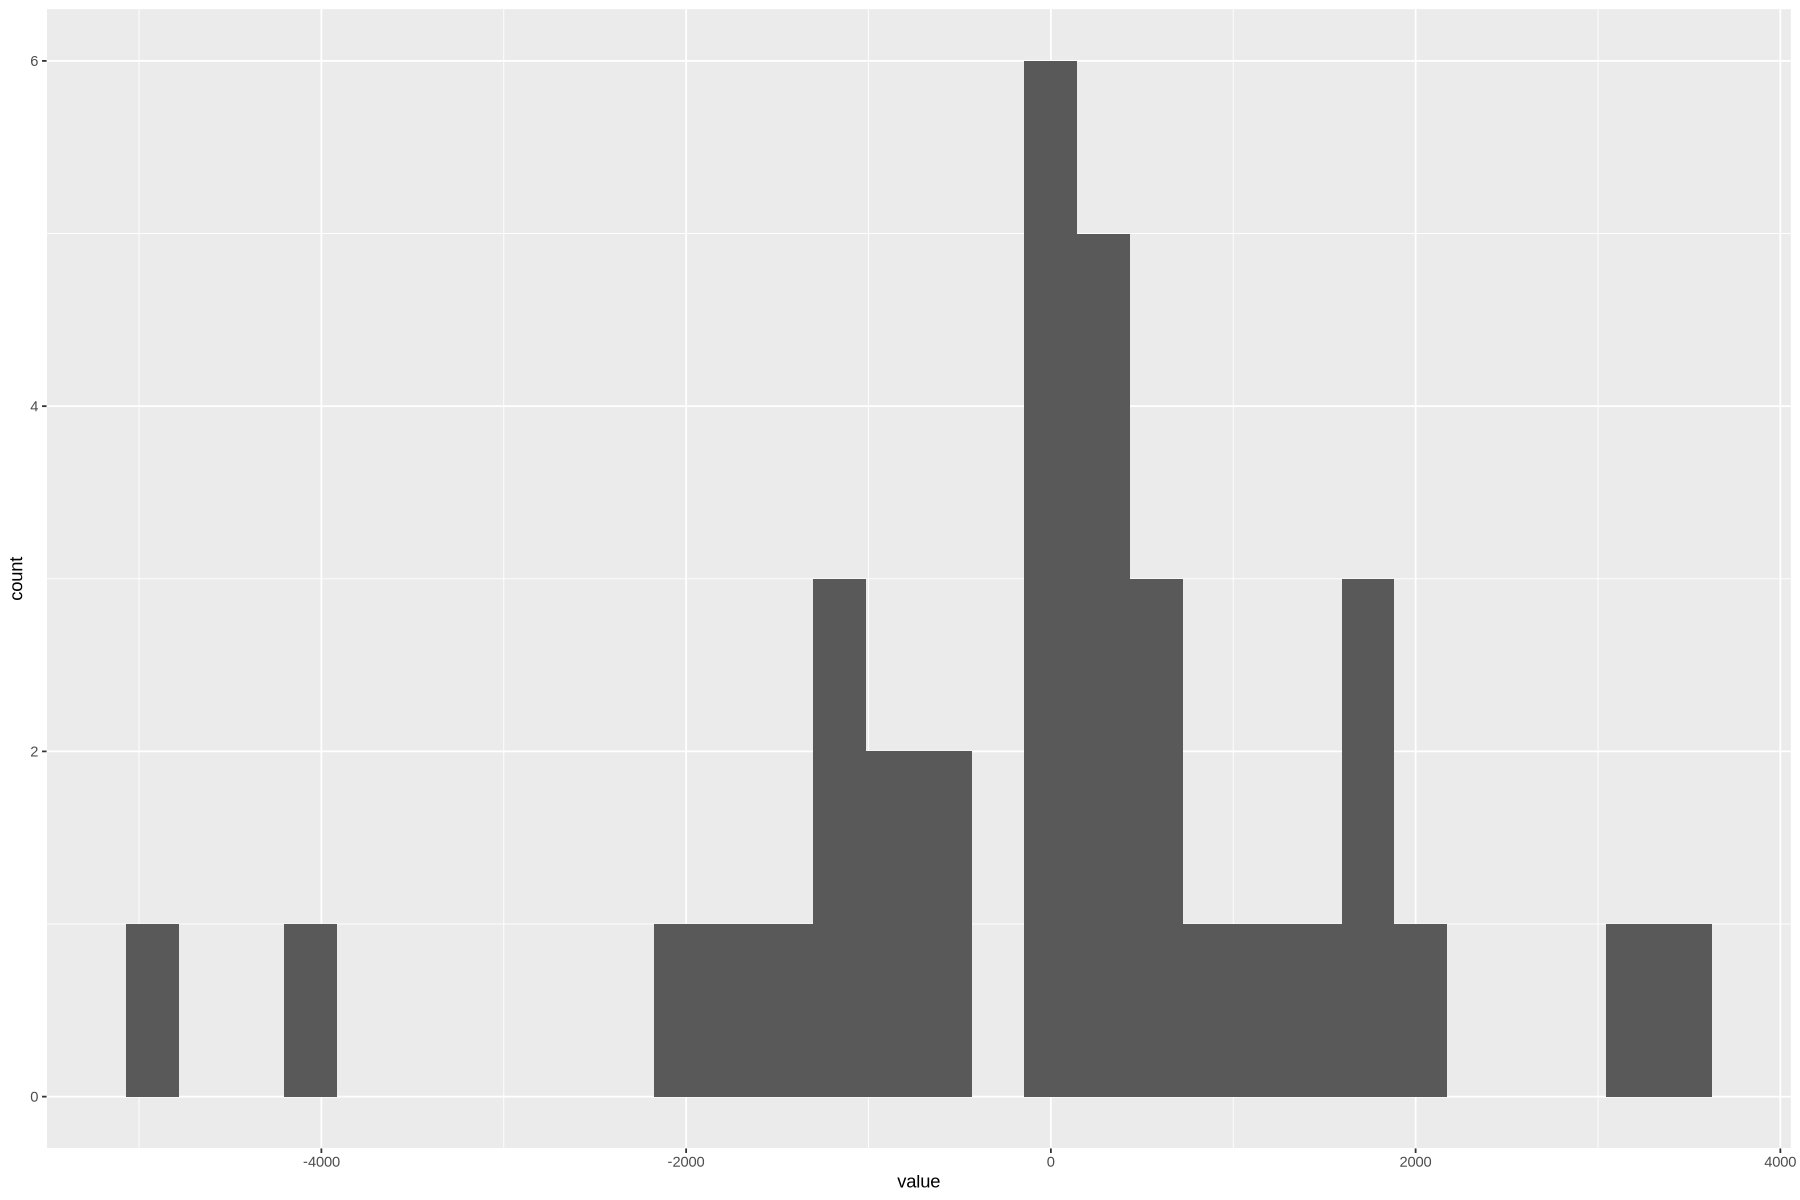

In [71]:
residuals <- data.frame(value=model_wf$residuals)
ggplot(residuals, aes(x=value)) +
    geom_histogram()

We don't have a lot of data - only about 35. Visually it resembles the gaussian distribution. Let's check how well those tests behave with small amount of data.

With generating 35 values from gaussian, we can see, that often some tests will reject the normality, though we know that data were generated from the normal distro.

For our residuals - we have 3 tests that fail to reject and one that rejects. Let's for now consider that we have normal residuals. And lets see the QQ plot also


In [72]:
# Generate random Gaussian distribution
# seed <- .Random.seed
# set.seed(seed)

d <- rnorm(35, mean = 0, sd = 1)
# Perform Shapiro-Wilk test
shapiro_test <- shapiro.test(d)
print(shapiro_test)

# Perform Kolmogorov-Smirnov test
ks_test <- ks.test(data, "pnorm", mean = mean(d), sd = sd(d))
print(ks_test)

# Perform Cramer-von Mises test
cvm_test <- cvm.test(data, "pnorm", mean = mean(d), sd = sd(d))
print(cvm_test)

# Perform Anderson-Darling test
ad_test <- ad.test(d)
print(ad_test)


	Shapiro-Wilk normality test

data:  d
W = 0.99011, p-value = 0.9851



Warning message in ks.test.default(data, "pnorm", mean = mean(d), sd = sd(d)):
“ties should not be present for the Kolmogorov-Smirnov test”


ERROR: Error in y(sort(x), ...): Non-numeric argument to mathematical function


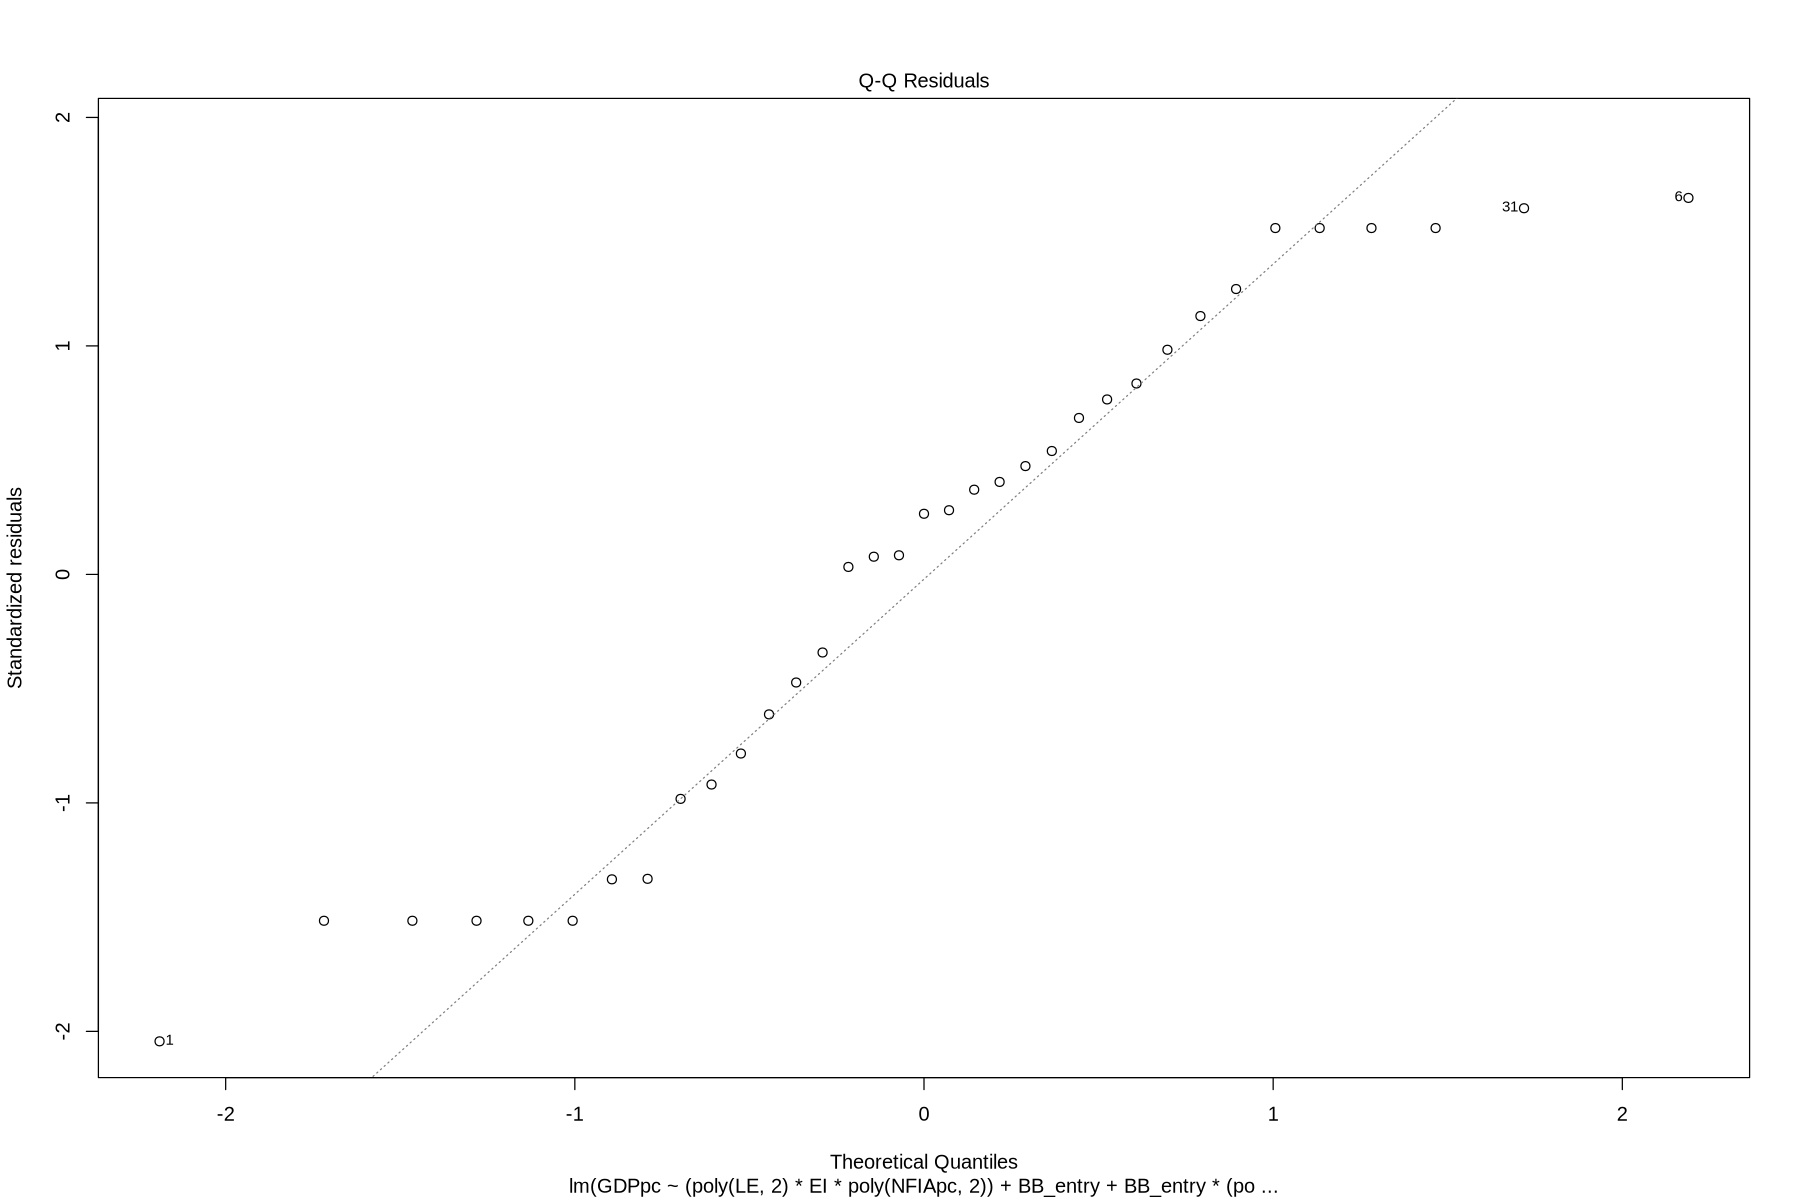

In [73]:
plot(model_wf, which=2)

Visually it has problems with quantiles on tails, but the rest of the data is fine.

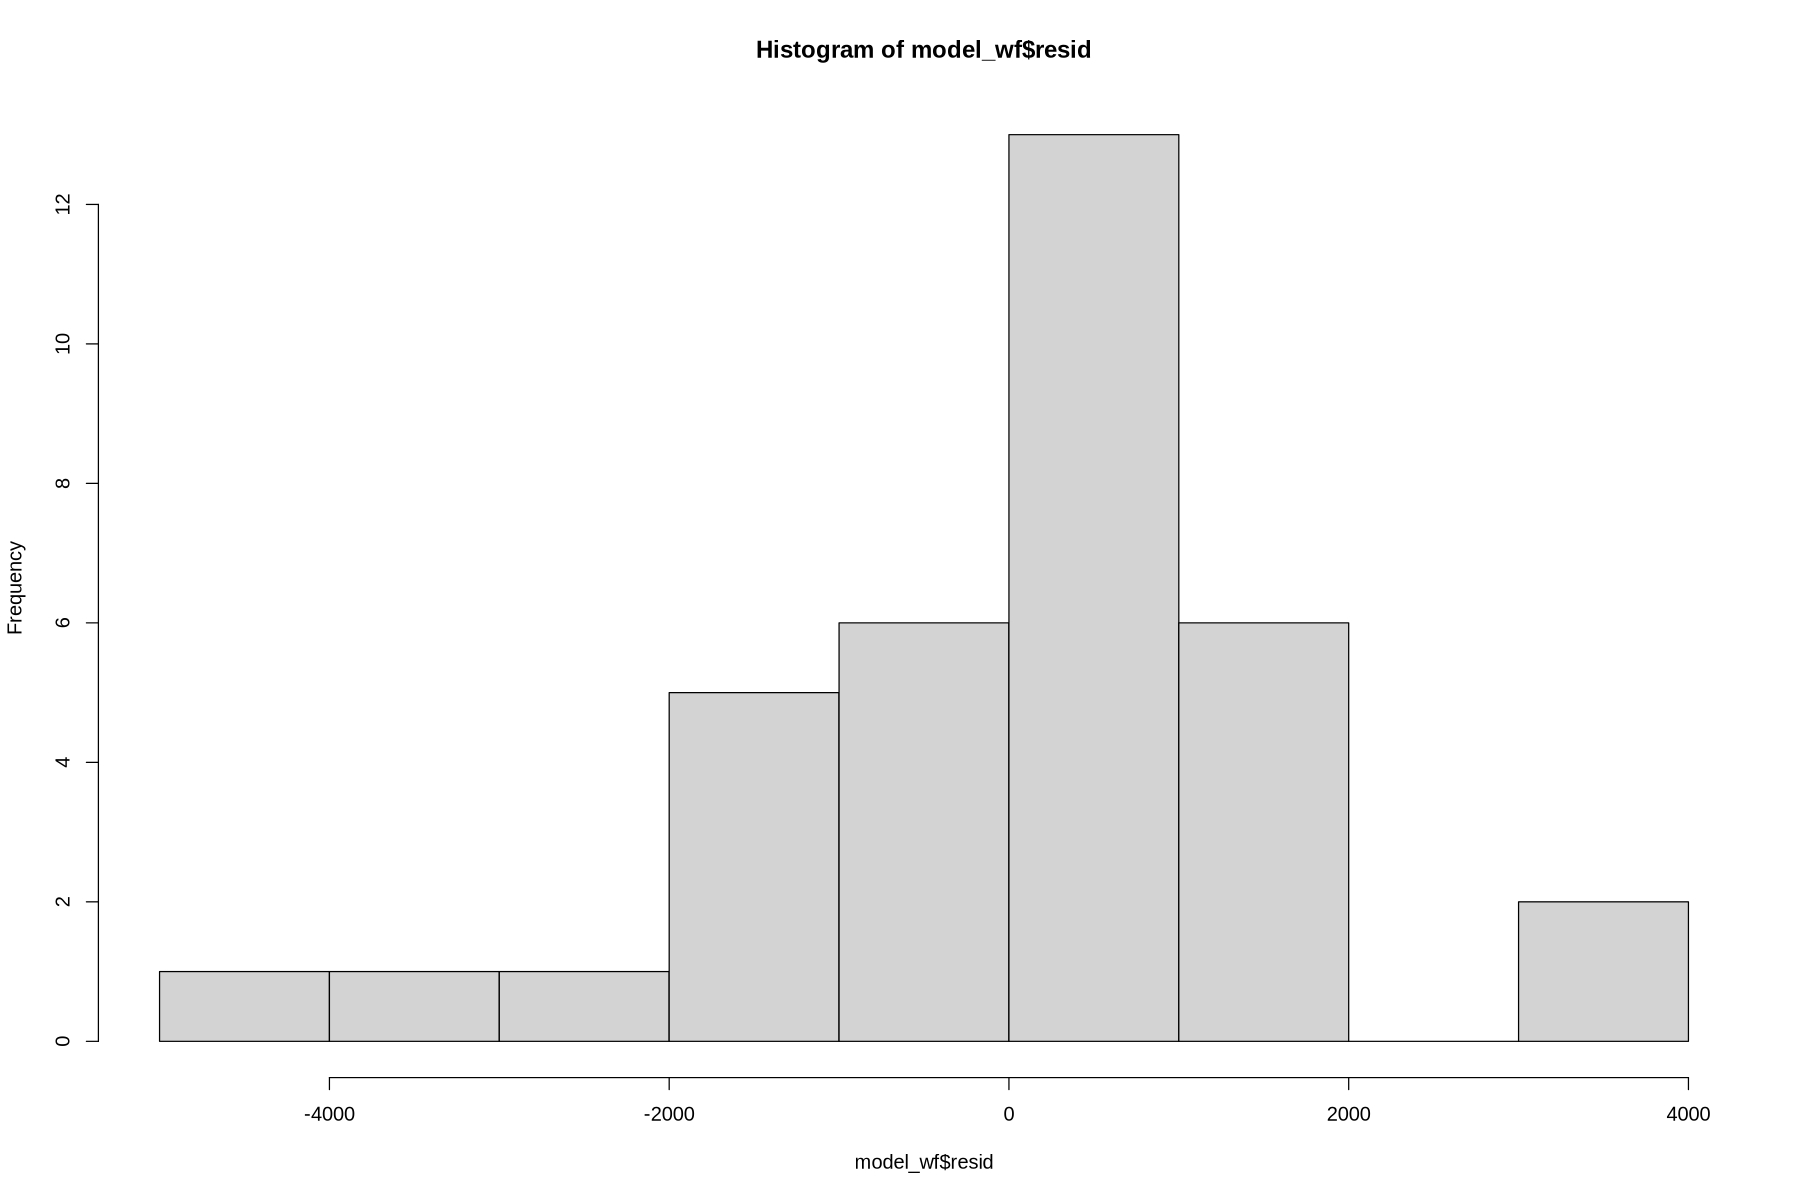

In [74]:
hist(model_wf$resid)

Another visualization - it is quite normal to the eye.

We will use the shapiro wilk test as a result, because it works well on small sample sizes. Kolmogorov smirnov also shoed failure.  The rest of the tests are better for bigger datasets, which is not our case, so we will use the Shapiro wilk test results. Meaning that we now can use anova, AIC and other model-submodel techniques based on the base models normality of residuals.


In [88]:
drop1(model_wf, test='F')

,Df,Sum of Sq,RSS,AIC,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
<none>,NA,NA,98496004,571.7562,NA,NA
"poly(NFIApc, 2):BB_entry",2,18139648,116635651,573.6726,0.8287485,0.4673506
"poly(LE, 2):EI:poly(NFIApc, 2)",4,28595184,127091188,572.6774,0.6532160,0.6391424
"poly(LE, 2):EI:BB_entry",2,45325090,143821094,581.0056,2.0707734,0.1820464


In [89]:
summary(model_wf)


Call:
lm(formula = GDPpc ~ (poly(LE, 2) * EI * poly(NFIApc, 2)) + BB_entry + 
    BB_entry * (poly(LE, 2) + poly(NFIApc, 2) + EI) + BB_entry * 
    poly(LE, 2) * EI, data = data_filtered2)

Residuals:
    Min      1Q  Median      3Q     Max 
-4912.6  -951.6   100.6   766.7  3492.4 

Coefficients:
                                  Estimate Std. Error t value Pr(>|t|)
(Intercept)                          31011     344029   0.090    0.930
poly(LE, 2)1                      -1359375    3390150  -0.401    0.698
poly(LE, 2)2                      -1603094    1133854  -1.414    0.191
EI                                   -2883     407216  -0.007    0.995
poly(NFIApc, 2)1                   -369869    5146983  -0.072    0.944
poly(NFIApc, 2)2                    -12529    2247474  -0.006    0.996
BB_entryTRUE                      -3056457    2062012  -1.482    0.172
poly(LE, 2)1:EI                    1522994    4014352   0.379    0.713
poly(LE, 2)2:EI                    1705413    1268625   1.344 

In [ ]:
lm(GDPpc ~
               (poly(LE, 2) * EI * poly(NFIApc,2)) +
               BB_entry +
               BB_entry * (poly(LE, 2) + poly(NFIApc,2) + EI) +
               BB_entry * poly(LE, 2) * EI,
               data = data_filtered2)

In [94]:
attach(data_filtered2)
step(lm(GDPpc ~1),
     scope=list(lower=~1,
     upper=~(poly(LE, 2) * EI * poly(NFIApc,2)) +
           BB_entry +
           BB_entry * (poly(LE, 2) + poly(NFIApc,2) + EI) +
           BB_entry * poly(LE, 2) * EI))
dettach(data_filtered2)

The following objects are masked from data_filtered2 (pos = 3):

    BB_entry, country, EI, GDPpc, LE, NFIApc


The following objects are masked from data_filtered2 (pos = 4):

    BB_entry, country, EI, GDPpc, LE, NFIApc




Start:  AIC=690.4
GDPpc ~ 1

                  Df  Sum of Sq        RSS    AIC
+ poly(NFIApc, 2)  2 1.1115e+10 1.0756e+09 609.43
+ poly(LE, 2)      2 5.7930e+09 6.3973e+09 671.83
+ BB_entry         1 4.6345e+09 7.5557e+09 675.66
+ EI               1 2.7166e+09 9.4737e+09 683.58
<none>                          1.2190e+10 690.40

Step:  AIC=609.43
GDPpc ~ poly(NFIApc, 2)

                  Df  Sum of Sq        RSS    AIC
+ BB_entry         1 3.5353e+08 7.2204e+08 597.48
+ EI               1 2.2577e+08 8.4981e+08 603.18
+ poly(LE, 2)      2 2.2742e+08 8.4816e+08 605.11
<none>                          1.0756e+09 609.43
- poly(NFIApc, 2)  2 1.1115e+10 1.2190e+10 690.40

Step:  AIC=597.48
GDPpc ~ poly(NFIApc, 2) + BB_entry

                           Df  Sum of Sq        RSS    AIC
+ EI                        1  238062559  483977448 585.48
+ poly(LE, 2)               2   99718786  622321221 596.28
<none>                                    722040007 597.48
+ poly(NFIApc, 2):BB_entry  2   4636


Call:
lm(formula = GDPpc ~ poly(NFIApc, 2) + BB_entry + EI + poly(LE, 
    2))

Coefficients:
     (Intercept)  poly(NFIApc, 2)1  poly(NFIApc, 2)2      BB_entryTRUE  
          -18029            -78280              7841              6783  
              EI      poly(LE, 2)1      poly(LE, 2)2  
           47986             19242              4115  


ERROR: Error in dettach(data_filtered2): could not find function "dettach"


In [95]:
m = lm(GDPpc ~ poly(NFIApc, 2) + BB_entry + EI + poly(LE, 2), data_filtered2)
summary(m)


Call:
lm(formula = GDPpc ~ poly(NFIApc, 2) + BB_entry + EI + poly(LE, 
    2), data = data_filtered2)

Residuals:
    Min      1Q  Median      3Q     Max 
-8895.0 -1140.4  -174.9  1862.7  6818.2 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)        -18028       8150  -2.212 0.035282 *  
poly(NFIApc, 2)1   -78280       4979 -15.722 2.00e-15 ***
poly(NFIApc, 2)2     7841       4651   1.686 0.102973    
BB_entryTRUE         6783       1604   4.229 0.000227 ***
EI                  47986       9610   4.993 2.83e-05 ***
poly(LE, 2)1        19242       5422   3.549 0.001389 ** 
poly(LE, 2)2         4115       3522   1.169 0.252413    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3429 on 28 degrees of freedom
Multiple R-squared:  0.973,	Adjusted R-squared:  0.9672 
F-statistic: 168.1 on 6 and 28 DF,  p-value: < 2.2e-16


We see, taht using AIC score we have got a model with lower AIC score, but its R-statistics are not as good. Thugh this may be not a big problem - because those stats are based on train data, so probably we get better generalization with those parameters.

Now lets proceed with further adjustments - we see that some of the regressors are statistically insignificant. We will remove them one by one.

In [97]:
ols_test_normality(m)

-----------------------------------------------
       Test             Statistic       pvalue  
-----------------------------------------------
Shapiro-Wilk              0.971          0.4722 
Kolmogorov-Smirnov        0.1216         0.6349 
Cramer-von Mises          3.0952         0.0000 
Anderson-Darling          0.3809         0.3829 
-----------------------------------------------

Again, we consider only the shapiro-Wilk test - our model has normal distribution of residuals, we can choose submodels for further testing

In [107]:
m_sub1 = lm(GDPpc ~ NFIApc + BB_entry + EI + poly(LE,2), data_filtered2)
summary(m_sub1)
m_sub2 = lm(GDPpc ~ poly(NFIApc, 2) + BB_entry + EI + LE, data_filtered2)
summary(m_sub2)


Call:
lm(formula = GDPpc ~ NFIApc + BB_entry + EI + poly(LE, 2), data = data_filtered2)

Residuals:
    Min      1Q  Median      3Q     Max 
-9541.3 -1478.6   258.9  2711.0  6249.1 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -7832.0732  7708.5029  -1.016 0.318017    
NFIApc          -1.7976     0.1003 -17.919  < 2e-16 ***
BB_entryTRUE  6915.8267  1651.9743   4.186 0.000241 ***
EI           41223.8792  9006.2513   4.577  8.2e-05 ***
poly(LE, 2)1 14043.2057  4599.3673   3.053 0.004812 ** 
poly(LE, 2)2  3582.6351  3617.0277   0.990 0.330127    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3536 on 29 degrees of freedom
Multiple R-squared:  0.9703,	Adjusted R-squared:  0.9651 
F-statistic: 189.2 on 5 and 29 DF,  p-value: < 2.2e-16



Call:
lm(formula = GDPpc ~ poly(NFIApc, 2) + BB_entry + EI + LE, data = data_filtered2)

Residuals:
    Min      1Q  Median      3Q     Max 
-9928.4 -1219.7    52.5  1908.1  6470.3 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      -107434.8    28602.0  -3.756 0.000772 ***
poly(NFIApc, 2)1  -79098.1     4960.6 -15.945 6.87e-16 ***
poly(NFIApc, 2)2    7353.0     4661.8   1.577 0.125576    
BB_entryTRUE        6999.7     1603.1   4.366 0.000147 ***
EI                 46218.3     9550.3   4.839 3.96e-05 ***
LE                  1148.1      336.4   3.413 0.001912 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3450 on 29 degrees of freedom
Multiple R-squared:  0.9717,	Adjusted R-squared:  0.9668 
F-statistic:   199 on 5 and 29 DF,  p-value: < 2.2e-16


In [109]:
AIC(m, m_sub1, m_sub2)

,df,AIC
,<dbl>,<dbl>
m,8,677.3150
m_sub1,7,678.6979
m_sub2,7,676.9817


We see that the second sub model has a better AIC score - so we will proceed to that model

In [111]:
anova(m, m_sub1, m_sub2, test='F')

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,28,329202636,NA,NA,NA,NA
2,29,362610762,-1,-33408126,2.841495,0.1029731
3,29,345258986,0,17351776,NA,NA


In [113]:
anova(m, m_sub1, m_sub2, test='Chisq')

,Res.Df,RSS,Df,Sum of Sq,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,28,329202636,NA,NA,NA
2,29,362610762,-1,-33408126,0.09185873
3,29,345258986,0,17351776,NA


In [114]:
current <- lm(GDPpc ~ poly(NFIApc, 2) + BB_entry + EI + LE, data_filtered2)
summary(current)


Call:
lm(formula = GDPpc ~ poly(NFIApc, 2) + BB_entry + EI + LE, data = data_filtered2)

Residuals:
    Min      1Q  Median      3Q     Max 
-9928.4 -1219.7    52.5  1908.1  6470.3 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      -107434.8    28602.0  -3.756 0.000772 ***
poly(NFIApc, 2)1  -79098.1     4960.6 -15.945 6.87e-16 ***
poly(NFIApc, 2)2    7353.0     4661.8   1.577 0.125576    
BB_entryTRUE        6999.7     1603.1   4.366 0.000147 ***
EI                 46218.3     9550.3   4.839 3.96e-05 ***
LE                  1148.1      336.4   3.413 0.001912 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3450 on 29 degrees of freedom
Multiple R-squared:  0.9717,	Adjusted R-squared:  0.9668 
F-statistic:   199 on 5 and 29 DF,  p-value: < 2.2e-16


In [115]:
ols_test_normality(current)

-----------------------------------------------
       Test             Statistic       pvalue  
-----------------------------------------------
Shapiro-Wilk              0.9529         0.1388 
Kolmogorov-Smirnov        0.1228         0.6224 
Cramer-von Mises          2.9238         0.0000 
Anderson-Darling          0.5069         0.1877 
-----------------------------------------------

Residuals may be normal

In [117]:
current_sub <- lm(GDPpc ~ NFIApc + BB_entry + EI + LE, data_filtered2)
summary(current_sub)


Call:
lm(formula = GDPpc ~ NFIApc + BB_entry + EI + LE, data = data_filtered2)

Residuals:
     Min       1Q   Median       3Q      Max 
-10413.0  -1398.3   -205.5   2299.4   5974.8 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -7.401e+04  2.262e+04  -3.272 0.002692 ** 
NFIApc       -1.809e+00  9.965e-02 -18.152  < 2e-16 ***
BB_entryTRUE  7.099e+03  1.641e+03   4.325 0.000155 ***
EI            4.004e+04  8.924e+03   4.487 9.87e-05 ***
LE            8.487e+02  2.845e+02   2.984 0.005618 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3535 on 30 degrees of freedom
Multiple R-squared:  0.9692,	Adjusted R-squared:  0.9651 
F-statistic: 236.4 on 4 and 30 DF,  p-value: < 2.2e-16


So basically we have came back to our first model with all features. This model is the best now. It's quality though isn't the best now, because we have dropped 2 outliers in expectaion that this will very much help on real unseen data.
All the regressors are significant - there is nothing to remove. We are OK with this model.

## References


used in outliers section for understanding difference between outliers and leverages - https://online.stat.psu.edu/stat462/node/170/#:~:text=In%20short%3A,is%20particularly%20high%20or%20low.


https://en.wikipedia.org/wiki/Cook%27s_distance